# ПРОЕКТ НИР

## Библиотеки (без версий)

In [ ]:
!pip install catboost

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import resample
from sklearn.base import clone
from scipy.stats import pointbiserialr, spearmanr
import shap

## Загрузка данных

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/НИР/База ДКА увеличенная.xlsx')

data.head()

N пп Дата рождения       ИБ  тип СД (1-1, 2-2, 3 -др)  \
0     1    1990-06-20  79839.0                       1.0   
1     2    1962-05-13  19958.0                       2.0   
2     3    2001-09-18  77329.0                       1.0   
3     4    1983-07-21  53455.0                       2.0   
4     5    1977-07-08  47190.0                       1.0   

   Возраст (на текущий момент)  Пол (0 - Ж, 1 - М) Дата текущего ДКА  \
0                         35.0                 1.0              2019   
1                         63.0                 1.0              2019   
2                         24.0                 1.0              2024   
3                         42.0                 0.0              2024   
4                         48.0                 0.0              2019   

  Длительность СД (лет)  Возраст манифестации СД  \
0                     1                     34.0   
1                     6                     57.0   
2             0 (дебют)                     23.0   
3                   0.1                     42.0   
4                    10                     32.0   

   Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
0                                                1.0          
1                                                1.0          
2                                                0.0          
3                                                1.0          
4                                                2.0          

   Применение НМГ (0 - нет, 1 - да)  Суточная доза инсулина  \
0                               0.0                     NaN   
1                               0.0                    54.0   
2                               0.0                    32.0   
3                               0.0                    32.0   
4                               0.0                    35.0   

  Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   Количество эпизодов легких гипогликемий в неделю Количество ДКА в анамнезе  \
0                                               0.0                         1   
1                                               0.0                         3   
2                                               0.0                         1   
3                                               0.0                         1   
4                                               0.0                         2   

  ХБП, С  ХБП, А  Невролог  \
0      1     1.0       0.0   
1      2     1.0       0.0   
2      1     1.0       0.0   
3      1     2.0       1.0   
4      1     1.0       1.0   

   Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
0                                                0.0                                           
1                                                0.0                                           
2                                                0.0                                           
3                                                0.0                                           
4                                                1.0                                           

   Целевой HbA1c  HbA1c  Креатинин при поступлении  Мочевина при поступлении  \
0            6.5    NaN                        NaN                       NaN   
1            7.5    NaN                      261.0                      24.5   
2            6.5    NaN                      110.0                       8.4   
3            6.5    9.6                      167.0                       7.2   
4            6.5    NaN                        NaN                       NaN   

  pH при поступлении ВЕ при поступлении Лактат при поступлении  \
0              

## Знакомство с данными

### Описание колонок

1.  **N пп** - номер пациента
2.  **Дата рождения**
3.  **ИБ** - история болезни, удалить
4.  **тип СД (1-1, 2-2, 3 -др)** -тип сахарного диабета
5.  **Возраст (на текущий момент)**
6.  **Пол (0 - Ж, 1 - М)**
7.  **Дата текущего ДКА** (диабетический кетоацидоз) - когда заполняли данные для данного пациента
8.  **Длительность СД (сахарный диабет) (лет)** - сколько лет диабету
9.  **Возраст манифестации СД** (сахарный диабет) - когда впервые возник диабет
10. **Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА**, нуль у тех, кто дебютировал, то есть еще не кололся
11. **Применение НМГ (непрерывный мониторинг глюкозы) (0 - нет, 1 - да)** - означает, есть ли датчик в пациенте (ненужная фигня, сказали)
12. **Суточная доза инсулина**
13. **Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)** (бесполезная строка)
14. **Количество эпизодов легких гипогликемий в неделю** (бесполезная строка)
15. **Количество ДКА в анамнезе**
16. **ХБП, С** - хроническая болезнь почек, скорость клубочковой фильтрации, С это класс
17. **ХБП, А** - хроническая болезнь почек, потеря альбумина, А это класс
18. **Невролог** - 1-есть полинейропатия, 0 - нет
19. **Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)** - осложнение на глаза, цифры - это формы
20. **Целевой HbA1c** (гликированный гемоглобин, рекомендация, бесполезная фича)
21. **HbA1c** (гликированный гемоглобин в реал лайф)
22. **Креатинин при поступлении**
23. **Мочевина при поступлении**
24. **pH при поступлении**
25. **ВЕ при поступлении**
26. **Лактат при поступлении**
27. **Калий при поступлении**
28. **Натрий при поступлении**
29. **Глюкоза при поступлении**
30. **Общий холестерин**
31. **ЛПНП** - липопротеиды низкой плотности
32. **ЛПВП** - липопротеиды высокой плотности
33. **ТГ** - триглицериды (опасный жир)
34. **Сутки, на которые произошла нормализация рН** - нету, но будет позже, должно по крайней мере..
35. **Степень тяжести ДКА**
36. **Алкоголь за сутки до ДКА (0 - нет, 1 - да)**
37. **Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)** - психоактивные вещества
38. **Шкала депрессии Бека** - не знаем, будет ли
39. **Опрос о страхе гипогликемии** - не знаем, будет ли
40. **CV** - коэффициент вариации
41. **Время нахождения в диапазоне ниже 4 ммоль/л (%)** - не знаем, будет ли, т.к. показатель для тех, у кого 1 в применении НМГ
42. **GMI (%)** - не знаем, будет ли, т.к. показатель для тех, у кого 1 в применении НМГ
43. **TAR1 (%)** - не знаем, будет ли, т.к. показатель для тех, у кого 1 в применении НМГ
44. **TAR2 (%)** - не знаем, будет ли, т.к. показатель для тех, у кого 1 в применении НМГ
45. **TIR (%)** - не знаем, будет ли, т.к. показатель для тех, у кого 1 в применении НМГ
46. **TBR1 (%)** - не знаем, будет ли, т.к. показатель для тех, у кого 1 в применении НМГ
47. **TBR2 (%)** - не знаем, будет ли, т.к. показатель для тех, у кого 1 в применении НМГ
48. **Данные о смерти** 1-смерть, nan - достоверно неизвестно (лучше не учитывать, наверное)
49. **Рецидив (0 - единичный, 1 - рецидив)** - таргет

In [ ]:
### сразу удаляем неинформативные колонки типа номера истории болезни, пациента
data = data.drop(['N пп', 'ИБ'], axis=1)

In [ ]:
### посмотрим на типы колонок
data.dtypes

Дата рождения                                                                                datetime64[ns]
тип СД (1-1, 2-2, 3 -др)                                                                            float64
Возраст (на текущий момент)                                                                         float64
Пол (0 - Ж, 1 - М)                                                                                  float64
Дата текущего ДКА                                                                                    object
Длительность СД (лет)                                                                                object
Возраст манифестации СД                                                                             float64
Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА                                            float64
Применение НМГ (0 - нет, 1 - да)                                                                    float64
Суточная доза инсулина                                                                              float64
Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)                                                    object
Количество эпизодов легких гипогликемий в неделю                                                    float64
Количество ДКА в анамнезе                                                                            object
ХБП, С                                                                                               object
ХБП, А                                                                                              float64
Невролог                                                                                            float64
Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)           float64
Целевой HbA1c                                                                                       float64
HbA1c                                                                                               float64
Креатинин при поступлении                                                                           float64
Мочевина при поступлении                                                                            float64
pH при поступлении                                                                                   object
ВЕ при поступлении                                                                                   object
Лактат при поступлении                                                                               object
Калий при поступлении                                                                               float64
Натрий при поступлении                                                                              float64
Глюкоза при поступлении                                                                             float64
Общий холестерин                                                                                    float64
ЛПНП                                                                                                float64
ЛПВП                                                                                                float64
ТГ                                                                                                  float64
Сутки, на которые произошла нормализация рН                                                         float64
Степень тяжести ДКА                                                                                 float64
Алкоголь за сутки до ДКА (0 - нет, 1 - да)                                                          float64
Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)                                                    float64
Шкала депресии Бека                                                                                 float64
Опрос о страхе гипогликемии                                                                         float64
CV  

У некоторых колонок присутствуют несостыковки, позже исправим

In [ ]:
### Проверка на дубликаты
data.duplicated().sum()

np.int64(2)

In [ ]:
### избавляемся от дубликатов
data = data.drop_duplicates().reset_index(drop=True)
duplicates_count = data.duplicated().sum()
print(f"Дубликатов осталось: {duplicates_count}")

Дубликатов осталось: 0


In [ ]:
print(f'Всего колонок: {data.shape[1]}')
print(f'Всего данных (строк): {len(data)}')

Всего колонок: 47
Всего данных (строк): 195


In [ ]:
### проверим количество пропусков в каждой из колонок, а также число их уникальных значений для первого взгляда на данные
missing_values = data.isna().sum()
if missing_values.sum() > 0:
    print('Есть пропуски:')
    columns_with_missing = missing_values[missing_values > 0]
    print(columns_with_missing)

    print('\nКоличество уникальных значений для колонок с пропусками:')
    for col in columns_with_missing.index:
        unique_count = data[col].nunique()
        print(f'{col}: {unique_count} уникальных значений')

    print('\nНет пропусков у колонок:')
    columns_without_missing = missing_values[missing_values == 0].index.tolist()
    print(columns_without_missing)
else:
    print('Пропусков нет')

print(f'\nВсего строк: {data.shape[0]}')

Есть пропуски:
Дата рождения                                                                                  1
тип СД (1-1, 2-2, 3 -др)                                                                       2
Возраст (на текущий момент)                                                                    2
Пол (0 - Ж, 1 - М)                                                                             2
Дата текущего ДКА                                                                              2
Длительность СД (лет)                                                                          7
Возраст манифестации СД                                                                        7
Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА                                       6
Применение НМГ (0 - нет, 1 - да)                                                               1
Суточная доза инсулина                                                                        15
Тяжелые гипогли

У всех колонок есть пропуски

In [ ]:
### Удаляем колонки с более чем 160 пропусками, может быть и будет заполнено потом врачами, но сейчас это неинтерпретируемо
columns_to_drop = missing_values[missing_values > 160].index.tolist()
print(f'Колонки с более чем 160 пропусками: {columns_to_drop}')

data = data.drop(columns=columns_to_drop)
data.head()

Колонки с более чем 160 пропусками: ['Сутки, на которые произошла нормализация рН', 'Шкала депресии Бека', 'Опрос о страхе гипогликемии', 'CV', 'Время нахождения в диапазоне ниже 4 ммоль/л (%)', 'GMI (%)', 'TAR1 (%)', 'TAR2 (%)', 'TIR (%)', 'TBR1 (%)', 'TBR2 (%)', 'Данные о смерти']


Дата рождения  тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  \
0    1990-06-20                       1.0                         35.0   
1    1962-05-13                       2.0                         63.0   
2    2001-09-18                       1.0                         24.0   
3    1983-07-21                       2.0                         42.0   
4    1977-07-08                       1.0                         48.0   

   Пол (0 - Ж, 1 - М) Дата текущего ДКА Длительность СД (лет)  \
0                 1.0              2019                     1   
1                 1.0              2019                     6   
2                 1.0              2024             0 (дебют)   
3                 0.0              2024                   0.1   
4                 0.0              2019                    10   

   Возраст манифестации СД  \
0                     34.0   
1                     57.0   
2                     23.0   
3                     42.0   
4                     32.0   

   Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
0                                                1.0          
1                                                1.0          
2                                                0.0          
3                                                1.0          
4                                                2.0          

   Применение НМГ (0 - нет, 1 - да)  Суточная доза инсулина  \
0                               0.0                     NaN   
1                               0.0                    54.0   
2                               0.0                    32.0   
3                               0.0                    32.0   
4                               0.0                    35.0   

  Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   Количество эпизодов легких гипогликемий в неделю Количество ДКА в анамнезе  \
0                                               0.0                         1   
1                                               0.0                         3   
2                                               0.0                         1   
3                                               0.0                         1   
4                                               0.0                         2   

  ХБП, С  ХБП, А  Невролог  \
0      1     1.0       0.0   
1      2     1.0       0.0   
2      1     1.0       0.0   
3      1     2.0       1.0   
4      1     1.0       1.0   

   Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
0                                                0.0                                           
1                                                0.0                                           
2                                                0.0                                           
3                                                0.0                                           
4                                                1.0                                           

   Целевой HbA1c  HbA1c  Креатинин при поступлении  Мочевина при поступлении  \
0            6.5    NaN                        NaN                       NaN   
1            7.5    NaN                      261.0                      24.5   
2            6.5    NaN                      110.0                       8.4   
3            6.5    9.6                      167.0                       7.2   
4            6.5    NaN                        NaN                       NaN   

  pH при поступлении ВЕ при поступлении Лактат при поступлении  \
0              7.015              -27.4                    0.7   
1              7.106              -24.

In [ ]:
### не вижу смысла оставлять дату рождения, это практически полная мультиколлинеарность между данной и колонкой возраста на текущий момент
print(data['Дата рождения'].astype('int64').astype('float64').corr(data['Возраст (на текущий момент)']))
data = data.drop('Дата рождения',axis=1)

-0.9719014258844796


In [ ]:
### бесполезно учитывать строки с пропуском в целевой переменной
data = data.dropna(subset=['Рецидив (0 - единичный, 1 - рецидив)'])

In [ ]:
### на данный момент я не буду учитывать колонки с пропусками 105+, считаю, что это слишком большая нехватка данных
### я бы не учитывал 25+ пропусков, однако не хочется терять столько полезных колонок
missing_values = data.isna().sum()
columns_to_drop_2 = missing_values[missing_values > 105].index.tolist()
print(f'Колонки с более чем 100 пропусками: {columns_to_drop_2}')



Колонки с более чем 100 пропусками: ['Калий при поступлении', 'Натрий при поступлении']


In [ ]:
data = data.drop(columns=columns_to_drop_2)
data.head()

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
0                       1.0                         35.0                 1.0   
1                       2.0                         63.0                 1.0   
2                       1.0                         24.0                 1.0   
3                       2.0                         42.0                 0.0   
4                       1.0                         48.0                 0.0   

  Дата текущего ДКА Длительность СД (лет)  Возраст манифестации СД  \
0              2019                     1                     34.0   
1              2019                     6                     57.0   
2              2024             0 (дебют)                     23.0   
3              2024                   0.1                     42.0   
4              2019                    10                     32.0   

   Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
0                                                1.0          
1                                                1.0          
2                                                0.0          
3                                                1.0          
4                                                2.0          

   Применение НМГ (0 - нет, 1 - да)  Суточная доза инсулина  \
0                               0.0                     NaN   
1                               0.0                    54.0   
2                               0.0                    32.0   
3                               0.0                    32.0   
4                               0.0                    35.0   

  Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   Количество эпизодов легких гипогликемий в неделю Количество ДКА в анамнезе  \
0                                               0.0                         1   
1                                               0.0                         3   
2                                               0.0                         1   
3                                               0.0                         1   
4                                               0.0                         2   

  ХБП, С  ХБП, А  Невролог  \
0      1     1.0       0.0   
1      2     1.0       0.0   
2      1     1.0       0.0   
3      1     2.0       1.0   
4      1     1.0       1.0   

   Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
0                                                0.0                                           
1                                                0.0                                           
2                                                0.0                                           
3                                                0.0                                           
4                                                1.0                                           

   Целевой HbA1c  HbA1c  Креатинин при поступлении  Мочевина при поступлении  \
0            6.5    NaN                        NaN                       NaN   
1            7.5    NaN                      261.0                      24.5   
2            6.5    NaN                      110.0                       8.4   
3            6.5    9.6                      167.0                       7.2   
4            6.5    NaN                        NaN                       NaN   

  pH при поступлении ВЕ при поступлении Лактат при поступлении  \
0              7.015              -27.4                    0.7   
1              7.106              -24.1                    1.9   
2                  7                NaN                    NaN   
3                6.8  

In [ ]:
print(f"\nВсего строк: {data.shape[0]}")
print(f"Всего колонок: {data.shape[1]}")

# Series с пропусками
missing_count = data.isnull().sum()
missing_percent = (missing_count / len(data) * 100).round(2)

# df с пропусками + % от общего числа строк
missing_df = pd.concat([missing_count, missing_percent], axis=1, keys=['Количество', 'Процент %'])
print("\nСтатистика пропусков:")
missing_df.sort_values(by='Количество', ascending=False)


Всего строк: 182
Всего колонок: 32

Статистика пропусков:


Количество  Процент %
HbA1c                                                      102      56.04
Лактат при поступлении                                      88      48.35
ЛПВП                                                        73      40.11
ЛПНП                                                        72      39.56
ХБП, А                                                      71      39.01
ТГ                                                          69      37.91
ВЕ при поступлении                                          54      29.67
ХБП, С                                                      54      29.67
Общий холестерин                                            44      24.18
Глюкоза при поступлении                                     39      21.43
pH при поступлении                                          33      18.13
Мочевина при поступлении                                    29      15.93
Креатинин при поступлении                                   24      13.19
Степень тяжести ДКА                                         24      13.19
Количество эпизодов легких гипогликемий в неделю            22      12.09
Ретинопатия (0 - нет, 1 - непролиферативная, 2 ...          13       7.14
Суточная доза инсулина                                      12       6.59
Невролог                                                     9       4.95
Длительность СД (лет)                                        5       2.75
Возраст манифестации СД                                      5       2.75
Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)             4       2.20
Алкоголь за сутки до ДКА (0 - нет, 1 - да)                   4       2.20
Вид инсулинотерапии (1 - ручки, 2 - помпа) на м...           4       2.20
Целевой HbA1c                                                2       1.10
Количество ДКА в анамнезе                                    1       0.55
Пол (0 - Ж, 1 - М)                                           0       0.00
Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)            0       0.00
тип СД (1-1, 2-2, 3 -др)                                     0       0.00
Дата текущего ДКА                                            0       0.00
Применение НМГ (0 - нет, 1 - да)                             0       0.00
Возраст (на текущий момент)                                  0       0.00
Рецидив (0 - единичный, 1 - рецидив)                         0       0.00

In [ ]:
data.isnull().sum()

тип СД (1-1, 2-2, 3 -др)                                                                       0
Возраст (на текущий момент)                                                                    0
Пол (0 - Ж, 1 - М)                                                                             0
Дата текущего ДКА                                                                              0
Длительность СД (лет)                                                                          5
Возраст манифестации СД                                                                        5
Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА                                       4
Применение НМГ (0 - нет, 1 - да)                                                               0
Суточная доза инсулина                                                                        12
Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)                                              0
Количество эпизодов легких гипогликемий в неделю                                              22
Количество ДКА в анамнезе                                                                      1
ХБП, С                                                                                        54
ХБП, А                                                                                        71
Невролог                                                                                       9
Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)     13
Целевой HbA1c                                                                                  2
HbA1c                                                                                        102
Креатинин при поступлении                                                                     24
Мочевина при поступлении                                                                      29
pH при поступлении                                                                            33
ВЕ при поступлении                                                                            54
Лактат при поступлении                                                                        88
Глюкоза при поступлении                                                                       39
Общий холестерин                                                                              44
ЛПНП                                                                                          72
ЛПВП                                                                                          73
ТГ                                                                                            69
Степень тяжести ДКА                                                                           24
Алкоголь за сутки до ДКА (0 - нет, 1 - да)                                                     4
Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)                                               4
Рецидив (0 - единичный, 1 - рецидив)                                                           0
dtype: int64

## АНАЛИЗ КАЖДОЙ КОЛОНКИ + ЗАПОЛНЕНИЕ ПРОПУСКОВ

### 1 - тип СД (1-1, 2-2, 3 -др)

In [ ]:
### 1. тип СД (1-1, 2-2, 3 -др)
col = 'тип СД (1-1, 2-2, 3 -др)'
data[col] = data[col].astype('category')

print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

тип СД (1-1, 2-2, 3 -др)
1.0    160
2.0     13
3.0      9
Name: count, dtype: int64
уник. значений: 3
тип: category
кол-во пропусков: 0


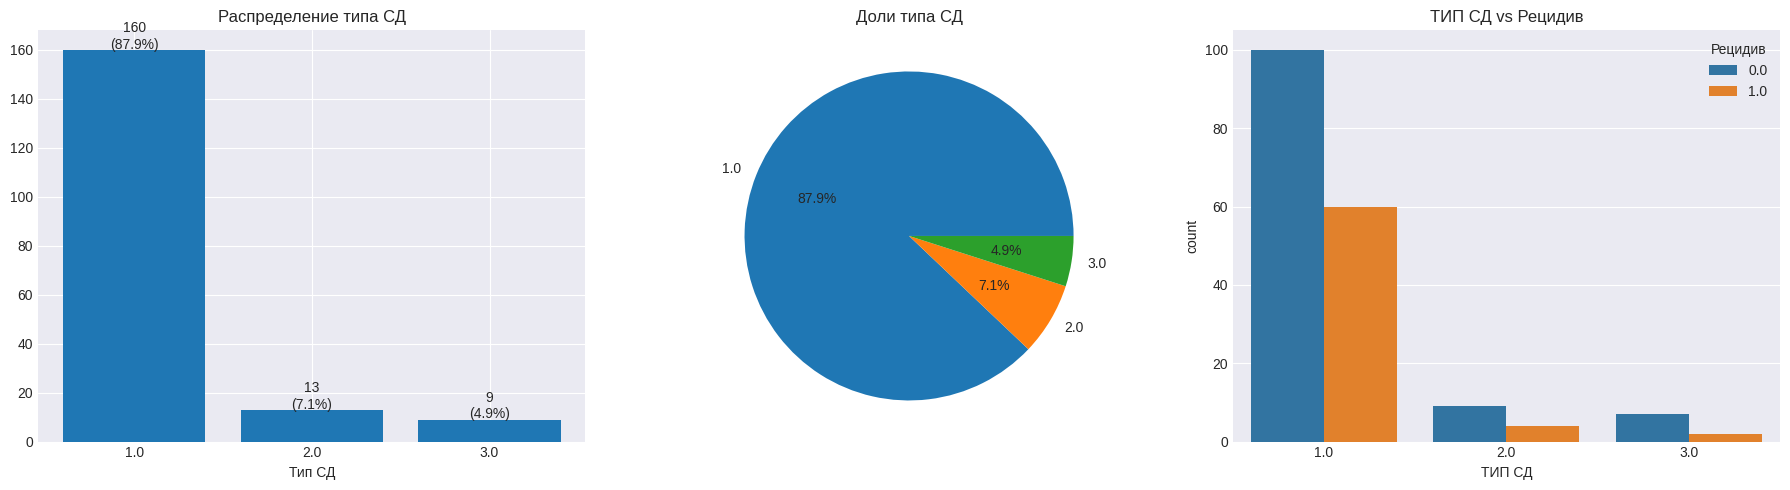

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Столбчатая диаграмма с процентами
total = len(data)
value_counts = data['тип СД (1-1, 2-2, 3 -др)'].value_counts()
bars = axes[0].bar(value_counts.index.astype(str), value_counts.values)
axes[0].set_title('Распределение типа СД')
axes[0].set_xlabel('Тип СД')

# Добавляем проценты
for bar, count in zip(bars, value_counts.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}\n({count/total*100:.1f}%)', ha='center')

# Круговая диаграмма
axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
axes[1].set_title('Доли типа СД')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x='тип СД (1-1, 2-2, 3 -др)',
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[2])
axes[2].set_title('ТИП СД vs Рецидив')
axes[2].set_xlabel('ТИП СД')
axes[2].legend(title='Рецидив')

plt.tight_layout()
plt.show()

In [ ]:
# Расчет процентов рецидива по типам СД
for sd_type in sorted(data['тип СД (1-1, 2-2, 3 -др)'].unique()):
    subset = data[data['тип СД (1-1, 2-2, 3 -др)'] == sd_type]
    total_count = len(subset)
    relapse_count = int(subset['Рецидив (0 - единичный, 1 - рецидив)'].sum())

    if total_count > 0:
        relapse_percent = relapse_count / total_count * 100
        print(f"Тип СД {int(sd_type)}: {relapse_count}/{total_count} = {relapse_percent:.1f}% рецидивов")
    else:
        print(f"Тип СД {int(sd_type)}: 0 пациентов")

Тип СД 1: 60/160 = 37.5% рецидивов
Тип СД 2: 4/13 = 30.8% рецидивов
Тип СД 3: 2/9 = 22.2% рецидивов


### 2 - Возраст (на текущий момент)

In [ ]:
### 2. Возраст (на текущий момент)
col = 'Возраст (на текущий момент)'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

Возраст (на текущий момент)
уник. значений: 46
тип: float64
кол-во пропусков: 0

Статистика:
count    182.000000
mean      34.857143
std       12.734927
min       18.000000
25%       24.250000
50%       34.000000
75%       43.000000
max       72.000000
Name: Возраст (на текущий момент), dtype: float64


Возраст (на текущий момент)
21.0    11
42.0     9
40.0     9
25.0     9
19.0     9
20.0     8
34.0     7
38.0     6
27.0     6
26.0     6
44.0     6
22.0     6
45.0     6
18.0     6
35.0     5
37.0     5
29.0     5
30.0     5
46.0     4
48.0     4
28.0     4
33.0     4
43.0     4
50.0     3
49.0     3
24.0     3
23.0     3
53.0     3
63.0     2
31.0     2
65.0     2
32.0     2
36.0     2
47.0     1
52.0     1
72.0     1
61.0     1
68.0     1
55.0     1
39.0     1
71.0     1
64.0     1
54.0     1
58.0     1
62.0     1
60.0     1
Name: count, dtype: int64

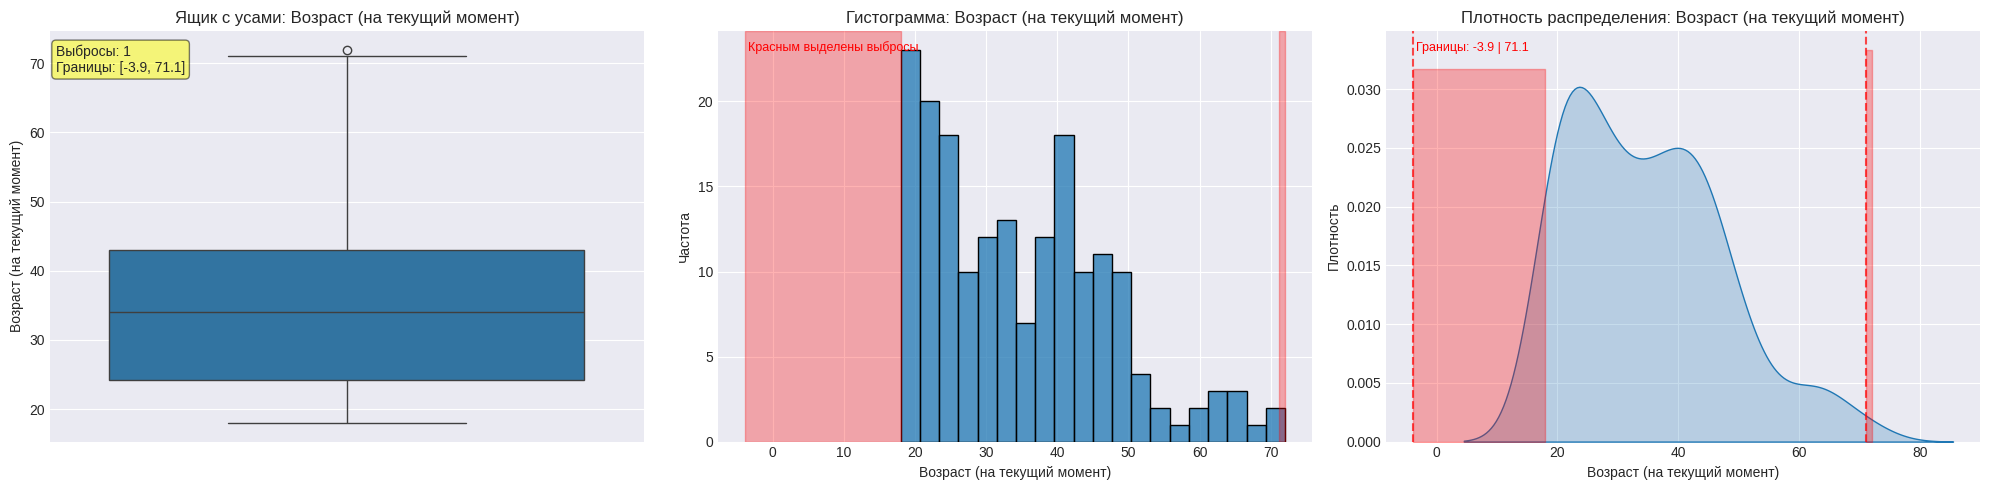

Выбросы: 1 из 182 (0.5%)
Границы выбросов: [-3.88, 71.12]


In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()


# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))


# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')


# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')


plt.tight_layout()
plt.show()


print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")


### 3 - Пол (0 - Ж, 1 - М)

Пол (0 - Ж, 1 - М)
1.0    98
0.0    84
Name: count, dtype: int64
уник. значений: 2
тип: float64
кол-во пропусков: 0


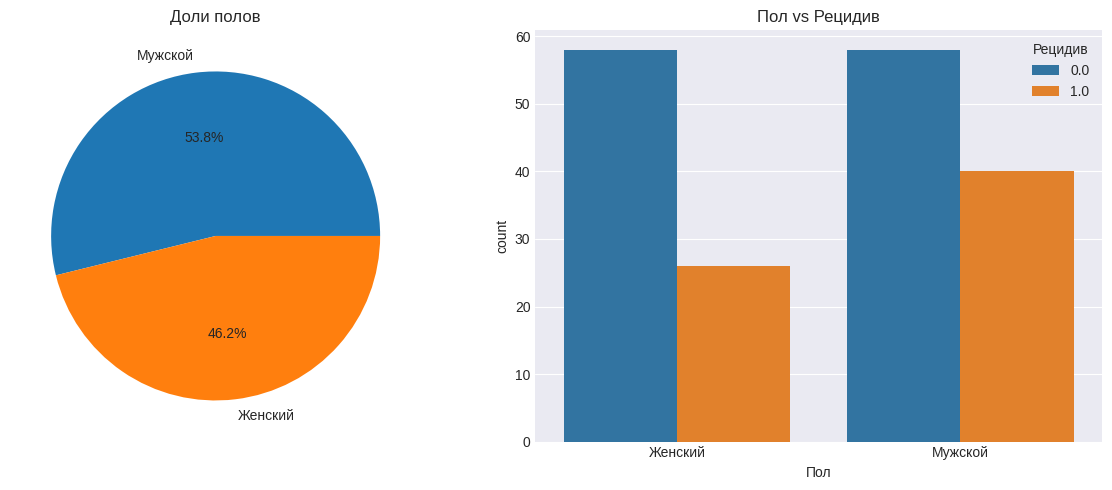

In [ ]:
## 3. Пол (0 - Ж, 1 - М)

col = 'Пол (0 - Ж, 1 - М)'
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Круговая диаграмма
value_counts = data[col].value_counts()
labels = ['Женский' if i == 0 else 'Мужской' for i in value_counts.index]
axes[0].pie(value_counts.values, labels=labels, autopct='%1.1f%%')
axes[0].set_title('Доли полов')

# Столбчатая диаграмма с таргетом
plot = sns.countplot(data=data,
                     x=col,
                     hue='Рецидив (0 - единичный, 1 - рецидив)',
                     ax=axes[1])
axes[1].set_title('Пол vs Рецидив')
axes[1].set_xlabel('Пол')
plot.set_xticks([0, 1])
plot.set_xticklabels(['Женский', 'Мужской'])
axes[1].legend(title='Рецидив')

plt.tight_layout()
plt.show()

Это булева колонка

In [ ]:
data['Пол (0 - Ж, 1 - М)'] = data['Пол (0 - Ж, 1 - М)'].astype(bool)

### 4 - Дата текущего ДКА

In [ ]:
## 4. Дата текущего ДКА
col = 'Дата текущего ДКА'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Дата текущего ДКА
уник. значений: 115
тип: object
кол-во пропусков: 0

Статистика:
count      182
unique     115
top       2024
freq        28
Name: Дата текущего ДКА, dtype: int64


Дата текущего ДКА
2024                   28
2025                   26
2022                    6
2023                    6
2019                    3
                       ..
2025-05-20 00:00:00     1
2022-12-29 00:00:00     1
2023-01-18 00:00:00     1
2022-11-01 00:00:00     1
2021-10-22 00:00:00     1
Name: count, Length: 115, dtype: int64

На мой взгляд, это не данные временного ряда, я бы удалил вовсе эту колонку, но, допустим, оставим только год, потому что больше половины данных маскируется  как год, а не отдельная дата.

In [ ]:
data['Дата текущего ДКА'] = pd.to_numeric(data['Дата текущего ДКА'].astype(str).str[:4])
data['Дата текущего ДКА']

0      2019.0
1      2019.0
2      2024.0
3      2024.0
4      2019.0
        ...  
190    2025.0
191    2022.0
192    2023.0
193    2022.0
194    2021.0
Name: Дата текущего ДКА, Length: 182, dtype: float64

In [ ]:
## Дата текущего ДКА
col = 'Дата текущего ДКА'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Дата текущего ДКА
уник. значений: 8
тип: float64
кол-во пропусков: 0

Статистика:
count     182.000000
mean     2012.280220
std       149.321092
min         9.000000
25%      2022.000000
50%      2024.000000
75%      2025.000000
max      2025.000000
Name: Дата текущего ДКА, dtype: float64


Дата текущего ДКА
2024.0    52
2025.0    49
2023.0    30
2022.0    24
2021.0    18
2020.0     5
2019.0     3
9.0        1
Name: count, dtype: int64

**УДАЛЯЕМ**

In [ ]:
data = data.drop('Дата текущего ДКА', axis=1)

### 5 - Длительность СД (лет)

In [ ]:
### 5. Длительность СД (лет)
col = 'Длительность СД (лет)'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

Длительность СД (лет)
уник. значений: 35
тип: object
кол-во пропусков: 5

Статистика:
count     177
unique     35
top        10
freq       15
Name: Длительность СД (лет), dtype: int64


Длительность СД (лет)
10            15
0             13
0 (дебют)     13
3             12
4             11
15            10
6              9
1              8
20             8
8              8
12             8
9              7
7              6
16             6
14             5
2              5
5              5
0(дебют)       4
19             3
18             3
26             2
17             2
36             2
13             1
1,5 месяц      1
0.1            1
25             1
22             1
49             1
0.2            1
21             1
37             1
0  (дебют)     1
11             1
30             1
Name: count, dtype: int64

Явно числовой формат, надо поменять, также запомнить, что **0 это ДЕБЮТ**, видимо впервые наблюдается по данному случаю в больнице или что-то в этом роде

In [ ]:
# Находим строки, которые содержат буквы
mask = data['Длительность СД (лет)'].dropna().astype(str).str.contains('[а-яА-Яa-zA-Z]', na=False)

data.loc[mask.index[mask], 'Длительность СД (лет)'] = '0'

data['Длительность СД (лет)'].value_counts()


Длительность СД (лет)
0      19
10     15
0      13
3      12
4      11
15     10
6       9
20      8
8       8
12      8
1       8
9       7
7       6
16      6
2       5
14      5
5       5
18      3
19      3
36      2
17      2
26      2
13      1
0.1     1
49      1
25      1
21      1
22      1
0.2     1
37      1
11      1
30      1
Name: count, dtype: int64

Пусть все будет в годах, так как у всех остальных месяцы не учитываются, то учитывать их у двух пациентов не вижу логичным


In [ ]:
data['Длительность СД (лет)'] = data['Длительность СД (лет)'].astype(float)
data.loc[data['Длительность СД (лет)'] < 1, 'Длительность СД (лет)'] = 0
data['Длительность СД (лет)'].value_counts()

Длительность СД (лет)
0.0     34
10.0    15
3.0     12
4.0     11
15.0    10
6.0      9
1.0      8
8.0      8
20.0     8
12.0     8
9.0      7
16.0     6
7.0      6
5.0      5
2.0      5
14.0     5
19.0     3
18.0     3
36.0     2
17.0     2
26.0     2
13.0     1
25.0     1
49.0     1
22.0     1
21.0     1
37.0     1
11.0     1
30.0     1
Name: count, dtype: int64

In [ ]:
### проверим мульиколлинеарность
data_copy = data.copy()
data_copy['Длительность СД (лет)'] = pd.to_numeric(data_copy['Длительность СД (лет)'], errors='coerce')
data_copy['check'] = data_copy['Длительность СД (лет)'] + data_copy['Возраст манифестации СД']
data_copy['check']

0      35.0
1      63.0
2      23.0
3      42.0
4      42.0
       ... 
190    40.0
191    21.0
192    63.0
193    37.0
194    60.0
Name: check, Length: 182, dtype: float64

In [ ]:
corr = data_copy['Возраст (на текущий момент)'].corr(data_copy['check'])
corr

np.float64(0.9896323850174834)

In [ ]:
data_copy[data_copy['check'] != data_copy['Возраст (на текущий момент)']]

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
2                        1.0                         24.0                True   
4                        1.0                         48.0               False   
5                        1.0                         37.0                True   
6                        1.0                         34.0               False   
7                        1.0                         46.0               False   
8                        2.0                         47.0                True   
9                        1.0                         21.0                True   
10                       1.0                         29.0               False   
14                       1.0                         44.0                True   
15                       1.0                         28.0               False   
17                       1.0                         27.0               False   
18                       1.0                         52.0                True   
19                       1.0                         31.0                True   
20                       2.0                         42.0                True   
21                       1.0                         38.0                True   
22                       2.0                         72.0               False   
23                       1.0                         37.0                True   
24                       1.0                         44.0                True   
42                       1.0                         34.0                True   
59                       1.0                         40.0               False   
61                       1.0                         45.0               False   
68                       1.0                         32.0                True   
76                       1.0                         45.0                True   
95                       1.0                         25.0               False   
112                      1.0                         37.0                True   
135                      1.0                         23.0               False   
147                      1.0                         45.0               False   
148                      1.0                         35.0                True   
149                      1.0                         32.0                True   
150                      1.0                         24.0               False   
151                      1.0                         25.0                True   
152                      1.0                         26.0               False   
154                      1.0                         20.0               False   
155                      1.0                         27.0                True   
156                      1.0                         46.0                True   
164                      1.0                         22.0                True   
165                      1.0                         20.0                True   
167                      3.0                         46.0                True   

     Длительность СД (лет)  Возраст манифестации СД  \
2                      0.0                     23.0   
4                     10.0                     32.0   
5                      0.0                     34.0   
6                      NaN                      NaN   
7                      0.0                     42.0   
8                      NaN                      NaN   
9                      4.0                     15.0   
10                    20.0                      8.0   
14                     0.0                     40.0   
15                    14.0                     13.0   
17                     7.0                     15.0   
18                     7.0                     42.0   
19                     1.0                     29.0   
20                     NaN                      NaN   
21                 

Это мультиколлинеарность, так как длительность сд - это сколько человек болеет диабетом, а возраст манифестации сд - это тот возраст, в котором диабет проявился, как болезнь, что в сумме даст возраст на текущий момент, есть некоторые несовпадения, пропуски или мб ошибки ввода, заполнения, не знаю точно, как лучше поступить

In [ ]:
data_copy = data_copy.dropna(subset=['Возраст манифестации СД'])
data_copy['Возраст манифестации СД'].isnull().sum()

np.int64(0)

In [ ]:
# 1.
corr_matrix = data_copy[['Возраст манифестации СД', 'Возраст (на текущий момент)']].corr()
print(corr_matrix)

# 2 VIF:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(data_copy[['Возраст манифестации СД', 'Возраст (на текущий момент)']].values, i)
              for i in range(2)]
vif['feature'] = ['Возраст манифестации СД', 'Возраст (на текущий момент)']
print(vif)

                             Возраст манифестации СД  \
Возраст манифестации СД                     1.000000   
Возраст (на текущий момент)                 0.788266   

                             Возраст (на текущий момент)  
Возраст манифестации СД                         0.788266  
Возраст (на текущий момент)                     1.000000  
         VIF                      feature
0  12.650346      Возраст манифестации СД
1  12.650346  Возраст (на текущий момент)


In [ ]:
## 5. Длительность СД (лет)
col = 'Длительность СД (лет)'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

Длительность СД (лет)
уник. значений: 29
тип: float64
кол-во пропусков: 5

Статистика:
count    177.000000
mean       8.728814
std        8.377792
min        0.000000
25%        2.000000
50%        7.000000
75%       14.000000
max       49.000000
Name: Длительность СД (лет), dtype: float64


Длительность СД (лет)
0.0     34
10.0    15
3.0     12
4.0     11
15.0    10
6.0      9
1.0      8
8.0      8
20.0     8
12.0     8
9.0      7
16.0     6
7.0      6
5.0      5
2.0      5
14.0     5
19.0     3
18.0     3
36.0     2
17.0     2
26.0     2
13.0     1
25.0     1
49.0     1
22.0     1
21.0     1
37.0     1
11.0     1
30.0     1
Name: count, dtype: int64

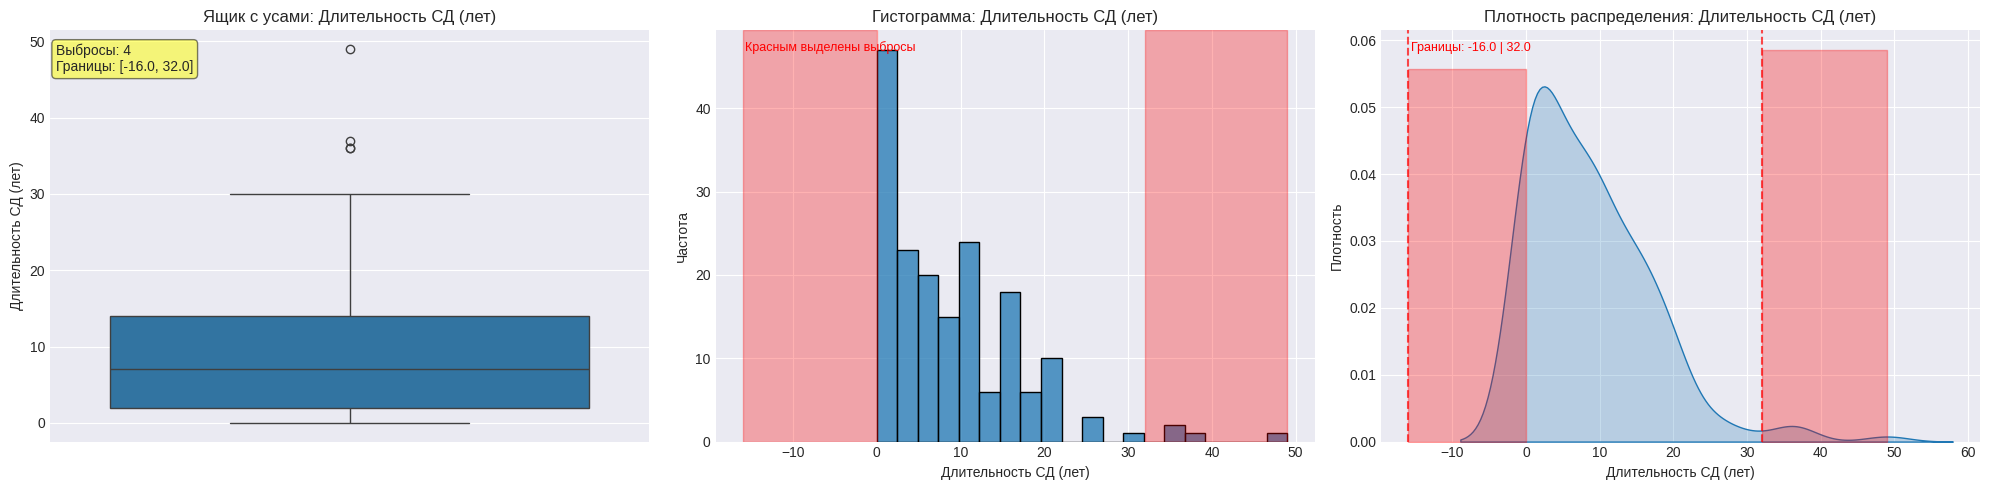

Выбросы: 4 из 182 (2.2%)
Границы выбросов: [-16.00, 32.00]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

In [ ]:
with pd.option_context('display.max_columns', None, 'display.width', None):
    nan_sd = data['Возраст манифестации СД'].isna()
    display(data[nan_sd])

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
6                        1.0                         34.0               False   
8                        2.0                         47.0                True   
20                       2.0                         42.0                True   
112                      1.0                         37.0                True   
155                      1.0                         27.0                True   

     Длительность СД (лет)  Возраст манифестации СД  \
6                      NaN                      NaN   
8                      NaN                      NaN   
20                     NaN                      NaN   
112                    NaN                      NaN   
155                    NaN                      NaN   

     Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
6                                                  1.0          
8                                                  1.0          
20                                                 1.0          
112                                                1.0          
155                                                1.0          

     Применение НМГ (0 - нет, 1 - да)  Суточная доза инсулина  \
6                                 0.0                    10.0   
8                                 0.0                     NaN   
20                                0.0                    34.0   
112                               0.0                    38.0   
155                               0.0                    74.0   

    Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)  \
6                                                   0   
8                                                   0   
20                                                  0   
112                                                 0   
155                                                 0   

     Количество эпизодов легких гипогликемий в неделю  \
6                                                 0.0   
8                                                 0.0   
20                                                0.0   
112                                               0.0   
155                                               0.0   

    Количество ДКА в анамнезе ХБП, С  ХБП, А  Невролог  \
6                           2      1     1.0       1.0   
8                           1      5     NaN       1.0   
20                          1      1     1.0       0.0   
112                         1    NaN     NaN       1.0   
155                         3      1     1.0       1.0   

     Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
6                                                  1.0                                           
8                                                  1.0                                           
20                                                 0.0                                           
112                                                0.0                                           
155                                                1.0                                           

     Целевой HbA1c  HbA1c  Креатинин при поступлении  \
6              7.5   13.5                       39.0   
8              7.0    NaN                      207.0   
20             6.5    NaN                      140.1   
112            6.5    NaN                       68.0   
155            6.5   10.9                      141.0   

     Мочевина при поступлении pH при поступлении ВЕ при поступлении  \
6                         8.0              7.157                NaN   
8                        13.6               7.04              -27.1   
20                       14.6                  7                -23   
112                       6.8                NaN                NaN   
155                       9.4                6.8                NaN   

    Лактат при п

Так я и полагал, в этих же строках три пропуска из колонки возраста манифестации, просто отсутствовали данные

### 6 - Возраст манифестации СД

In [ ]:
## 6. Возраст манифестации СД
col = 'Возраст манифестации СД'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Возраст манифестации СД
уник. значений: 48
тип: float64
кол-во пропусков: 5

Статистика:
count    177.000000
mean      25.638418
std       13.122859
min        3.000000
25%       15.000000
50%       24.000000
75%       36.000000
max       63.000000
Name: Возраст манифестации СД, dtype: float64


Возраст манифестации СД
39.0    9
15.0    8
19.0    7
34.0    7
18.0    7
13.0    7
30.0    6
17.0    6
12.0    6
33.0    6
42.0    6
4.0     6
40.0    5
31.0    5
22.0    5
23.0    5
11.0    5
48.0    5
24.0    4
36.0    4
10.0    4
29.0    4
35.0    3
20.0    3
25.0    3
16.0    3
14.0    3
21.0    3
9.0     3
38.0    3
8.0     2
32.0    2
37.0    2
41.0    2
27.0    2
47.0    2
6.0     2
28.0    2
52.0    1
57.0    1
7.0     1
3.0     1
49.0    1
56.0    1
44.0    1
58.0    1
5.0     1
63.0    1
Name: count, dtype: int64

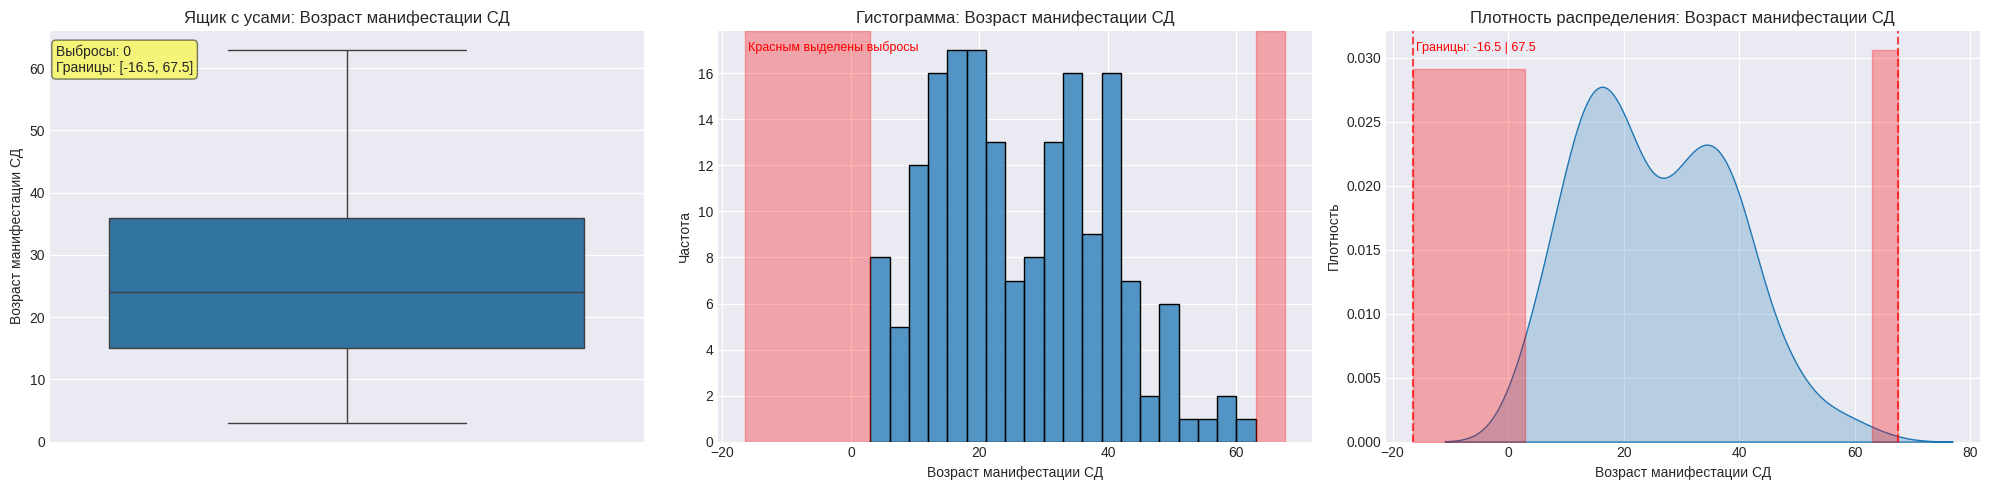

Выбросы: 0 из 182 (0.0%)
Границы выбросов: [-16.50, 67.50]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

**ПРОПУСКИ**

In [ ]:
data[data['Возраст манифестации СД'].isna()]

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
6                        1.0                         34.0               False   
8                        2.0                         47.0                True   
20                       2.0                         42.0                True   
112                      1.0                         37.0                True   
155                      1.0                         27.0                True   

     Длительность СД (лет)  Возраст манифестации СД  \
6                      NaN                      NaN   
8                      NaN                      NaN   
20                     NaN                      NaN   
112                    NaN                      NaN   
155                    NaN                      NaN   

     Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
6                                                  1.0          
8                                                  1.0          
20                                                 1.0          
112                                                1.0          
155                                                1.0          

     Применение НМГ (0 - нет, 1 - да)  Суточная доза инсулина  \
6                                 0.0                    10.0   
8                                 0.0                     NaN   
20                                0.0                    34.0   
112                               0.0                    38.0   
155                               0.0                    74.0   

    Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)  \
6                                                   0   
8                                                   0   
20                                                  0   
112                                                 0   
155                                                 0   

     Количество эпизодов легких гипогликемий в неделю  \
6                                                 0.0   
8                                                 0.0   
20                                                0.0   
112                                               0.0   
155                                               0.0   

    Количество ДКА в анамнезе ХБП, С  ХБП, А  Невролог  \
6                           2      1     1.0       1.0   
8                           1      5     NaN       1.0   
20                          1      1     1.0       0.0   
112                         1    NaN     NaN       1.0   
155                         3      1     1.0       1.0   

     Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
6                                                  1.0                                           
8                                                  1.0                                           
20                                                 0.0                                           
112                                                0.0                                           
155                                                1.0                                           

     Целевой HbA1c  HbA1c  Креатинин при поступлении  \
6              7.5   13.5                       39.0   
8              7.0    NaN                      207.0   
20             6.5    NaN                      140.1   
112            6.5    NaN                       68.0   
155            6.5   10.9                      141.0   

     Мочевина при поступлении pH при поступлении ВЕ при поступлении  \
6                         8.0              7.157                NaN   
8                        13.6               7.04              -27.1   
20                       14.6                  7                -23   
112                       6.8                NaN                NaN   
155                       9.4                6.8                NaN   

    Лактат при п

с учетом того, что мы знаем, как связаны возраст на текущий момент и колонки: длительность сд, возраст манифестации сд, мы можем заполнить медианой пропуски в манифестации, а в длительности заполним пропуски путем вычитания манифестации из возраста, чтобы получить логические значения

In [ ]:
# Заполняем манифестацию медианой
data['Возраст манифестации СД'] = data['Возраст манифестации СД'].fillna(
    data['Возраст манифестации СД'].median()
)

# Заполняем длительность по формуле
mask = data['Длительность СД (лет)'].isna()
data.loc[mask, 'Длительность СД (лет)'] = (
    data.loc[mask, 'Возраст (на текущий момент)'] -
    data.loc[mask, 'Возраст манифестации СД']
)

print(f"Осталось пропусков: Длительность={data['Длительность СД (лет)'].isna().sum()}")
print(f"Осталось пропусков: Манифестация={data['Возраст манифестации СД'].isna().sum()}")

Осталось пропусков: Длительность=0
Осталось пропусков: Манифестация=0


УДАЛЯЕМ ВОЗРАСТ МАНИФЕСТАЦИИ ИЗ_ЗА МУЛЬТИКОЛЛИНЕАРНОСТИ, по шапли анализу она менее важная


In [ ]:
data = data.drop('Возраст манифестации СД', axis=1)
data.columns

Index(['тип СД (1-1, 2-2, 3 -др)', 'Возраст (на текущий момент)',
       'Пол (0 - Ж, 1 - М)', 'Длительность СД (лет)',
       'Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА',
       'Применение НМГ (0 - нет, 1 - да)', 'Суточная доза инсулина',
       'Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)',
       'Количество эпизодов легких гипогликемий в неделю',
       'Количество ДКА в анамнезе', 'ХБП, С', 'ХБП, А', 'Невролог',
       'Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)',
       'Целевой HbA1c', 'HbA1c', 'Креатинин при поступлении',
       'Мочевина при поступлении', 'pH при поступлении', 'ВЕ при поступлении',
       'Лактат при поступлении', 'Глюкоза при поступлении', 'Общий холестерин',
       'ЛПНП', 'ЛПВП', 'ТГ', 'Степень тяжести ДКА',
       'Алкоголь за сутки до ДКА (0 - нет, 1 - да)',
       'Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)',
       'Рецидив (0 - единичный, 1 - рецидив)'],
      dtype='object')

### 7 - Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА

In [ ]:
### 7. Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА
col = 'Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА'
data[col] = data[col].astype('category')
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА
1.0    130
0.0     35
2.0     13
Name: count, dtype: int64
уник. значений: 3
тип: category
кол-во пропусков: 4


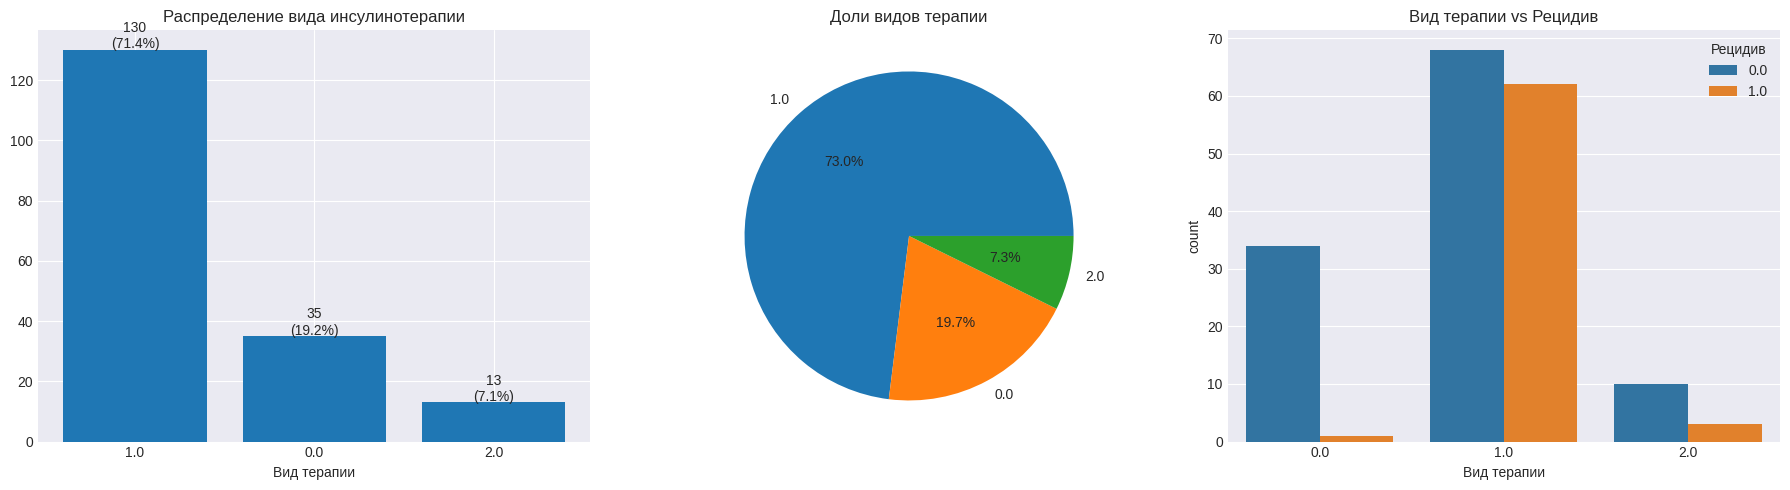

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Столбчатая диаграмма с процентами
total = len(data)
value_counts = data[col].value_counts()
bars = axes[0].bar(value_counts.index.astype(str), value_counts.values)
axes[0].set_title('Распределение вида инсулинотерапии')
axes[0].set_xlabel('Вид терапии')

# Добавляем проценты
for bar, count in zip(bars, value_counts.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}\n({count/total*100:.1f}%)', ha='center')

# Круговая диаграмма
axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
axes[1].set_title('Доли видов терапии')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x=col,
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[2])
axes[2].set_title('Вид терапии vs Рецидив')
axes[2].set_xlabel('Вид терапии')
axes[2].legend(title='Рецидив')

plt.tight_layout()
plt.show()

**Пропуски заполним самым популярным значением**

In [ ]:
popular_category = data[col].value_counts().index[0]
data[col] = data[col].fillna(popular_category)
data[col].isna().sum()

np.int64(0)

### 8 - Применение НМГ (0 - нет, 1 - да)

In [ ]:
### 8. Применение НМГ (0 - нет, 1 - да)

col = 'Применение НМГ (0 - нет, 1 - да)'
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


Применение НМГ (0 - нет, 1 - да)
0.0    175
1.0      7
Name: count, dtype: int64
уник. значений: 2
тип: float64
кол-во пропусков: 0


/tmp/ipython-input-2139324862.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Нет', 'Да'])


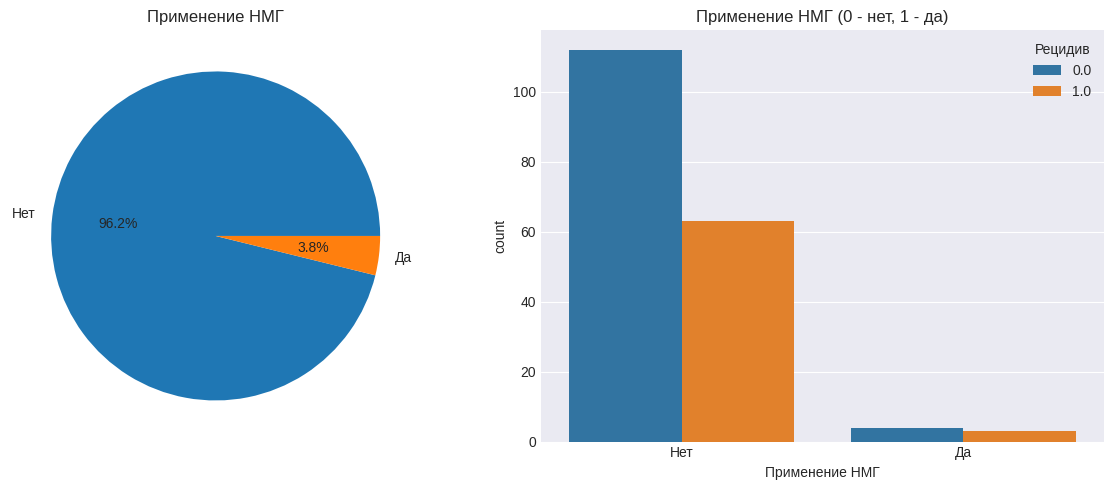

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Круговая диаграмма
value_counts = data[col].value_counts()
labels = ['Нет', 'Да']
axes[0].pie(value_counts.values, labels=labels, autopct='%1.1f%%')
axes[0].set_title('Применение НМГ')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x='Применение НМГ (0 - нет, 1 - да)',
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[1])
axes[1].set_title(col)
axes[1].set_xlabel('Применение НМГ')
axes[1].set_xticklabels(['Нет', 'Да'])
axes[1].legend(title='Рецидив')

plt.tight_layout()
plt.show()

**УДАЛЯЕМ**


In [ ]:
data = data.drop('Применение НМГ (0 - нет, 1 - да)', axis=1)

### 9 - Суточная доза инсулина

In [ ]:
### 9. Суточная доза инсулина

col = 'Суточная доза инсулина'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Суточная доза инсулина
уник. значений: 43
тип: float64
кол-во пропусков: 12

Статистика:
count    170.000000
mean      37.417647
std       21.149978
min        0.000000
25%       28.000000
50%       38.000000
75%       52.000000
max      118.000000
Name: Суточная доза инсулина, dtype: float64


Суточная доза инсулина
0.0      25
32.0     13
54.0     13
36.0     10
28.0      7
60.0      7
43.0      7
42.0      6
30.0      6
44.0      6
48.0      6
38.0      5
50.0      5
22.0      4
34.0      4
52.0      4
56.0      4
40.0      4
46.0      3
24.0      3
33.0      2
58.0      2
65.0      2
26.0      2
64.0      2
10.0      1
35.0      1
18.0      1
68.0      1
25.0      1
53.0      1
47.0      1
55.0      1
39.0      1
66.0      1
100.0     1
97.0      1
20.0      1
74.0      1
57.0      1
70.0      1
118.0     1
72.0      1
Name: count, dtype: int64

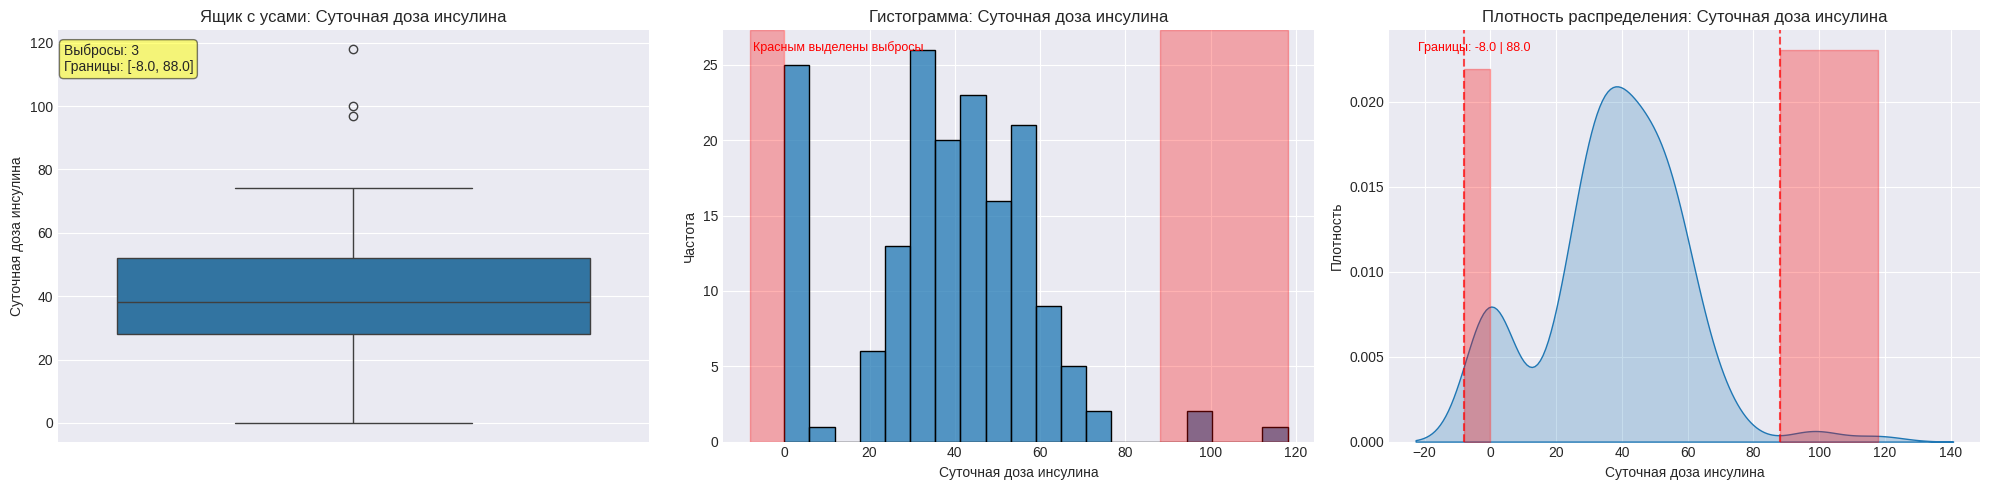

Выбросы: 3 из 182 (1.6%)
Границы выбросов: [-8.00, 88.00]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))


# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()


# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))


# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')


# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')


plt.tight_layout()
plt.show()


print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")


**РАБОТА С ПРОПУСКАМИ**

In [ ]:
pd.set_option('display.max_columns', None)
data[data['Суточная доза инсулина'].isna()].head(12)

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
0                        1.0                         35.0                True   
8                        2.0                         47.0                True   
16                       1.0                         53.0               False   
19                       1.0                         31.0                True   
84                       1.0                         18.0               False   
97                       1.0                         44.0                True   
124                      2.0                         50.0                True   
141                      1.0                         30.0               False   
145                      2.0                         42.0               False   
160                      1.0                         21.0               False   
190                      1.0                         40.0               False   
191                      1.0                         21.0               False   

     Длительность СД (лет)  \
0                      1.0   
8                     23.0   
16                    36.0   
19                     1.0   
84                     7.0   
97                     2.0   
124                    3.0   
141                   18.0   
145                   12.0   
160                   17.0   
190                   36.0   
191                   10.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
0                                                  1.0         
8                                                  1.0         
16                                                 2.0         
19                                                 0.0         
84                                                 1.0         
97                                                 1.0         
124                                                1.0         
141                                                2.0         
145                                                0.0         
160                                                2.0         
190                                                1.0         
191                                                1.0         

     Суточная доза инсулина Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)  \
0                       NaN                                                 0   
8                       NaN                                                 0   
16                      NaN                                                 0   
19                      NaN                                                 0   
84                      NaN                                                 0   
97                      NaN                                                 0   
124                     NaN                                                 0   
141                     NaN                                                 0   
145                     NaN                                                 0   
160                     NaN                                                 0   
190                     NaN                                                 0   
191                     NaN                                                 0   

     Количество эпизодов легких гипогликемий в неделю  \
0                                                 0.0   
8                                                 0.0   
16                                                0.0   
19                                                0.0   
84                                                0.0   
97                                                0.0   
124                                               0.0   
141                                               0.0   
145                                               0.0   
160                                               NaN   
190                                          

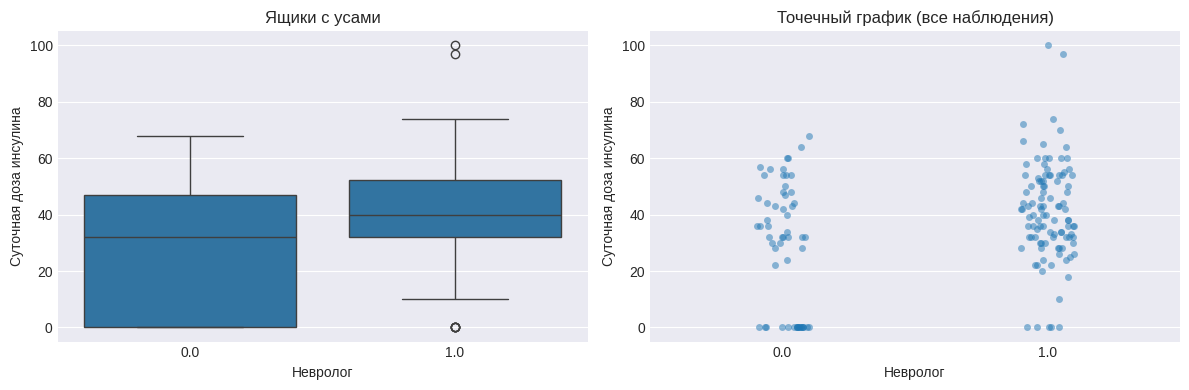

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(x='Невролог', y='Суточная доза инсулина', data=data, ax=ax1)
ax1.set_title('Ящики с усами')

sns.stripplot(x='Невролог', y='Суточная доза инсулина', data=data,
              ax=ax2, alpha=0.5, jitter=True)
ax2.set_title('Точечный график (все наблюдения)')

plt.tight_layout()
plt.show()

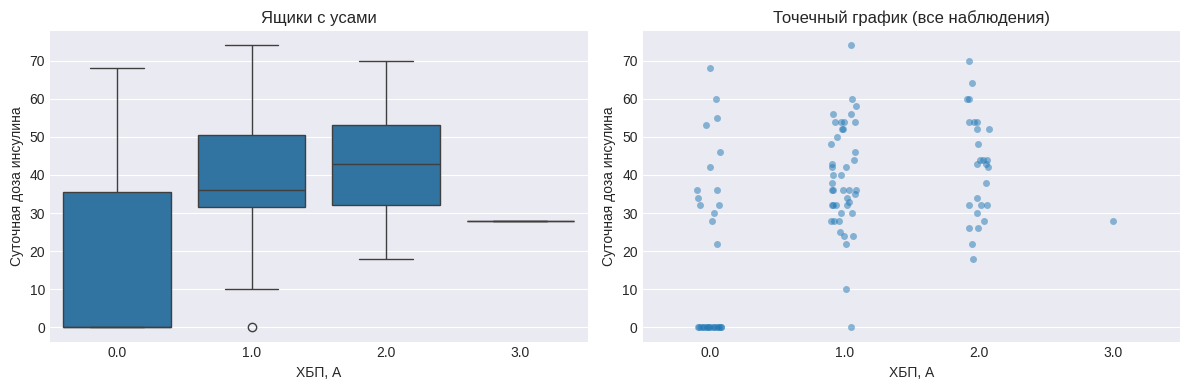

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(x='ХБП, А', y='Суточная доза инсулина', data=data, ax=ax1)
ax1.set_title('Ящики с усами')

sns.stripplot(x='ХБП, А', y='Суточная доза инсулина', data=data,
              ax=ax2, alpha=0.5, jitter=True)
ax2.set_title('Точечный график (все наблюдения)')

plt.tight_layout()
plt.show()

In [ ]:
# Заполняем пропуски медианами по группам ниже
data['Суточная доза инсулина'] = data['Суточная доза инсулина'].fillna(
    data.groupby('ХБП, А')['Суточная доза инсулина'].transform('median')
)

data['Суточная доза инсулина'] = data['Суточная доза инсулина'].fillna(
    data.groupby('Невролог')['Суточная доза инсулина'].transform('median')
)

data['Суточная доза инсулина'].isna().sum()


np.int64(0)

### 10 - Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)

In [ ]:
### 10. Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)

col = 'Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)'
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


Тяжелые гипогликемии в анамнезе (0 - нет, 1 - да)
0    179
1      3
Name: count, dtype: int64
уник. значений: 2
тип: object
кол-во пропусков: 0


квазиконстантный признак, удаляем

In [ ]:
data = data.drop(col, axis=1)

### 11 - Количество эпизодов легких гипогликемий в неделю

In [ ]:
### 11. Количество эпизодов легких гипогликемий в неделю

col = 'Количество эпизодов легких гипогликемий в неделю'
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


Количество эпизодов легких гипогликемий в неделю
0.0    160
Name: count, dtype: int64
уник. значений: 1
тип: float64
кол-во пропусков: 22


УДАЛЕНО из-за квазиконстантности

In [ ]:
data = data.drop(col, axis=1)

### 12 - Количество ДКА в анамнезе

In [ ]:
### 12. Количество ДКА в анамнезе

col = 'Количество ДКА в анамнезе'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Количество ДКА в анамнезе
уник. значений: 13
тип: object
кол-во пропусков: 1

Статистика:
count     181
unique     13
top         1
freq      102
Name: Количество ДКА в анамнезе, dtype: int64


Количество ДКА в анамнезе
1     102
2      32
3      17
0      14
4       8
10      1
6       1
5       1
11      1
13      1
9       1
7       1
/       1
Name: count, dtype: int64

In [ ]:
data[data[col]=='/']

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
181                      1.0                         20.0               False   

     Длительность СД (лет)  \
181                    5.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
181                                                1.0         

     Суточная доза инсулина Количество ДКА в анамнезе ХБП, С  ХБП, А  \
181                    42.0                         /    NaN     NaN   

     Невролог  \
181       NaN   

     Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
181                                                0.0                                           

     Целевой HbA1c  HbA1c  Креатинин при поступлении  \
181            6.5    NaN                       88.0   

     Мочевина при поступлении pH при поступлении ВЕ при поступлении  \
181                       3.3               6.98               28.3   

    Лактат при поступлении  Глюкоза при поступлении  Общий холестерин  ЛПНП  \
181                    NaN                    29.02              4.94  3.11   

     ЛПВП    ТГ  Степень тяжести ДКА  \
181  1.42  0.91                  3.0   

     Алкоголь за сутки до ДКА (0 - нет, 1 - да)  \
181                                         0.0   

     Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)  \
181                                               0.0   

     Рецидив (0 - единичный, 1 - рецидив)  
181                                   0.0

In [ ]:
data.loc[data[col] == '/', col] = 1

In [ ]:
data[data[col].isna()]

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
172                      1.0                         33.0                True   

     Длительность СД (лет)  \
172                   15.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
172                                                2.0         

     Суточная доза инсулина Количество ДКА в анамнезе ХБП, С  ХБП, А  \
172                    32.0                       NaN      1     2.0   

     Невролог  \
172       1.0   

     Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
172                                                1.0                                           

     Целевой HbA1c  HbA1c  Креатинин при поступлении  \
172            6.5   7.94                       83.0   

     Мочевина при поступлении pH при поступлении ВЕ при поступлении  \
172                       7.8               7.24               12.8   

    Лактат при поступлении  Глюкоза при поступлении  Общий холестерин  ЛПНП  \
172                    NaN                     35.6              4.38  2.28   

     ЛПВП    ТГ  Степень тяжести ДКА  \
172  1.52  1.28                  1.0   

     Алкоголь за сутки до ДКА (0 - нет, 1 - да)  \
172                                         0.0   

     Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)  \
172                                               0.0   

     Рецидив (0 - единичный, 1 - рецидив)  
172                                   0.0

In [ ]:
popular_category = data[col].value_counts().index[0]
data[col] = data[col].fillna(popular_category)

/tmp/ipython-input-3649179584.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].fillna(popular_category)


In [ ]:
### 12. Количество ДКА в анамнезе

col = 'Количество ДКА в анамнезе'
print(col)
data[col] = data[col].astype(int)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Количество ДКА в анамнезе
уник. значений: 12
тип: int64
кол-во пропусков: 0

Статистика:
count    182.000000
mean       1.714286
std        1.757608
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       13.000000
Name: Количество ДКА в анамнезе, dtype: float64


Количество ДКА в анамнезе
1     104
2      32
3      17
0      14
4       8
10      1
11      1
6       1
5       1
13      1
9       1
7       1
Name: count, dtype: int64

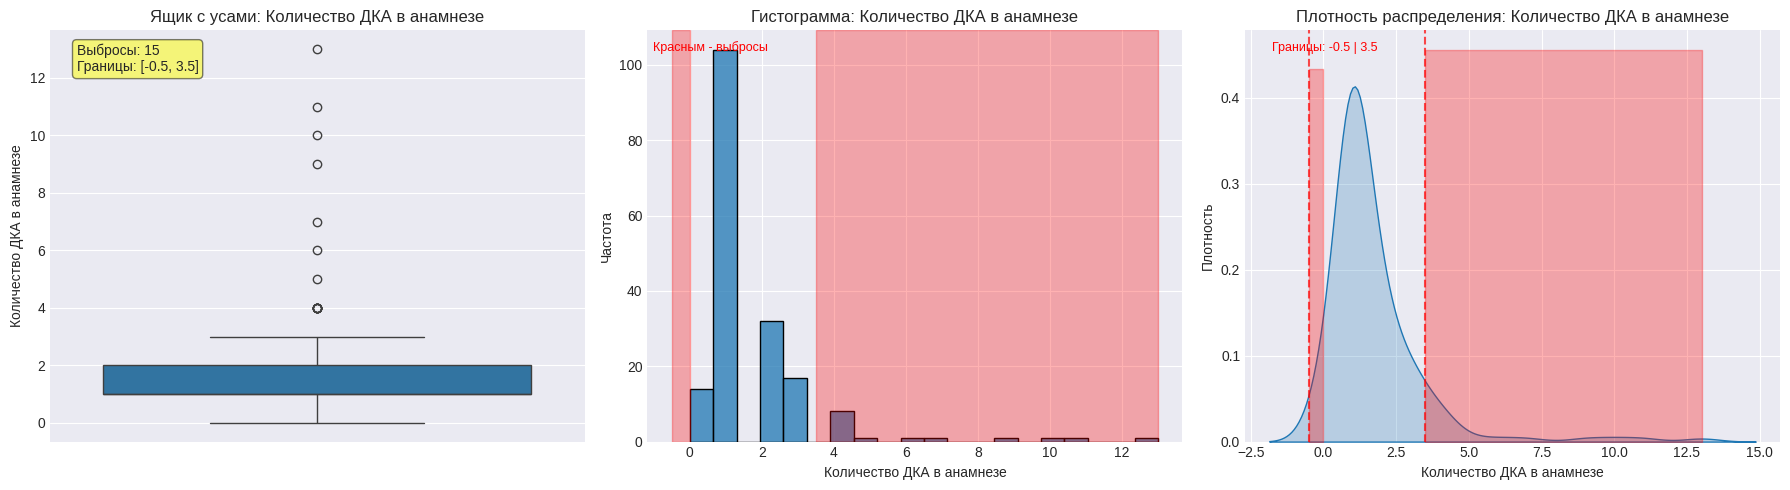

Выбросы: 15 из 182 (8.2%)
Границы выбросов: [-0.50, 3.50]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.05, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.01, 0.95, 'Красным - выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

### 13, 14- ХБП, С or A

In [ ]:
print('ХБП, С')
print(f'уник. значений: {data['ХБП, С'].nunique()}')
data['ХБП, С'] = data['ХБП, С'].astype('category')
print(f'тип: {data['ХБП, С'].dtype}')
print(f'кол-во пропусков: {data['ХБП, С'].isna().sum()}')

print('\nСтатистика:')
print(data['ХБП, С'].describe(include='object'))
data['ХБП, С'].value_counts()

ХБП, С
уник. значений: 8
тип: category
кол-во пропусков: 54

Статистика:
count     128
unique      8
top         1
freq       69
Name: ХБП, С, dtype: int64


ХБП, С
1     69
0     40
2     12
3      2
3а     2
4      1
5      1
3b     1
Name: count, dtype: int64

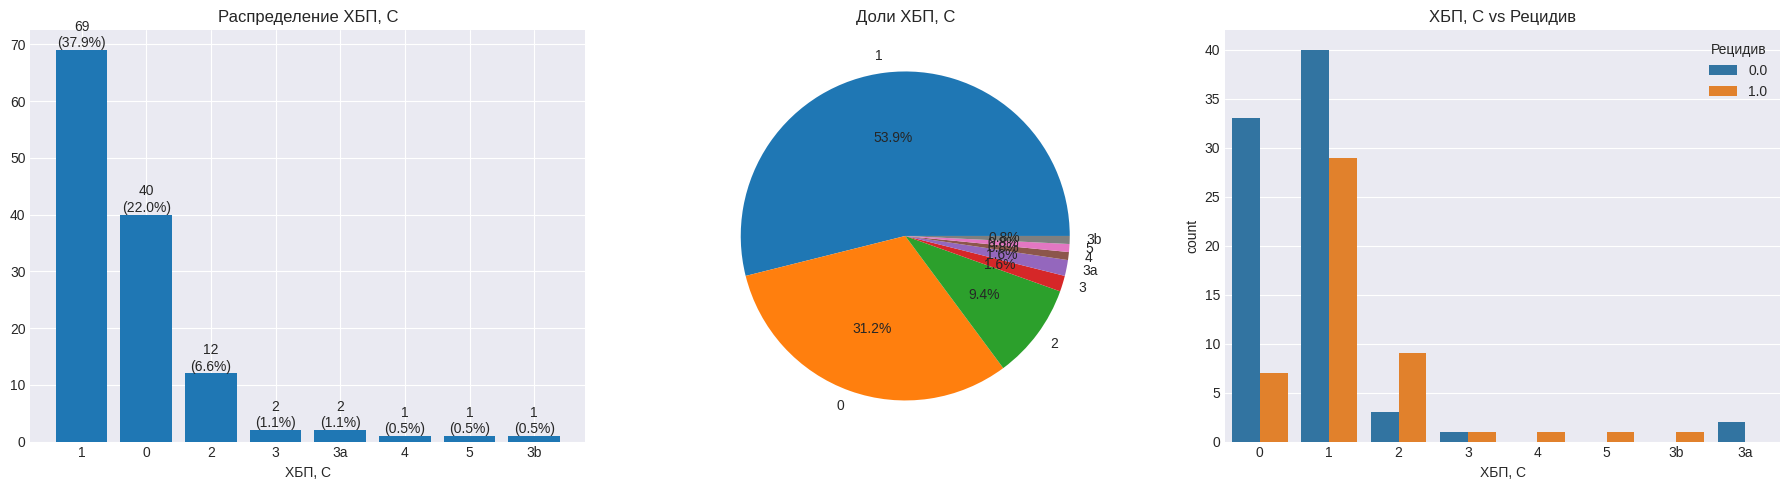

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Столбчатая диаграмма с процентами
total = len(data)
value_counts = data['ХБП, С'].value_counts()
bars = axes[0].bar(value_counts.index.astype(str), value_counts.values)
axes[0].set_title('Распределение ХБП, С')
axes[0].set_xlabel('ХБП, С')

# Добавляем проценты
for bar, count in zip(bars, value_counts.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}\n({count/total*100:.1f}%)', ha='center')

# Круговая диаграмма
axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
axes[1].set_title('Доли ХБП, С')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x='ХБП, С',
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[2])
axes[2].set_title('ХБП, С vs Рецидив')
axes[2].set_xlabel('ХБП, С')
axes[2].legend(title='Рецидив')

plt.tight_layout()
plt.show()

In [ ]:
print('ХБП, А')
print(f'уник. значений: {data['ХБП, А'].nunique()}')
data['ХБП, А'] = data['ХБП, А'].astype('category')
print(f'тип: {data['ХБП, А'].dtype}')
print(f'кол-во пропусков: {data['ХБП, А'].isna().sum()}')

print('\nСтатистика:')
print(data['ХБП, А'].describe(include='object'))
data['ХБП, А'].value_counts()

ХБП, А
уник. значений: 4
тип: category
кол-во пропусков: 71

Статистика:
count     111.0
unique      4.0
top         1.0
freq       47.0
Name: ХБП, А, dtype: float64


ХБП, А
1.0    47
0.0    34
2.0    28
3.0     2
Name: count, dtype: int64

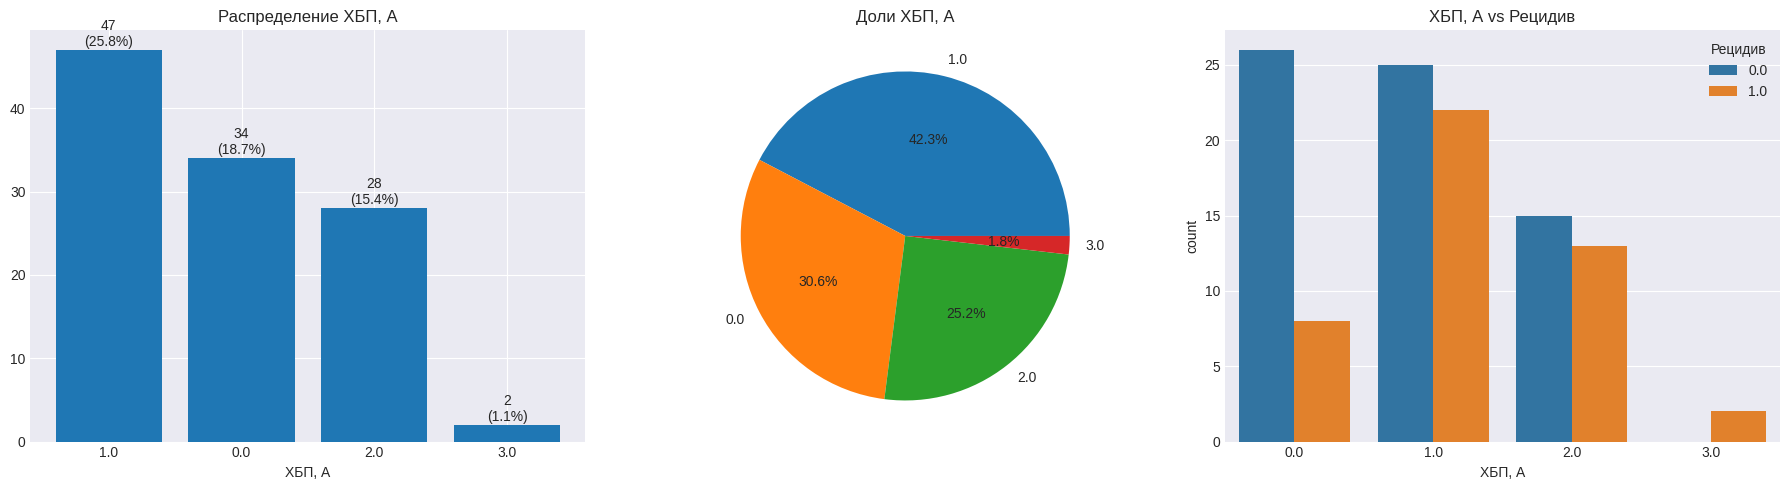

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Столбчатая диаграмма с процентами
total = len(data)
value_counts = data['ХБП, А'].value_counts()
bars = axes[0].bar(value_counts.index.astype(str), value_counts.values)
axes[0].set_title('Распределение ХБП, А')
axes[0].set_xlabel('ХБП, А')

# Добавляем проценты
for bar, count in zip(bars, value_counts.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}\n({count/total*100:.1f}%)', ha='center')

# Круговая диаграмма
axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
axes[1].set_title('Доли ХБП, А')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x='ХБП, А',
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[2])
axes[2].set_title('ХБП, А vs Рецидив')
axes[2].set_xlabel('ХБП, А')
axes[2].legend(title='Рецидив')

plt.tight_layout()
plt.show()

**РАБОТА С ПРОПУСКАМИ**

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    nan_ХБП = data[(data['ХБП, А'].isna()) | (data['ХБП, С'].isna())]
    display(nan_ХБП)

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
8                        2.0                         47.0                True   
17                       1.0                         27.0               False   
25                       1.0                         22.0                True   
26                       1.0                         44.0                True   
28                       1.0                         25.0               False   
31                       1.0                         38.0               False   
33                       1.0                         34.0               False   
34                       1.0                         48.0                True   
36                       1.0                         19.0                True   
39                       1.0                         19.0               False   
40                       1.0                         22.0                True   
41                       1.0                         28.0               False   
43                       1.0                         40.0               False   
45                       1.0                         20.0               False   
46                       1.0                         29.0                True   
47                       1.0                         33.0               False   
49                       1.0                         34.0               False   
50                       1.0                         49.0                True   
54                       1.0                         42.0               False   
55                       1.0                         21.0               False   
56                       1.0                         27.0               False   
61                       1.0                         45.0               False   
80                       1.0                         37.0                True   
92                       1.0                         46.0                True   
96                       1.0                         25.0                True   
101                      1.0                         40.0                True   
103                      1.0                         38.0               False   
109                      1.0                         43.0                True   
111                      1.0                         22.0               False   
112                      1.0                         37.0                True   
113                      1.0                         50.0                True   
114                      1.0                         19.0                True   
115                      1.0                         42.0                True   
122                      1.0                         19.0               False   
123                      1.0                         49.0               False   
125                      1.0                         34.0                True   
126                      1.0                         38.0                True   
127                      1.0                         45.0                True   
128                      1.0                         28.0                True   
129                      3.0                         36.0                True   
131                      1.0                         40.0                True   
132                      1.0                         21.0                True   
133                      1.0                         45.0               False   
134                      1.0                         39.0                True   
135                      1.0                         23.0               False   
136                      2.0                         40.0                True   
137                      2.0                         71.0               False   
138                      1.0                         18.0               False   
141                      1.0       

In [ ]:
from sklearn.feature_selection import f_classif

# ANOVA F-value для каждого числового признака
numeric_cols = data.select_dtypes(include=[np.number]).columns
f_values, p_values = f_classif(data[numeric_cols].fillna(data[numeric_cols].median()),
                                data['ХБП, А'].fillna(data['ХБП, А'].mode()[0]))

# Топ-10 по F-value
top10_idx = np.argsort(f_values)[-10:][::-1]
print("Топ-10 числовых признаков по связи с ХБП, А (ANOVA F-value):")
for idx in top10_idx:
    print(f"{numeric_cols[idx]:30} : F={f_values[idx]:.1f}, p={p_values[idx]:.4f}")

Топ-10 числовых признаков по связи с ХБП, А (ANOVA F-value):
Суточная доза инсулина         : F=15.2, p=0.0000
Невролог                       : F=8.3, p=0.0000
Количество ДКА в анамнезе      : F=3.3, p=0.0212
Мочевина при поступлении       : F=3.2, p=0.0236
Длительность СД (лет)          : F=2.8, p=0.0404
Рецидив (0 - единичный, 1 - рецидив) : F=2.4, p=0.0670
HbA1c                          : F=1.8, p=0.1419
Степень тяжести ДКА            : F=1.7, p=0.1698
Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная) : F=1.4, p=0.2420
Возраст (на текущий момент)    : F=1.4, p=0.2495


In [ ]:
for col in ['ХБП, С', 'ХБП, А']:
    print(f"\nЗаполняем колонку: {col}")
    print(f"Пропусков до: {data[col].isna().sum()}")

    # Заполняем по группе Невролог
    data[col] = data.groupby('Невролог')[col].transform(
        lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
    )

    # Заполняем общим mode
    if data[col].isna().any():
        if not data[col].mode().empty:
            data[col] = data[col].fillna(data[col].mode()[0])

    print(f"Пропусков после: {data[col].isna().sum()}")


Заполняем колонку: ХБП, С
Пропусков до: 54
Пропусков после: 0

Заполняем колонку: ХБП, А
Пропусков до: 71
Пропусков после: 0


### 15 - Невролог

Аналогично подозревал, что пропуски невролога последуют вместе с пропуском колонки про ретинопатию.

In [ ]:
with pd.option_context('display.max_columns', None, 'display.width', None):
    nan_neurolog = data['Невролог'].isna()
    display(data[nan_neurolog])

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
33                       1.0                         34.0               False   
40                       1.0                         22.0                True   
43                       1.0                         40.0               False   
114                      1.0                         19.0                True   
115                      1.0                         42.0                True   
128                      1.0                         28.0                True   
177                      1.0                         27.0                True   
181                      1.0                         20.0               False   
185                      1.0                         29.0               False   

     Длительность СД (лет)  \
33                     4.0   
40                    15.0   
43                     4.0   
114                    4.0   
115                    1.0   
128                    0.0   
177                    6.0   
181                    5.0   
185                    6.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
33                                                 1.0         
40                                                 1.0         
43                                                 1.0         
114                                                1.0         
115                                                1.0         
128                                                0.0         
177                                                1.0         
181                                                1.0         
185                                                1.0         

     Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  \
33                     54.0                          1      1    1.0   
40                     44.0                          3      1    1.0   
43                     65.0                          1      1    1.0   
114                    48.0                          1      1    1.0   
115                    54.0                          1      1    1.0   
128                     0.0                          1      1    1.0   
177                   118.0                          0      1    1.0   
181                    42.0                          1      1    1.0   
185                     0.0                          1      1    1.0   

     Невролог  \
33        NaN   
40        NaN   
43        NaN   
114       NaN   
115       NaN   
128       NaN   
177       NaN   
181       NaN   
185       NaN   

     Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
33                                                 NaN                                           
40                                                 NaN                                           
43                                                 NaN                                           
114                                                NaN                                           
115                                                NaN                                           
128                                                NaN                                           
177                                                NaN                                           
181                                                0.0                                           
185                                                NaN                                           

     Целевой HbA1c  HbA1c  Креатинин при поступлении  \
33             6.5    NaN                      144.0   
40             6.5    NaN                      177.0   
43             NaN    NaN                      115.0   
114            6.5    NaN                      123.2   
115            6.5    NaN                      111.0   
128            6.5    9.7                 

In [ ]:
### 15. Невролог
col = 'Невролог'
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

Невролог
1.0    111
0.0     62
Name: count, dtype: int64
уник. значений: 2
тип: float64
кол-во пропусков: 9


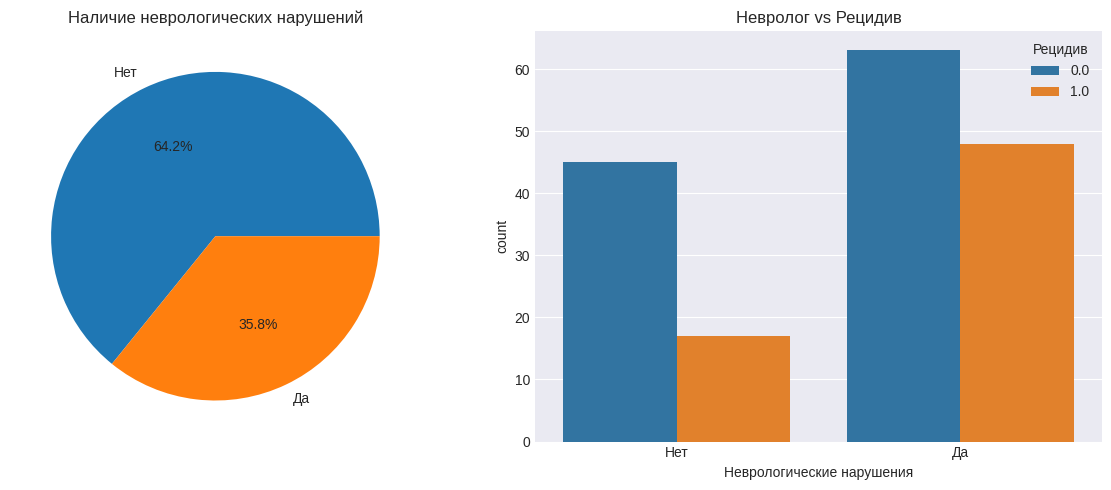

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Круговая диаграмма
value_counts = data['Невролог'].value_counts()
labels = ['Нет', 'Да']
axes[0].pie(value_counts.values, labels=labels, autopct='%1.1f%%')
axes[0].set_title('Наличие неврологических нарушений')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x='Невролог',
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[1])
axes[1].set_title('Невролог vs Рецидив')
axes[1].set_xlabel('Неврологические нарушения')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Нет', 'Да'])
axes[1].legend(title='Рецидив')

plt.tight_layout()
plt.show()

### 16 - Ретинопатия


In [ ]:
### 16. Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)
col = 'Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)'
data[col] = data[col].astype('category')

print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)
0.0    94
1.0    64
3.0     6
2.0     5
Name: count, dtype: int64
уник. значений: 4
тип: category
кол-во пропусков: 13


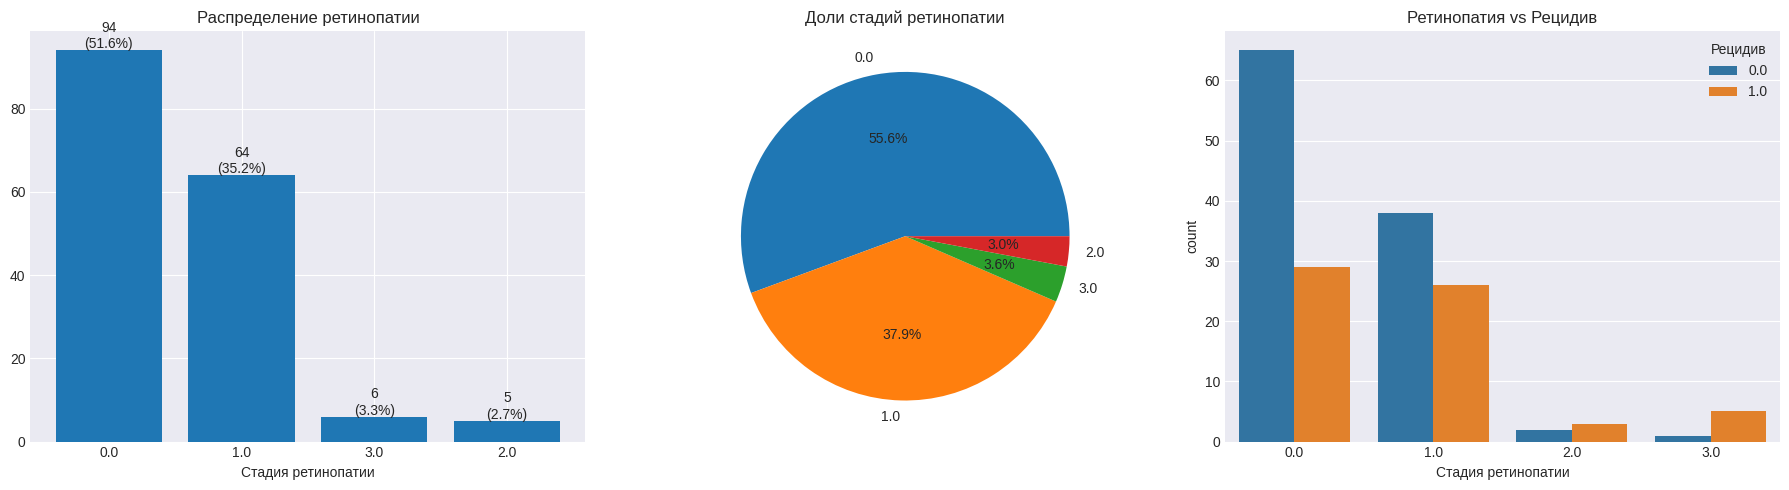

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Столбчатая диаграмма с процентами
total = len(data)
value_counts = data['Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)'].value_counts()
bars = axes[0].bar(value_counts.index.astype(str), value_counts.values)
axes[0].set_title('Распределение ретинопатии')
axes[0].set_xlabel('Стадия ретинопатии')

# Добавляем проценты
for bar, count in zip(bars, value_counts.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}\n({count/total*100:.1f}%)', ha='center')

# Круговая диаграмма
axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
axes[1].set_title('Доли стадий ретинопатии')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x='Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)',
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[2])
axes[2].set_title('Ретинопатия vs Рецидив')
axes[2].set_xlabel('Стадия ретинопатии')
axes[2].legend(title='Рецидив')

plt.tight_layout()
plt.show()

**РАБОТА С ПРОПУСКАМИ**

In [ ]:
### заполняем самым популярным значением
for col in ['Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)', 'Невролог']:
    data[col] = data[col].fillna(data[col].mode()[0])

### 17 - Целевой HbA1c

In [ ]:
### 17. Целевой HbA1c

col = 'Целевой HbA1c'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Целевой HbA1c
уник. значений: 3
тип: float64
кол-во пропусков: 2

Статистика:
count    180.000000
mean       6.644444
std        0.301249
min        6.500000
25%        6.500000
50%        6.500000
75%        6.500000
max        7.500000
Name: Целевой HbA1c, dtype: float64


Целевой HbA1c
6.5    142
7.0     24
7.5     14
Name: count, dtype: int64

In [ ]:
data[data['Целевой HbA1c'].isna()]

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
37                      1.0                         65.0                True   
43                      1.0                         40.0               False   

    Длительность СД (лет)  \
37                   26.0   
43                    4.0   

   Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
37                                                1.0         
43                                                1.0         

    Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  Невролог  \
37                    54.0                          1      3    2.0       1.0   
43                    65.0                          1      1    1.0       1.0   

   Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
37                                                1.0                                          
43                                                0.0                                          

    Целевой HbA1c  HbA1c  Креатинин при поступлении  Мочевина при поступлении  \
37            NaN    NaN                      237.0                      15.9   
43            NaN    NaN                      115.0                       9.8   

   pH при поступлении ВЕ при поступлении Лактат при поступлении  \
37               7.05              -27.5                    4.9   
43                6.9              -27.9                    2.7   

    Глюкоза при поступлении  Общий холестерин  ЛПНП  ЛПВП    ТГ  \
37                     38.6              4.52   1.9  2.05  1.26   
43                     39.5               NaN   NaN   NaN   NaN   

    Степень тяжести ДКА  Алкоголь за сутки до ДКА (0 - нет, 1 - да)  \
37                  3.0                                         0.0   
43                  NaN                                         1.0   

    Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)  \
37                                               0.0   
43                                               0.0   

    Рецидив (0 - единичный, 1 - рецидив)  
37                                   0.0  
43                                   0.0

УДАЛИТЬ!

In [ ]:
data = data.drop(col, axis=1)

### 18 - HbA1c

In [ ]:
### 18. HbA1c

col = 'HbA1c'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

HbA1c
уник. значений: 67
тип: float64
кол-во пропусков: 102

Статистика:
count    80.000000
mean     11.989750
std       3.124775
min       7.040000
25%       9.675000
50%      11.910000
75%      13.525000
max      29.910000
Name: HbA1c, dtype: float64


HbA1c
9.20     4
14.50    2
13.50    2
10.90    2
14.80    2
        ..
7.94     1
12.62    1
14.13    1
11.40    1
11.88    1
Name: count, Length: 67, dtype: int64

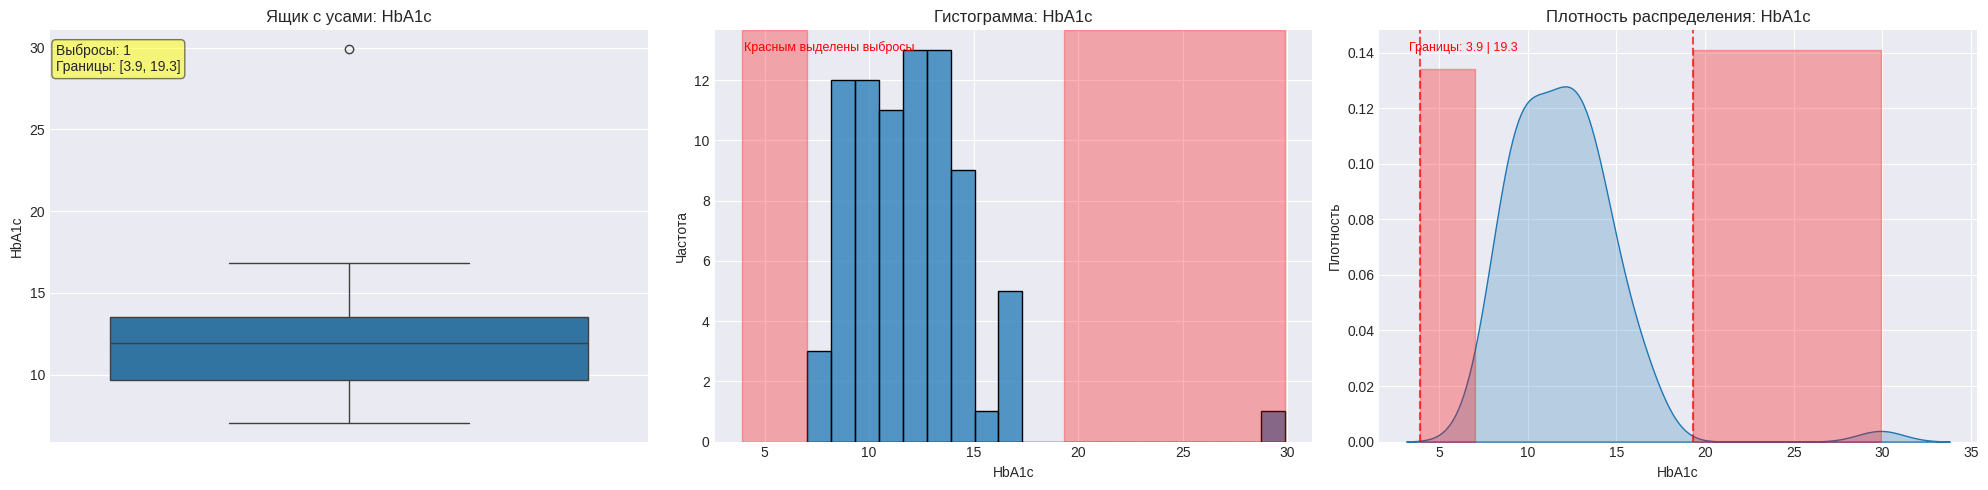

Выбросы: 1 из 182 (0.5%)
Границы выбросов: [3.90, 19.30]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

In [ ]:
### посмотрим на топ 10 корреляций с HbA1c
print(data.select_dtypes(include=[np.number]).corr()[col].sort_values(key=abs, ascending=False).head(11).iloc[1:])

ЛПВП                                         -0.398500
Рецидив (0 - единичный, 1 - рецидив)         -0.269473
Алкоголь за сутки до ДКА (0 - нет, 1 - да)   -0.267825
Длительность СД (лет)                        -0.259546
ТГ                                            0.201835
Мочевина при поступлении                     -0.199573
Степень тяжести ДКА                          -0.170769
Количество ДКА в анамнезе                    -0.141328
Суточная доза инсулина                       -0.138744
Возраст (на текущий момент)                  -0.134834
Name: HbA1c, dtype: float64


**Работа с пропусками**

In [ ]:
### 2 ВАРИАНТ - ОСТАВЛЯЕМ ДФ ТОЛЬКО С ЗАПОЛНЕННЫМИ HbA1C

### 19 - Креатинин при поступлении

In [ ]:
### 19. Креатинин при поступлении

col = 'Креатинин при поступлении'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Креатинин при поступлении
уник. значений: 118
тип: float64
кол-во пропусков: 24

Статистика:
count    158.000000
mean     119.712025
std       56.408286
min       29.000000
25%       77.125000
50%      109.500000
75%      146.000000
max      338.000000
Name: Креатинин при поступлении, dtype: float64


Креатинин при поступлении
59.0     3
105.0    3
183.0    3
114.0    3
132.0    2
        ..
91.1     1
40.0     1
64.0     1
338.0    1
129.0    1
Name: count, Length: 118, dtype: int64

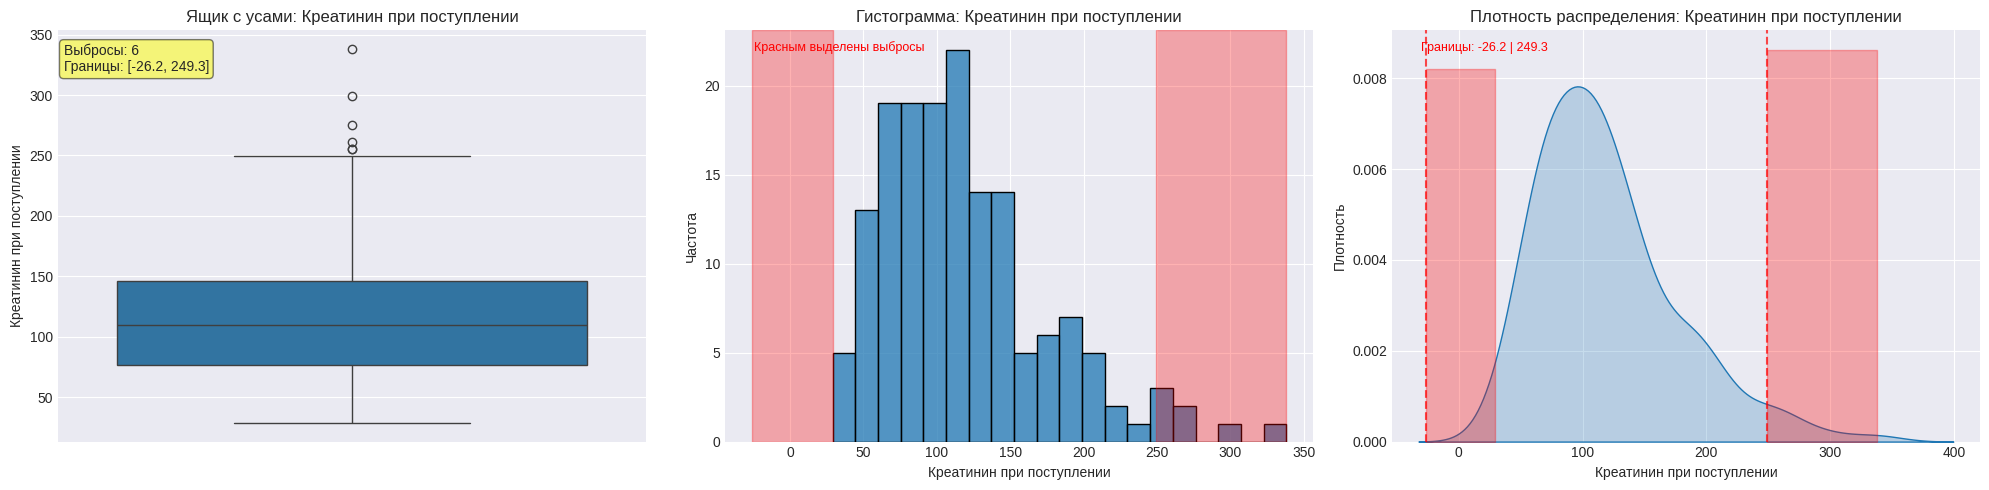

Выбросы: 6 из 182 (3.3%)
Границы выбросов: [-26.19, 249.31]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

In [ ]:
### посмотрим на топ 10 корреляций с этой колонкой
print(data.select_dtypes(include=[np.number]).corr()['Креатинин при поступлении'].sort_values(key=abs, ascending=False).head(11).iloc[1:])

Мочевина при поступлении                            0.673949
Глюкоза при поступлении                             0.648434
Возраст (на текущий момент)                         0.327386
Степень тяжести ДКА                                 0.324480
ТГ                                                  0.285559
Алкоголь за сутки до ДКА (0 - нет, 1 - да)          0.191576
Общий холестерин                                    0.176542
Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)    0.119585
Рецидив (0 - единичный, 1 - рецидив)                0.112112
HbA1c                                              -0.083551
Name: Креатинин при поступлении, dtype: float64


Заполним пропуски в конце 21 пункта

### 20 - Мочевина при поступлениии

In [ ]:
### 20. Мочевина при поступлении
col = 'Мочевина при поступлении'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

Мочевина при поступлении
уник. значений: 103
тип: float64
кол-во пропусков: 29

Статистика:
count    153.000000
mean       8.650915
std        4.538157
min        0.500000
25%        5.600000
50%        7.600000
75%       10.700000
max       24.500000
Name: Мочевина при поступлении, dtype: float64


Мочевина при поступлении
5.70     4
3.90     3
9.40     3
10.70    3
9.80     3
        ..
3.30     1
9.90     1
4.06     1
15.70    1
16.10    1
Name: count, Length: 103, dtype: int64

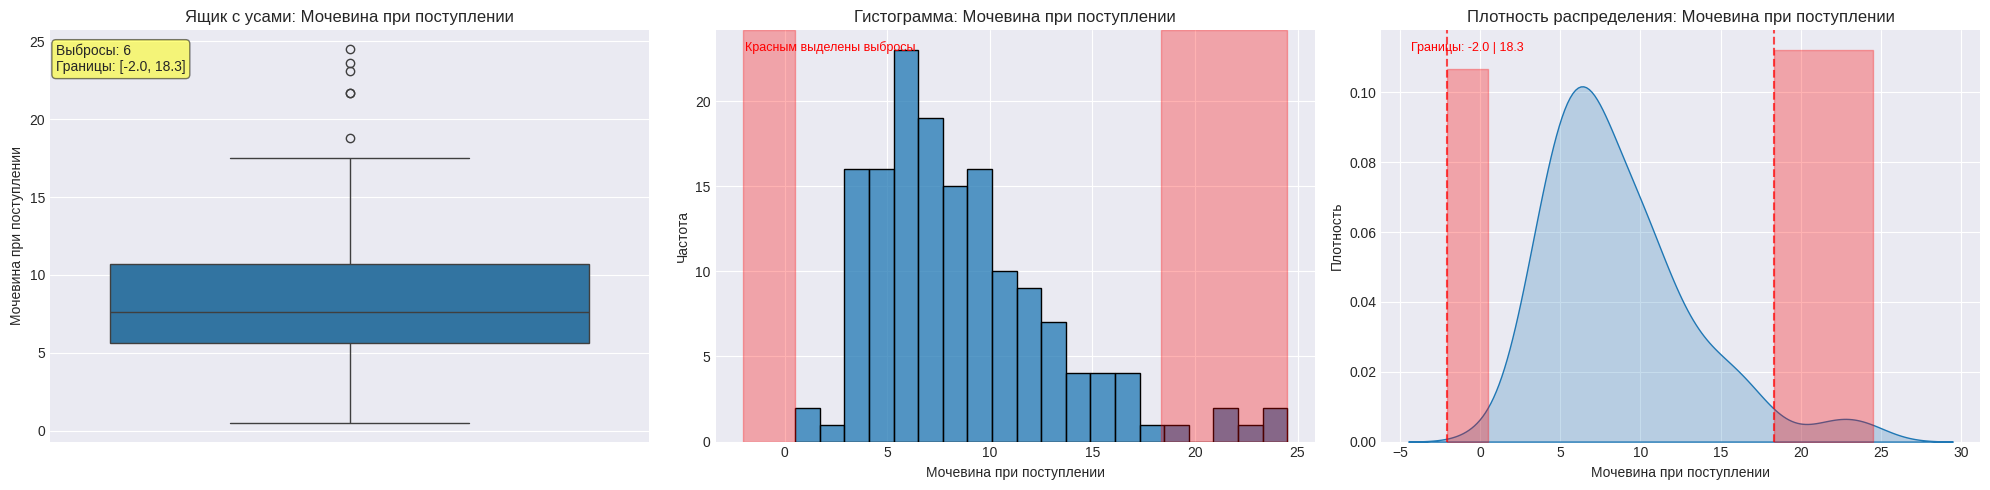

Выбросы: 6 из 182 (3.3%)
Границы выбросов: [-2.05, 18.35]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

Заполним пропуски в конце 21 пункта

### 21 - pH при поступлении

In [ ]:
# Проверяем
unique_vals = data[col].dropna().astype(str).unique()
for val in sorted(unique_vals):
    print(f"'{val}'")

'0.5'
'1.2'
'10.0'
'10.2'
'10.3'
'10.4'
'10.7'
'10.9'
'11.1'
'11.4'
'11.6'
'11.7'
'11.8'
'12.3'
'12.4'
'12.5'
'12.6'
'13.28'
'13.3'
'13.4'
'13.6'
'14.2'
'14.3'
'14.4'
'14.6'
'15.5'
'15.7'
'15.9'
'16.1'
'16.3'
'16.8'
'17.2'
'17.5'
'18.8'
'2.7'
'2.9'
'21.7'
'23.09'
'23.6'
'24.5'
'3.0'
'3.3'
'3.34'
'3.4'
'3.5'
'3.6'
'3.7'
'3.8'
'3.9'
'4.0'
'4.06'
'4.2'
'4.35'
'4.4'
'4.5'
'4.7'
'4.9'
'5.0'
'5.1'
'5.2'
'5.4'
'5.5'
'5.6'
'5.7'
'5.8'
'5.9'
'6.0'
'6.08'
'6.1'
'6.2'
'6.3'
'6.36'
'6.4'
'6.41'
'6.6'
'6.7'
'6.8'
'6.9'
'7.0'
'7.1'
'7.2'
'7.3'
'7.4'
'7.5'
'7.6'
'7.7'
'7.8'
'7.82'
'8.0'
'8.1'
'8.2'
'8.4'
'8.6'
'8.8'
'9.1'
'9.2'
'9.3'
'9.4'
'9.5'
'9.6'
'9.7'
'9.8'
'9.9'


In [ ]:
### 21. pH при поступлении
col = 'pH при поступлении'
print(col)
data[col] = data[col].replace(' ', np.nan)
data[col] = data[col].astype('float')
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

pH при поступлении
уник. значений: 59
тип: float64
кол-во пропусков: 34

Статистика:
count    148.000000
mean       7.435649
std        5.014784
min        6.700000
25%        6.900000
50%        7.005000
75%        7.172500
max       68.000000
Name: pH при поступлении, dtype: float64


/tmp/ipython-input-2227050939.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace(' ', np.nan)


pH при поступлении
6.800     20
6.900     17
7.000     14
7.200     11
7.100      9
7.280      3
7.040      3
6.940      3
7.240      3
7.230      3
6.870      3
7.250      3
7.157      2
6.930      2
7.130      2
7.300      2
7.090      2
7.010      2
7.050      2
7.020      2
6.960      2
6.970      1
6.994      1
7.120      1
7.350      1
7.015      1
7.106      1
7.400      1
7.270      1
7.080      1
6.720      1
7.066      1
7.143      1
7.195      1
7.070      1
6.860      1
7.170      1
7.104      1
6.950      1
6.920      1
7.150      1
6.830      1
7.220      1
7.190      1
7.180      1
7.260      1
6.840      1
68.000     1
7.193      1
7.092      1
6.700      1
7.077      1
7.140      1
6.890      1
7.210      1
6.817      1
7.223      1
6.980      1
6.737      1
Name: count, dtype: int64

In [ ]:
data.loc[data['pH при поступлении'] == 68, 'pH при поступлении'] = 6.8

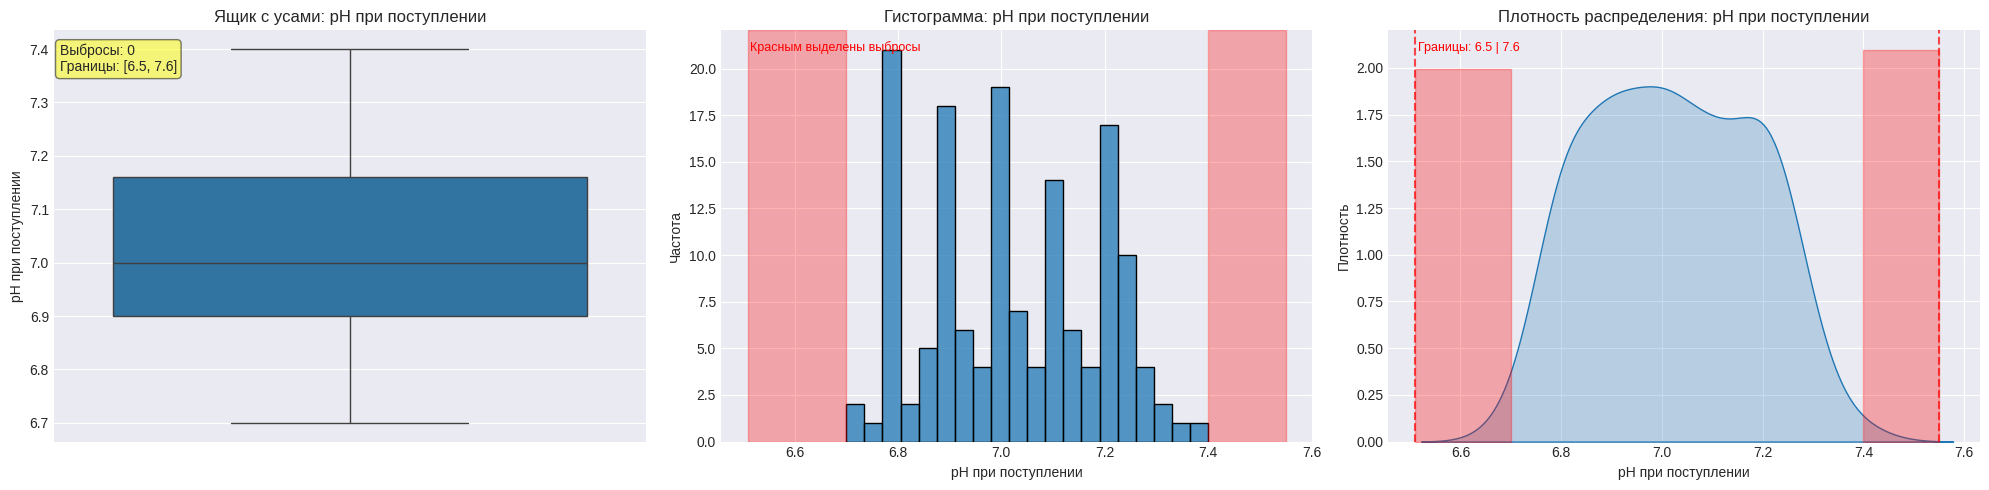

Выбросы: 0 из 182 (0.0%)
Границы выбросов: [6.51, 7.55]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

### 22 - ВЕ при поступлении

In [ ]:
### 22. ВЕ при поступлении
col = 'ВЕ при поступлении'
print(col)
print(f'уник. значений: {data[col].nunique()}')
data[col] = data[col].replace(' ', np.nan)
data[col] = data[col].astype('float')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

ВЕ при поступлении
уник. значений: 106
тип: float64
кол-во пропусков: 55

Статистика:
count    127.000000
mean     -13.211811
std       18.465634
min      -33.400000
25%      -25.950000
50%      -20.500000
75%       -8.550000
max       28.800000
Name: ВЕ при поступлении, dtype: float64


/tmp/ipython-input-3056331983.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace(' ', np.nan)


ВЕ при поступлении
-27.0    3
-19.0    3
-26.7    3
-25.7    3
-27.5    3
        ..
 28.8    1
-13.6    1
-29.2    1
-6.8     1
-17.9    1
Name: count, Length: 105, dtype: int64

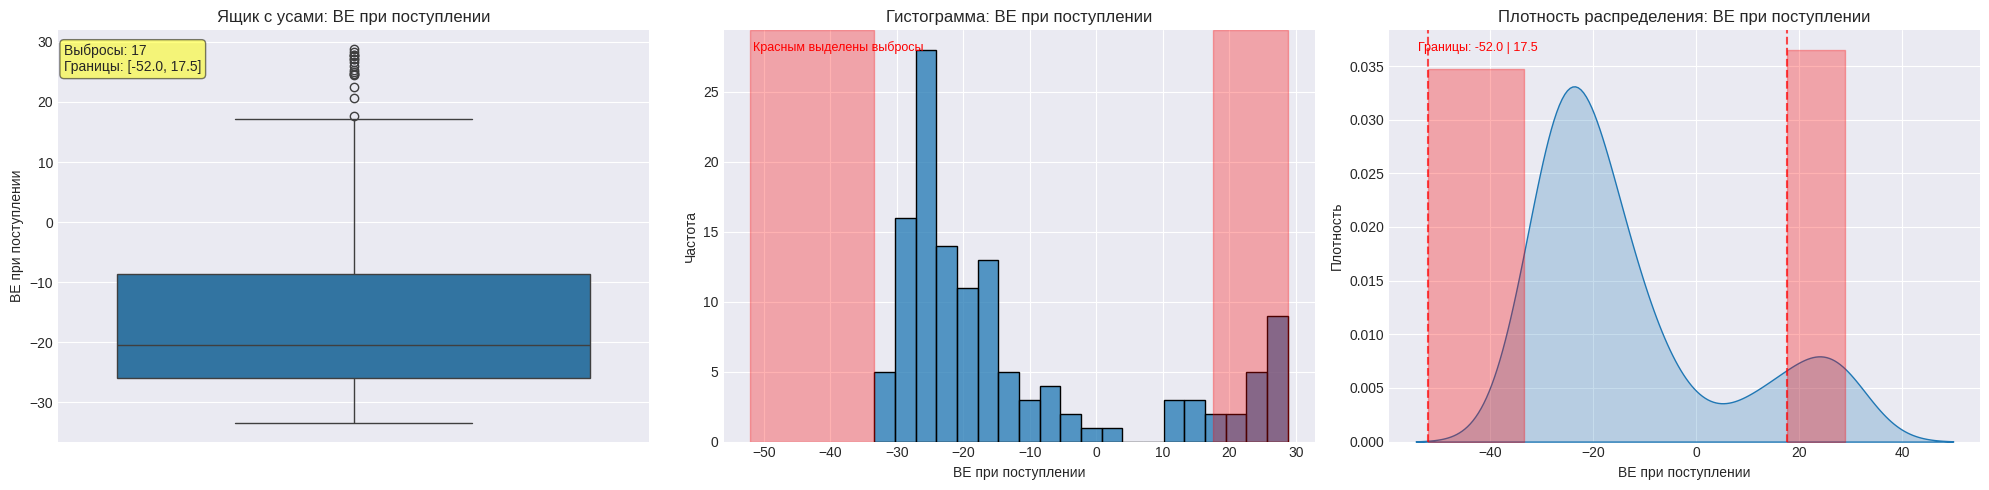

Выбросы: 17 из 182 (9.3%)
Границы выбросов: [-52.05, 17.55]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

Заполним пропуски в конце 21 пункта

### 23 - Лактат при поступлении

In [ ]:
### 23. Лактат при поступлении

col = 'Лактат при поступлении'
print(col)
data[col] = data[col].replace(' ', np.nan)
data[col] = data[col].astype('float')
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Лактат при поступлении
уник. значений: 52
тип: float64
кол-во пропусков: 89

Статистика:
count    93.000000
mean      3.026882
std       2.163790
min       0.600000
25%       1.500000
50%       2.500000
75%       3.700000
max      11.700000
Name: Лактат при поступлении, dtype: float64


/tmp/ipython-input-3609724448.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace(' ', np.nan)


Лактат при поступлении
1.3     6
1.5     6
1.6     4
1.2     4
2.4     3
3.3     3
3.1     3
3.2     3
4.3     3
1.0     3
2.7     2
1.9     2
1.4     2
1.8     2
4.8     2
2.5     2
2.6     2
3.6     2
2.0     2
1.1     2
3.5     2
0.8     2
2.3     2
4.1     1
0.9     1
4.0     1
6.6     1
0.7     1
2.2     1
8.3     1
4.9     1
2.8     1
2.1     1
6.7     1
11.7    1
5.1     1
3.4     1
5.7     1
10.3    1
3.0     1
8.2     1
0.6     1
4.4     1
3.7     1
9.1     1
6.0     1
3.9     1
5.6     1
1.7     1
7.2     1
2.9     1
3.8     1
Name: count, dtype: int64

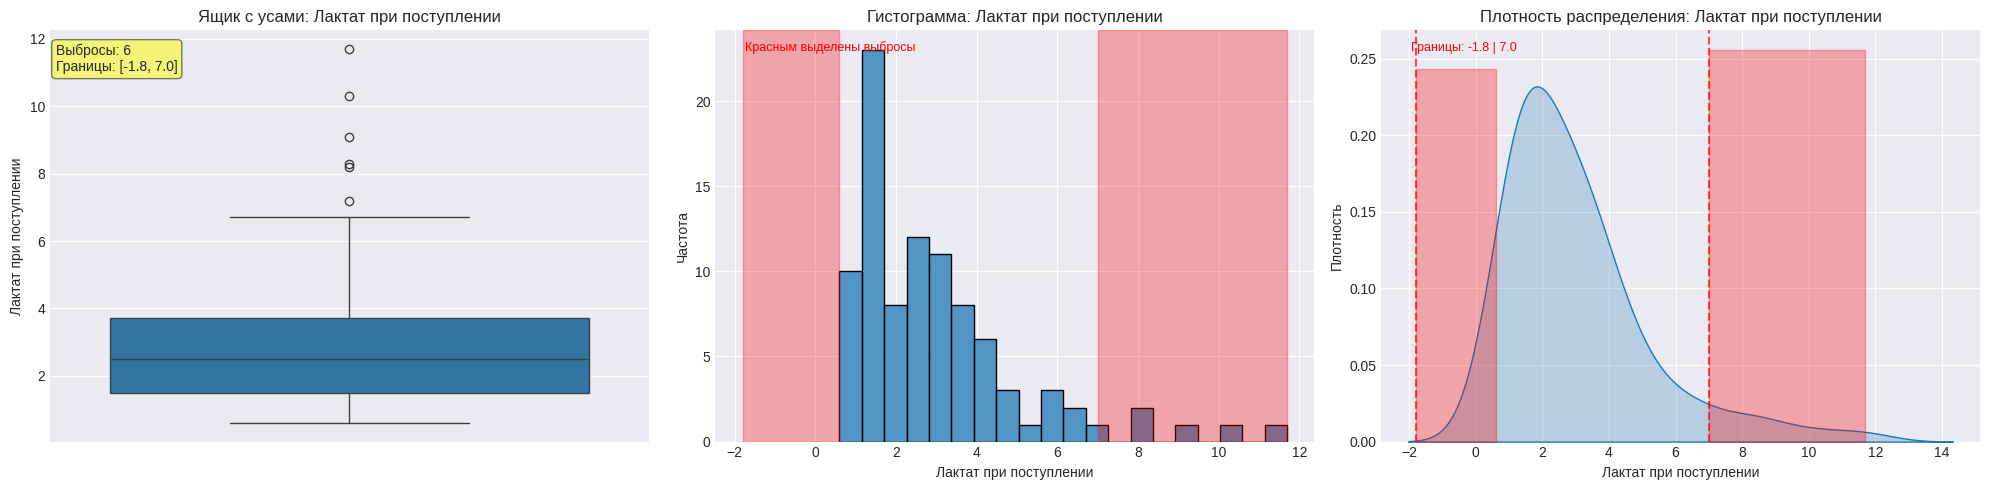

Выбросы: 6 из 182 (3.3%)
Границы выбросов: [-1.80, 7.00]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

### 24 - Глюкоза при поступлении

In [ ]:
### 24. Глюкоза при поступлении

col = 'Глюкоза при поступлении'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')


print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()


Глюкоза при поступлении
уник. значений: 121
тип: float64
кол-во пропусков: 39

Статистика:
count    143.000000
mean      29.721888
std       13.453608
min        9.060000
25%       20.610000
50%       27.500000
75%       36.150000
max       92.780000
Name: Глюкоза при поступлении, dtype: float64


Глюкоза при поступлении
13.0    3
16.0    3
29.0    3
36.0    3
31.0    3
       ..
18.8    1
40.0    1
26.9    1
25.0    1
29.6    1
Name: count, Length: 121, dtype: int64

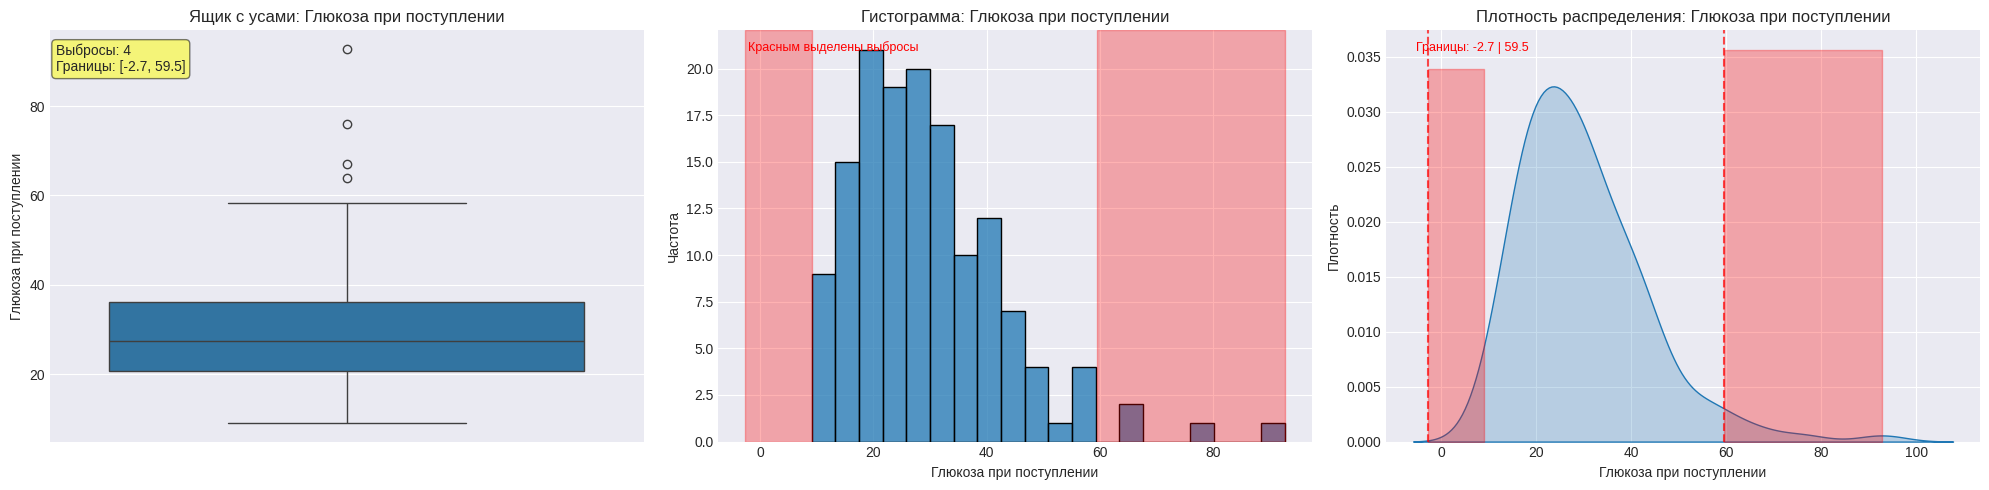

Выбросы: 4 из 182 (2.2%)
Границы выбросов: [-2.70, 59.46]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

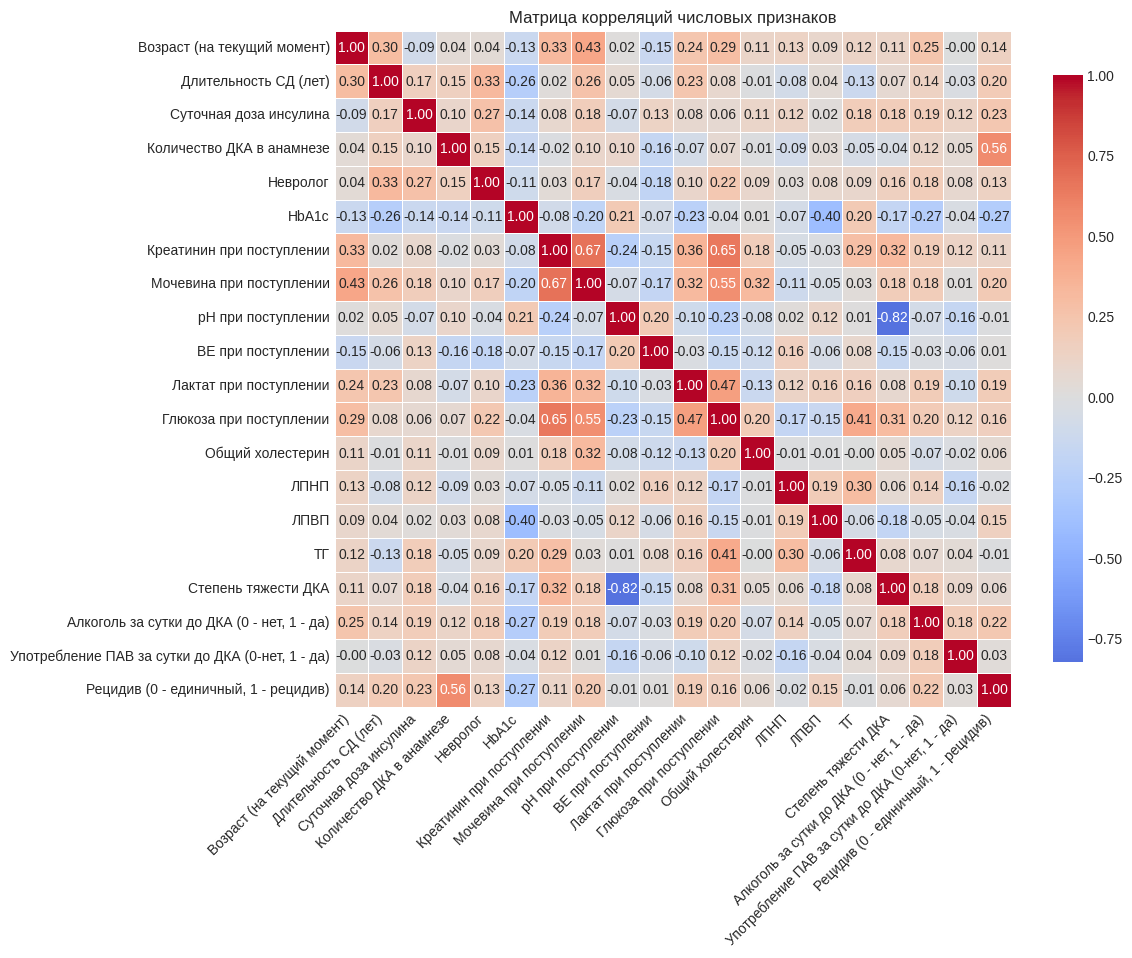

In [ ]:
# Визуализация матрицы корреляций
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций числовых признаков')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
data[(data['Креатинин при поступлении'].isna())|(data['Мочевина при поступлении'].isna())|(data['pH при поступлении'].isna())|(data['ВЕ при поступлении'].isna())|(data['Глюкоза при поступлении'].isna())]

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
0                        1.0                         35.0                True   
2                        1.0                         24.0                True   
3                        2.0                         42.0               False   
4                        1.0                         48.0               False   
6                        1.0                         34.0               False   
..                       ...                          ...                 ...   
185                      1.0                         29.0               False   
188                      1.0                         24.0               False   
189                      1.0                         25.0                True   
191                      1.0                         21.0               False   
194                      3.0                         60.0               False   

     Длительность СД (лет)  \
0                      1.0   
2                      0.0   
3                      0.0   
4                     10.0   
6                     10.0   
..                     ...   
185                    6.0   
188                    0.0   
189                    5.0   
191                   10.0   
194                   20.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
0                                                  1.0         
2                                                  0.0         
3                                                  1.0         
4                                                  2.0         
6                                                  1.0         
..                                                 ...         
185                                                1.0         
188                                                0.0         
189                                                1.0         
191                                                1.0         
194                                                0.0         

     Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  \
0                      36.0                          1      1    1.0   
2                      32.0                          1      1    1.0   
3                      32.0                          1      1    2.0   
4                      35.0                          2      1    1.0   
6                      10.0                          2      1    1.0   
..                      ...                        ...    ...    ...   
185                     0.0                          1      1    1.0   
188                     0.0                          1      0    0.0   
189                    43.0                          1      1    1.0   
191                     0.0                          1      0    0.0   
194                     0.0                          1      0    0.0   

     Невролог  \
0         0.0   
2         0.0   
3         1.0   
4         1.0   
6         1.0   
..        ...   
185       1.0   
188       0.0   
189       1.0   
191       0.0   
194       0.0   

    Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
0                                                  0.0                                          
2                                                  0.0                                          
3                                                  0.0                                          
4                                                  1.0                                          
6                                                  1.0                                          
..                                                 ...                                          
185                                                0.0                                          
188                                                0.0 

**ДЛЯ ВСЕХ КОЛОНОК, ОТВЕЧАЮЩИХ ЗА АНАЛИЗЫ ПРИ ПОСТУПЛЕНИИ, ЗАПОЛНЯЕМ ПРОПУСКИ МЕДИАНОЙ**

In [ ]:
# Список колонок
cols = ['Креатинин при поступлении', 'Мочевина при поступлении', 'Лактат при поступлении',
        'pH при поступлении', 'ВЕ при поступлении', 'Глюкоза при поступлении']

# Заполняем медианой
data[cols] = data[cols].fillna(data[cols].median())

# Проверяем
print("Пропусков после:", data[cols].isna().sum().sum())

Пропусков после: 0


### 25 - Общий холестерин

In [ ]:
## 25. Общий холестерин

col = 'Общий холестерин'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

Общий холестерин
уник. значений: 114
тип: float64
кол-во пропусков: 44

Статистика:
count    138.000000
mean       8.955000
std       36.240571
min        1.440000
25%        3.850000
50%        4.500000
75%        5.265000
max      364.000000
Name: Общий холестерин, dtype: float64


Общий холестерин
4.52    3
4.50    2
4.77    2
6.77    2
6.84    2
       ..
3.76    1
3.05    1
5.01    1
5.67    1
4.99    1
Name: count, Length: 114, dtype: int64

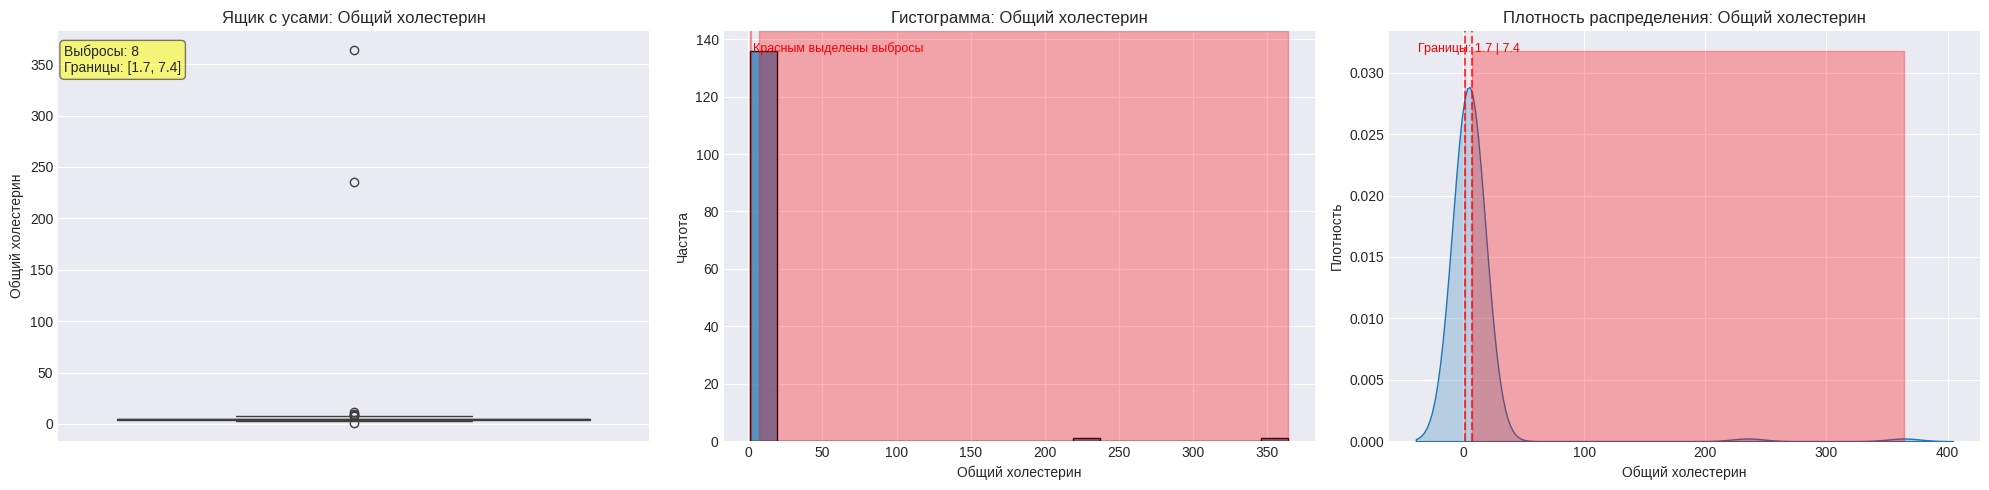

Выбросы: 8 из 182 (4.4%)
Границы выбросов: [1.73, 7.39]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

In [ ]:
data.sort_values('Общий холестерин', ascending=False).head(20)

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
23                       1.0                         37.0                True   
186                      2.0                         62.0               False   
176                      3.0                         43.0                True   
162                      1.0                         42.0                True   
14                       1.0                         44.0                True   
34                       1.0                         48.0                True   
92                       1.0                         46.0                True   
127                      1.0                         45.0                True   
3                        2.0                         42.0               False   
71                       1.0                         53.0               False   
130                      1.0                         26.0               False   
109                      1.0                         43.0                True   
63                       1.0                         43.0                True   
163                      1.0                         43.0                True   
32                       1.0                         40.0                True   
19                       1.0                         31.0                True   
94                       2.0                         34.0                True   
136                      2.0                         40.0                True   
168                      1.0                         21.0               False   
131                      1.0                         40.0                True   

     Длительность СД (лет)  \
23                     1.0   
186                   20.0   
176                   12.0   
162                    3.0   
14                     0.0   
34                    15.0   
92                    10.0   
127                   15.0   
3                      0.0   
71                    12.0   
130                   14.0   
109                   19.0   
63                     4.0   
163                    4.0   
32                     0.0   
19                     1.0   
94                     3.0   
136                    3.0   
168                    6.0   
131                   15.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
23                                                 0.0         
186                                                1.0         
176                                                1.0         
162                                                1.0         
14                                                 0.0         
34                                                 1.0         
92                                                 1.0         
127                                                1.0         
3                                                  1.0         
71                                                 1.0         
130                                                2.0         
109                                                1.0         
63                                                 1.0         
163                                                1.0         
32                                                 0.0         
19                                                 0.0         
94                                                 1.0         
136                                                0.0         
168                                                1.0         
131                                                1.0         

     Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  \
23                     42.0                          2      1    1.0   
186                    72.0                          1      1    1.0   
176                    70.0                          0      1    2.0   
162                    48.0           

In [ ]:
print(data.select_dtypes(include=[np.number]).corr()['Общий холестерин'].sort_values(key=abs, ascending=False).head(11).iloc[1:])

Мочевина при поступлении                      0.320278
Глюкоза при поступлении                       0.201114
Креатинин при поступлении                     0.178444
Возраст (на текущий момент)                   0.109501
Суточная доза инсулина                        0.105622
Лактат при поступлении                       -0.104480
ВЕ при поступлении                           -0.094265
Невролог                                      0.092094
pH при поступлении                           -0.076219
Алкоголь за сутки до ДКА (0 - нет, 1 - да)   -0.065437
Name: Общий холестерин, dtype: float64


**ПРОПУСКИ**

In [ ]:
# медианой пропуск заполняем
data['Общий холестерин'] = data['Общий холестерин'].fillna(data['Общий холестерин'].median())

# Проверяем
print("Пропусков после:", data['Общий холестерин'].isna().sum().sum())

Пропусков после: 0


### 26 - ЛПНП

In [ ]:
## 26. ЛПНП

col = 'ЛПНП'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

ЛПНП
уник. значений: 91
тип: float64
кол-во пропусков: 72

Статистика:
count    110.000000
mean       2.722091
std        1.235878
min        0.270000
25%        1.945000
50%        2.495000
75%        3.152500
max        9.220000
Name: ЛПНП, dtype: float64


ЛПНП
2.42    3
2.28    3
2.51    2
2.23    2
2.92    2
       ..
3.44    1
1.82    1
3.00    1
2.33    1
3.86    1
Name: count, Length: 91, dtype: int64

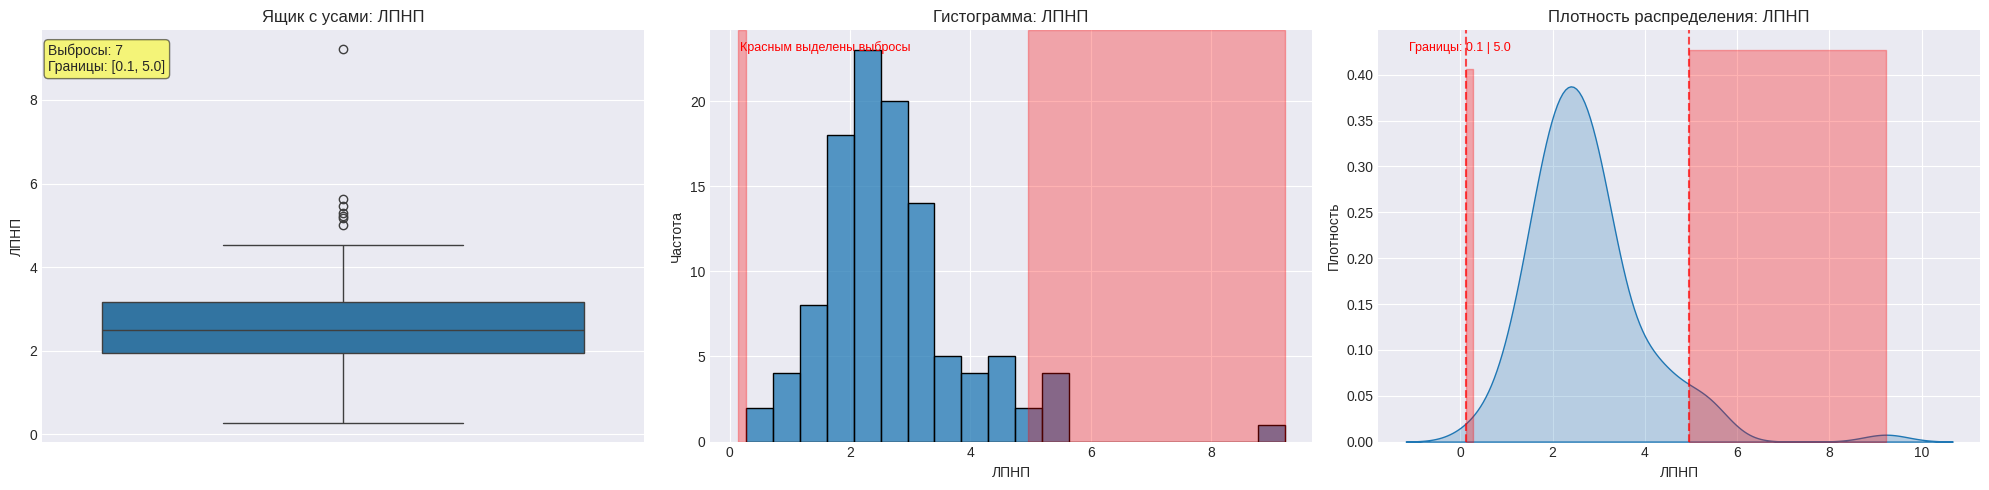

Выбросы: 7 из 182 (3.8%)
Границы выбросов: [0.13, 4.96]


In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

### 27 - ЛПВП

In [ ]:
## 27. ЛПВП

col = 'ЛПВП'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

ЛПВП
уник. значений: 77
тип: float64
кол-во пропусков: 73

Статистика:
count    109.000000
mean       1.487339
std        3.262686
min        0.200000
25%        0.890000
50%        1.160000
75%        1.450000
max       35.000000
Name: ЛПВП, dtype: float64


ЛПВП
0.71    4
1.41    3
1.26    3
1.51    3
0.87    3
       ..
0.98    1
1.48    1
1.02    1
1.00    1
0.70    1
Name: count, Length: 77, dtype: int64

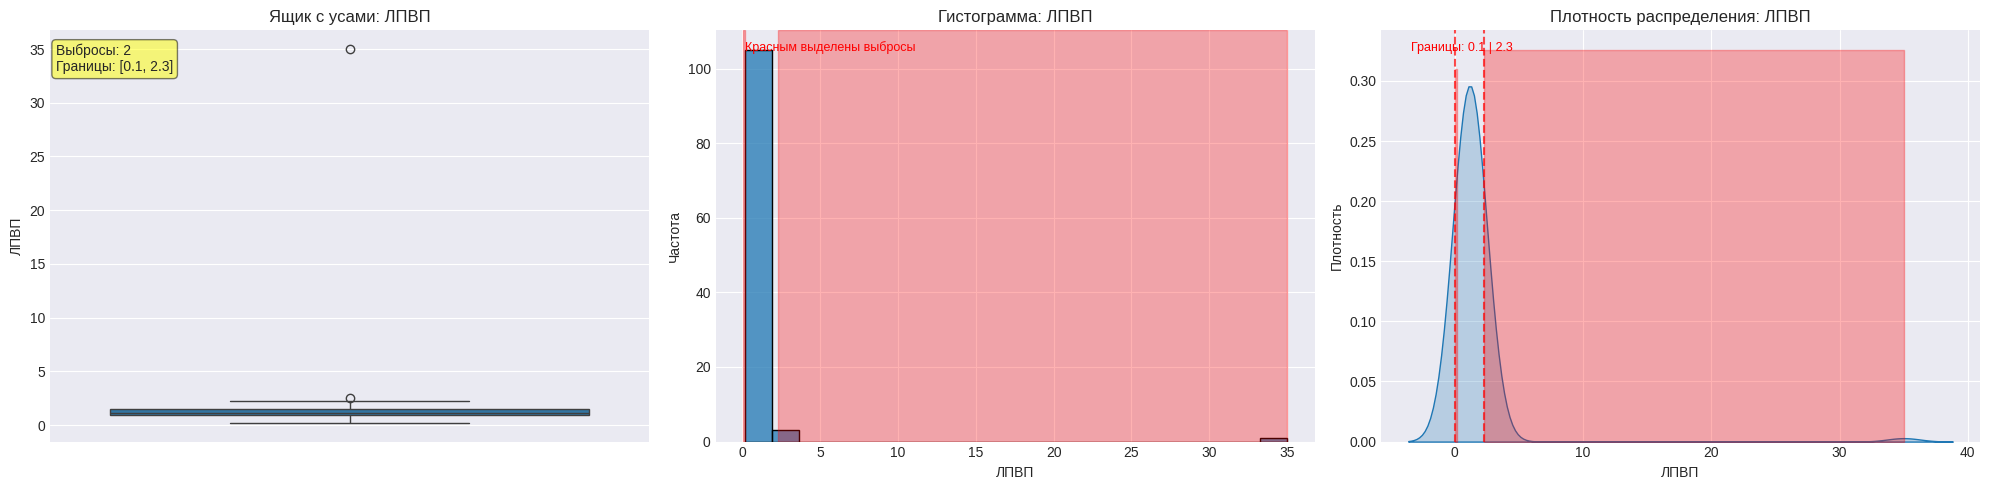

Выбросы: 2 из 182 (1.1%)
Границы выбросов: [0.05, 2.29]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

In [ ]:
data.sort_values('ЛПВП', ascending=False)

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
92                       1.0                         46.0                True   
75                       1.0                         26.0               False   
123                      1.0                         49.0               False   
37                       1.0                         65.0                True   
73                       1.0                         25.0                True   
..                       ...                          ...                 ...   
185                      1.0                         29.0               False   
186                      2.0                         62.0               False   
189                      1.0                         25.0                True   
191                      1.0                         21.0               False   
194                      3.0                         60.0               False   

     Длительность СД (лет)  \
92                    10.0   
75                    14.0   
123                   15.0   
37                    26.0   
73                    12.0   
..                     ...   
185                    6.0   
186                   20.0   
189                    5.0   
191                   10.0   
194                   20.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
92                                                 1.0         
75                                                 1.0         
123                                                1.0         
37                                                 1.0         
73                                                 1.0         
..                                                 ...         
185                                                1.0         
186                                                1.0         
189                                                1.0         
191                                                1.0         
194                                                0.0         

     Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  \
92                     36.0                          2      1    1.0   
75                     64.0                          3      1    2.0   
123                    50.0                          2      0    0.0   
37                     54.0                          1      3    2.0   
73                     58.0                          2      1    1.0   
..                      ...                        ...    ...    ...   
185                     0.0                          1      1    1.0   
186                    72.0                          1      1    1.0   
189                    43.0                          1      1    1.0   
191                     0.0                          1      0    0.0   
194                     0.0                          1      0    0.0   

     Невролог  \
92        1.0   
75        1.0   
123       0.0   
37        1.0   
73        1.0   
..        ...   
185       1.0   
186       1.0   
189       1.0   
191       0.0   
194       0.0   

    Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
92                                                 0.0                                          
75                                                 1.0                                          
123                                                0.0                                          
37                                                 1.0                                          
73                                                 1.0                                          
..                                                 ...                                          
185                                                0.0                                          
186                                                0.0 

In [ ]:
data[data['ЛПВП'].isna()]

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
0                        1.0                         35.0                True   
1                        2.0                         63.0                True   
2                        1.0                         24.0                True   
4                        1.0                         48.0               False   
5                        1.0                         37.0                True   
..                       ...                          ...                 ...   
185                      1.0                         29.0               False   
186                      2.0                         62.0               False   
189                      1.0                         25.0                True   
191                      1.0                         21.0               False   
194                      3.0                         60.0               False   

     Длительность СД (лет)  \
0                      1.0   
1                      6.0   
2                      0.0   
4                     10.0   
5                      0.0   
..                     ...   
185                    6.0   
186                   20.0   
189                    5.0   
191                   10.0   
194                   20.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
0                                                  1.0         
1                                                  1.0         
2                                                  0.0         
4                                                  2.0         
5                                                  0.0         
..                                                 ...         
185                                                1.0         
186                                                1.0         
189                                                1.0         
191                                                1.0         
194                                                0.0         

     Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  \
0                      36.0                          1      1    1.0   
1                      54.0                          3      2    1.0   
2                      32.0                          1      1    1.0   
4                      35.0                          2      1    1.0   
5                      28.0                          1      1    1.0   
..                      ...                        ...    ...    ...   
185                     0.0                          1      1    1.0   
186                    72.0                          1      1    1.0   
189                    43.0                          1      1    1.0   
191                     0.0                          1      0    0.0   
194                     0.0                          1      0    0.0   

     Невролог  \
0         0.0   
1         0.0   
2         0.0   
4         1.0   
5         1.0   
..        ...   
185       1.0   
186       1.0   
189       1.0   
191       0.0   
194       0.0   

    Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
0                                                  0.0                                          
1                                                  0.0                                          
2                                                  0.0                                          
4                                                  1.0                                          
5                                                  0.0                                          
..                                                 ...                                          
185                                                0.0                                          
186                                                0.0 

у колонок ЛПНП	ЛПВП	ТГ пропуски одновременно

### 28 - ТГ

In [ ]:
## 28. ТГ

col = 'ТГ'
print(col)
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

print('\nСтатистика:')
print(data[col].describe())
data[col].value_counts()

ТГ
уник. значений: 84
тип: float64
кол-во пропусков: 69

Статистика:
count    113.000000
mean       1.784159
std        1.210437
min        0.490000
25%        1.020000
50%        1.450000
75%        2.150000
max        9.370000
Name: ТГ, dtype: float64


ТГ
1.44    3
1.02    3
0.96    3
1.28    2
3.49    2
       ..
0.91    1
3.76    1
0.83    1
0.76    1
0.94    1
Name: count, Length: 84, dtype: int64

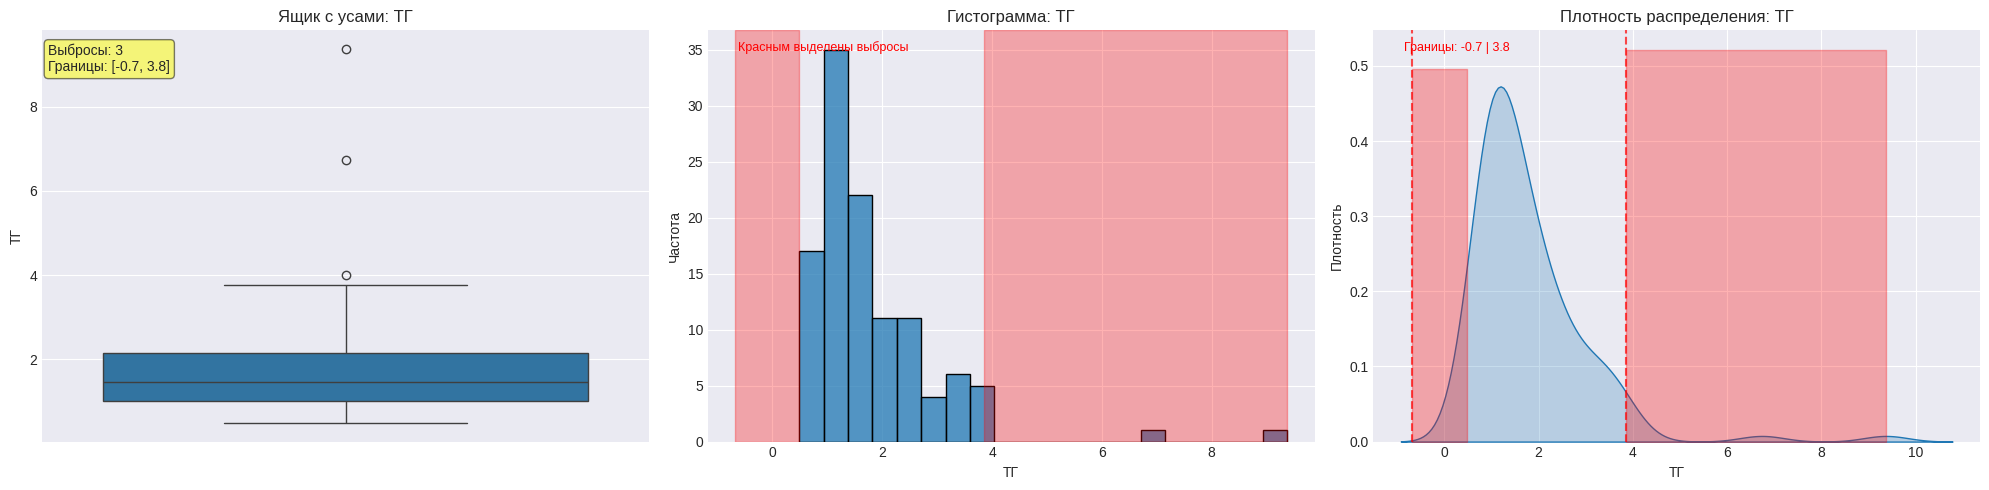

Выбросы: 3 из 182 (1.6%)
Границы выбросов: [-0.67, 3.84]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Статистика для выбросов
Q1, Q3 = data[col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = ((data[col] < lower) | (data[col] > upper)).sum()

# 1. Ящик с усами
sns.boxplot(y=data[col], ax=axes[0])
axes[0].set_title(f'Ящик с усами: {col}')
axes[0].text(0.01, 0.9, f'Выбросы: {outliers}\nГраницы: [{lower:.1f}, {upper:.1f}]',
             transform=axes[0].transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Гистограмма с выделением выбросов
sns.histplot(data[col], bins=20, kde=False, ax=axes[1])
# Закрашиваем области выбросов
axes[1].axvspan(data[col].min(), lower, alpha=0.3, color='red')
axes[1].axvspan(upper, data[col].max(), alpha=0.3, color='red')
axes[1].set_title(f'Гистограмма: {col}')
axes[1].set_xlabel(col)
axes[1].set_ylabel('Частота')
axes[1].text(0.05, 0.95, 'Красным выделены выбросы',
             transform=axes[1].transAxes, fontsize=9, color='red')

# 3. Плотность распределения с выделением выбросов
sns.kdeplot(data[col], fill=True, ax=axes[2])
# Закрашиваем области выбросов
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], data[col].min(), lower, color='red', alpha=0.3)
axes[2].fill_betweenx([0, axes[2].get_ylim()[1]], upper, data[col].max(), color='red', alpha=0.3)
# Линии границ
axes[2].axvline(lower, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(upper, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f'Плотность распределения: {col}')
axes[2].set_xlabel(col)
axes[2].set_ylabel('Плотность')
axes[2].text(0.05, 0.95, f'Границы: {lower:.1f} | {upper:.1f}',
             transform=axes[2].transAxes, fontsize=9, color='red')

plt.tight_layout()
plt.show()

print(f"Выбросы: {outliers} из {len(data)} ({outliers/len(data)*100:.1f}%)")
print(f"Границы выбросов: [{lower:.2f}, {upper:.2f}]")

In [ ]:
data.sort_values('ТГ', ascending=False)

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
14                       1.0                         44.0                True   
162                      1.0                         42.0                True   
34                       1.0                         48.0                True   
182                      1.0                         20.0                True   
127                      1.0                         45.0                True   
..                       ...                          ...                 ...   
186                      2.0                         62.0               False   
189                      1.0                         25.0                True   
191                      1.0                         21.0               False   
193                      1.0                         37.0               False   
194                      3.0                         60.0               False   

     Длительность СД (лет)  \
14                     0.0   
162                    3.0   
34                    15.0   
182                    8.0   
127                   15.0   
..                     ...   
186                   20.0   
189                    5.0   
191                   10.0   
193                    0.0   
194                   20.0   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
14                                                 0.0         
162                                                1.0         
34                                                 1.0         
182                                                1.0         
127                                                1.0         
..                                                 ...         
186                                                1.0         
189                                                1.0         
191                                                1.0         
193                                                0.0         
194                                                0.0         

     Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  \
14                     30.0                          1      1    1.0   
162                    48.0                          0      0    0.0   
34                     48.0                          3      2    1.0   
182                    43.0                          1      1    1.0   
127                    43.0                          1     3а    1.0   
..                      ...                        ...    ...    ...   
186                    72.0                          1      1    1.0   
189                    43.0                          1      1    1.0   
191                     0.0                          1      0    0.0   
193                     0.0                          1      0    0.0   
194                     0.0                          1      0    0.0   

     Невролог  \
14        1.0   
162       0.0   
34        1.0   
182       1.0   
127       1.0   
..        ...   
186       1.0   
189       1.0   
191       0.0   
193       0.0   
194       0.0   

    Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
14                                                 0.0                                          
162                                                0.0                                          
34                                                 1.0                                          
182                                                0.0                                          
127                                                0.0                                          
..                                                 ...                                          
186                                                0.0                                          
189                                                1.0 

In [ ]:
cols = ['ЛПНП', 'ЛПВП', 'ТГ']

# Заполняем медианой
data[cols] = data[cols].fillna(data[cols].median())

# Проверяем
print("Пропусков после:", data[cols].isna().sum().sum())

Пропусков после: 0


### 29 - Степень тяжести ДКА

In [ ]:
## 29. Степень тяжести ДКА

col = 'Степень тяжести ДКА'
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

Степень тяжести ДКА
3.0    86
2.0    46
1.0    26
Name: count, dtype: int64
уник. значений: 3
тип: float64
кол-во пропусков: 24


In [ ]:
data['Степень тяжести ДКА'] = data['Степень тяжести ДКА'].astype('category')

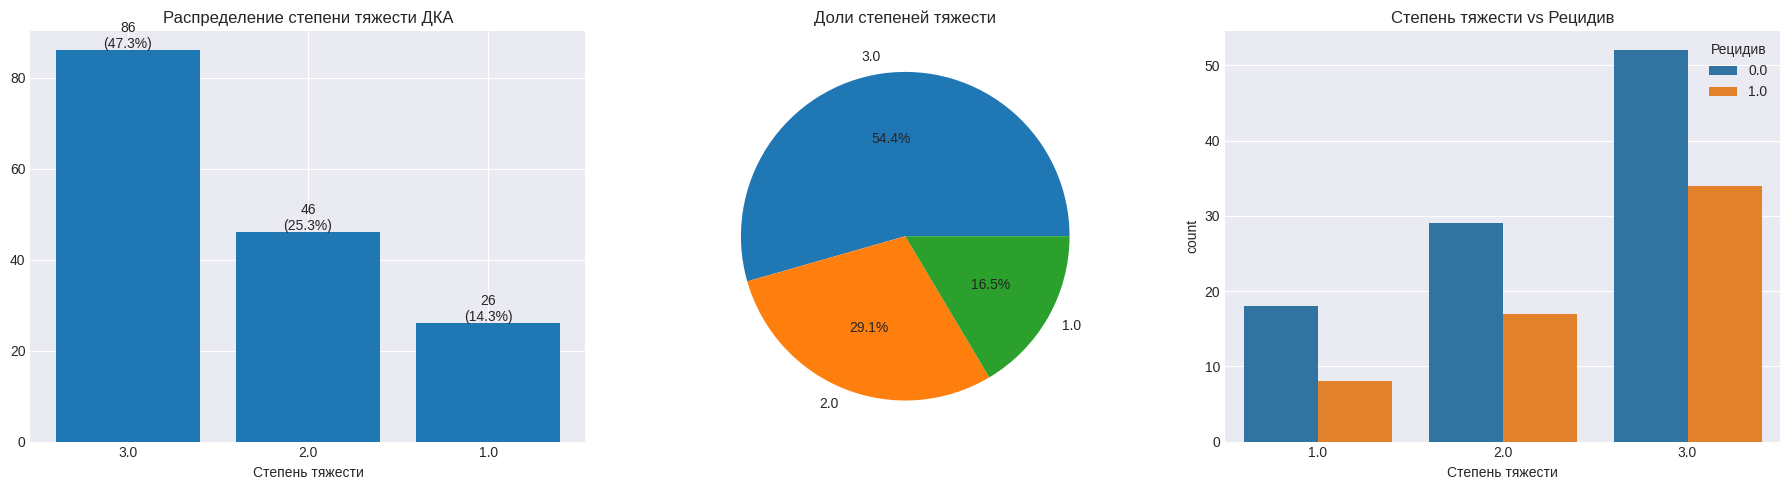

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Столбчатая диаграмма с процентами
total = len(data)
value_counts = data['Степень тяжести ДКА'].value_counts()
bars = axes[0].bar(value_counts.index.astype(str), value_counts.values)
axes[0].set_title('Распределение степени тяжести ДКА')
axes[0].set_xlabel('Степень тяжести')

# Добавляем проценты
for bar, count in zip(bars, value_counts.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}\n({count/total*100:.1f}%)', ha='center')

# Круговая диаграмма
axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
axes[1].set_title('Доли степеней тяжести')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x='Степень тяжести ДКА',
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[2])
axes[2].set_title('Степень тяжести vs Рецидив')
axes[2].set_xlabel('Степень тяжести')
axes[2].legend(title='Рецидив')

plt.tight_layout()
plt.show()

**РАБОТА С ПРОПУСКАМИ**

In [ ]:
# ANOVA F-value для каждого числового признака
numeric_cols = data.select_dtypes(include=[np.number]).columns
f_values, p_values = f_classif(data[numeric_cols].fillna(data[numeric_cols].median()),
                                data['Степень тяжести ДКА'].fillna(data['Степень тяжести ДКА'].mode()[0]))

# Топ-10 по F-value
top10_idx = np.argsort(f_values)[-10:][::-1]
print("Топ-10 числовых признаков по связи с 'Степень тяжести ДКА' (ANOVA F-value):")
for idx in top10_idx:
    print(f"{numeric_cols[idx]:30} : F={f_values[idx]:.1f}, p={p_values[idx]:.4f}")

Топ-10 числовых признаков по связи с 'Степень тяжести ДКА' (ANOVA F-value):
pH при поступлении             : F=83.5, p=0.0000
Креатинин при поступлении      : F=6.8, p=0.0014
Глюкоза при поступлении        : F=6.0, p=0.0031
ТГ                             : F=4.9, p=0.0085
Невролог                       : F=3.9, p=0.0215
Суточная доза инсулина         : F=3.4, p=0.0352
ВЕ при поступлении             : F=2.5, p=0.0837
Мочевина при поступлении       : F=2.5, p=0.0877
Алкоголь за сутки до ДКА (0 - нет, 1 - да) : F=1.7, p=0.1812
ЛПНП                           : F=1.5, p=0.2328


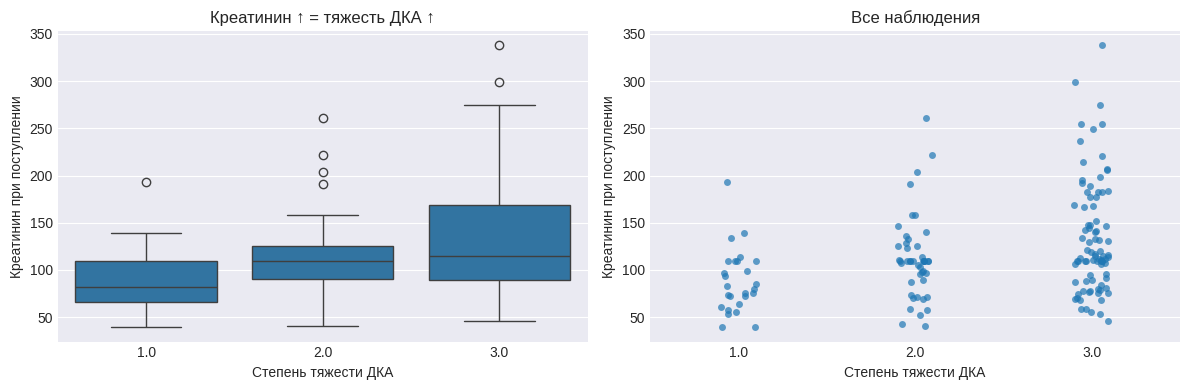

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. ящики
sns.boxplot(x='Степень тяжести ДКА', y='Креатинин при поступлении', data=data, ax=axes[0])
axes[0].set_title('Креатинин ↑ = тяжесть ДКА ↑')

# 2. Точечный график
sns.stripplot(x='Степень тяжести ДКА', y='Креатинин при поступлении', data=data, ax=axes[1], alpha=0.7)
axes[1].set_title('Все наблюдения')

plt.tight_layout()
plt.show()

Пропуски будем заполнять в зависимости от квантилей анализа ph при поступлении

In [ ]:
data['Креатинин_квантиль'] = pd.qcut(data['Креатинин при поступлении'], 4)

# 1. Таблица распределения
print("Частота степеней тяжести по квантилям Креатинин:")
print(pd.crosstab(data['Креатинин_квантиль'], data['Степень тяжести ДКА']))

# 2. Самая частая степень
print("\nСамая частая степень тяжести в каждом квантиле:")
print(data.groupby('Креатинин_квантиль', observed=True)['Степень тяжести ДКА'].agg(lambda x: x.mode()[0]))

Частота степеней тяжести по квантилям Креатинин:
Степень тяжести ДКА  1.0  2.0  3.0
Креатинин_квантиль                
(28.999, 81.5]        13   10   18
(81.5, 109.5]          9   20   18
(109.5, 139.75]        3    8   18
(139.75, 338.0]        1    8   32

Самая частая степень тяжести в каждом квантиле:
Креатинин_квантиль
(28.999, 81.5]     3.0
(81.5, 109.5]      2.0
(109.5, 139.75]    3.0
(139.75, 338.0]    3.0
Name: Степень тяжести ДКА, dtype: category
Categories (3, float64): [1.0, 2.0, 3.0]


In [ ]:
map_dict = data.groupby('Креатинин_квантиль', observed=True)['Степень тяжести ДКА'].agg(lambda x: x.mode()[0]).to_dict()
data['Степень тяжести ДКА'] = data['Степень тяжести ДКА'].fillna(data['Креатинин_квантиль'].map(map_dict)).fillna(data['Степень тяжести ДКА'].mode()[0])
data = data.drop('Креатинин_квантиль', axis=1)

print(f"Пропусков после заполнения: {data['Степень тяжести ДКА'].isna().sum()}")
print(f"\nРаспределение:")
print(data['Степень тяжести ДКА'].value_counts())

Пропусков после заполнения: 0

Распределение:
Степень тяжести ДКА
3.0    100
2.0     56
1.0     26
Name: count, dtype: int64


### 30 - Алкоголь за сутки до ДКА (0 - нет, 1 - да)

In [ ]:
## 30 . Алкоголь за сутки до ДКА (0 - нет, 1 - да)

col = 'Алкоголь за сутки до ДКА (0 - нет, 1 - да)'
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

Алкоголь за сутки до ДКА (0 - нет, 1 - да)
0.0    132
1.0     46
Name: count, dtype: int64
уник. значений: 2
тип: float64
кол-во пропусков: 4


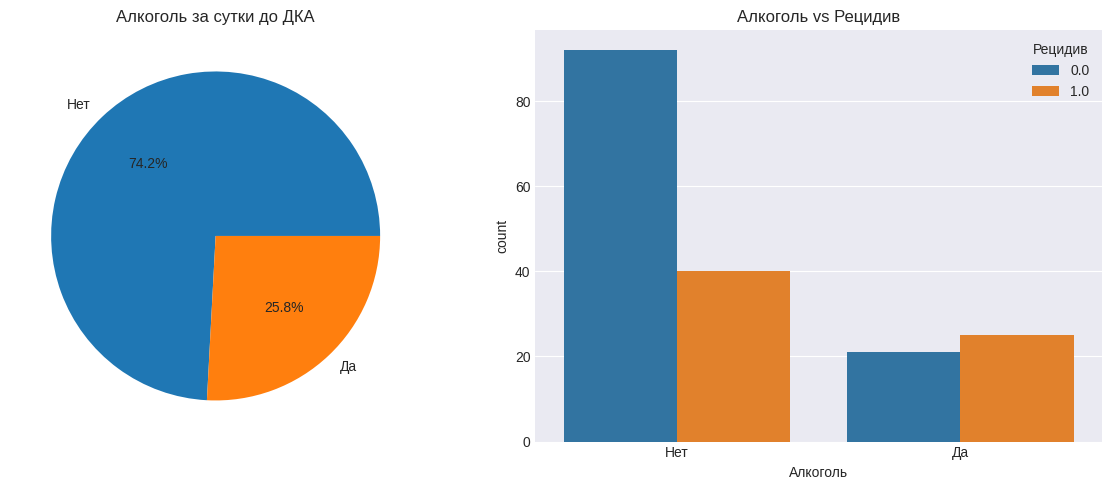

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Круговая диаграмма
value_counts = data['Алкоголь за сутки до ДКА (0 - нет, 1 - да)'].value_counts()
labels = ['Нет', 'Да']
axes[0].pie(value_counts.values, labels=labels, autopct='%1.1f%%')
axes[0].set_title('Алкоголь за сутки до ДКА')

# Столбчатая диаграмма с таргетом
sns.countplot(data=data,
              x='Алкоголь за сутки до ДКА (0 - нет, 1 - да)',
              hue='Рецидив (0 - единичный, 1 - рецидив)',
              ax=axes[1])
axes[1].set_title('Алкоголь vs Рецидив')
axes[1].set_xlabel('Алкоголь')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Нет', 'Да'])
axes[1].legend(title='Рецидив')

plt.tight_layout()
plt.show()

**ПРОПУСКИ**

In [ ]:
mode_alco = data['Алкоголь за сутки до ДКА (0 - нет, 1 - да)'].mode()[0]
data['Алкоголь за сутки до ДКА (0 - нет, 1 - да)'] = data['Алкоголь за сутки до ДКА (0 - нет, 1 - да)'].fillna(mode_alco)

### 31 - Алкоголь за сутки до ДКА (0 - нет, 1 - да)

In [ ]:
data = data.drop('Употребление ПАВ за сутки до ДКА (0-нет, 1 - да)', axis=1)

### TARGET - задача бинарной классификации, меняем тип таргета

In [ ]:
### задача бинарной классификации, меняем тип таргета
data['Рецидив (0 - единичный, 1 - рецидив)'] = data['Рецидив (0 - единичный, 1 - рецидив)'].astype(bool)

In [ ]:
col = 'Рецидив (0 - единичный, 1 - рецидив)'
print(data[col].value_counts())
print(f'уник. значений: {data[col].nunique()}')
print(f'тип: {data[col].dtype}')
print(f'кол-во пропусков: {data[col].isna().sum()}')

Рецидив (0 - единичный, 1 - рецидив)
False    116
True      66
Name: count, dtype: int64
уник. значений: 2
тип: bool
кол-во пропусков: 0


### Заполнение пропусков для HbA1c

Пропусков в HbA1c ДО импутации: 102 (56.0%)

РЕЗУЛЬТАТ:
Метод: KNNImputer (n_neighbors=5, weights='distance')
Признаки для импутации: ЛПВП, Алкоголь за сутки до ДКА (0 - нет, 1 - да), Длительность СД (лет), ТГ, Мочевина при поступлении
Заполнено значений: 102
Пропусков ПОСЛЕ импутации: 0

ГИСТОГРАММА РАСПРЕДЕЛЕНИЙ


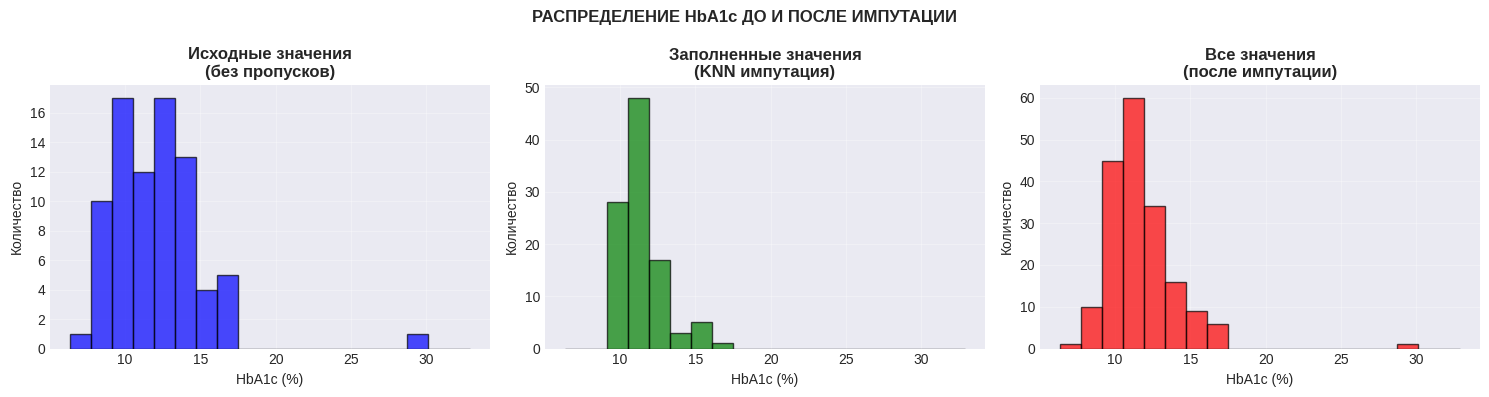


СТАТИСТИКА:
                     Исходные     Заполненные  Все после   
--------------------------------------------------------
Количество           80           102          182         
Среднее              11.99        11.51        11.72       
Медиана              11.91        11.25        11.37       
Станд. откл.         3.12         1.46         2.35        


In [ ]:
### 1 ВАРИАНТ - имитируем заполнение
from sklearn.impute import KNNImputer

# Выбираем признаки, связанные с HbA1c
features_for_impute = ['ЛПВП', 'Алкоголь за сутки до ДКА (0 - нет, 1 - да)',
                       'Длительность СД (лет)', 'ТГ', 'Мочевина при поступлении']

# 1. Сохраняем индексы пропусков ДО импутации
missing_mask = data['HbA1c'].isna()
print(f"Пропусков в HbA1c ДО импутации: {missing_mask.sum()} ({missing_mask.mean()*100:.1f}%)")

# 2. Создаем временный датафрейм для KNN
temp_data = data[['HbA1c'] + features_for_impute].copy()

# 3. Запускаем KNN
imputer = KNNImputer(n_neighbors=5, weights='distance')
temp_data_imputed_array = imputer.fit_transform(temp_data)

# 4. Преобразуем обратно в DataFrame
temp_data_imputed = pd.DataFrame(
    temp_data_imputed_array,
    columns=['HbA1c'] + features_for_impute,
    index=temp_data.index
)

# 5. Заменяем ТОЛЬКО пропущенные значения
data.loc[missing_mask, 'HbA1c'] = temp_data_imputed.loc[missing_mask, 'HbA1c']

# 6. Проверяем результат
print(f"\nРЕЗУЛЬТАТ:")
print(f"Метод: KNNImputer (n_neighbors=5, weights='distance')")
print(f"Признаки для импутации: {', '.join(features_for_impute)}")
print(f"Заполнено значений: {missing_mask.sum()}")
print(f"Пропусков ПОСЛЕ импутации: {data['HbA1c'].isna().sum()}")

# ГИСТОГРАММА
print(f"\n{'='*50}")
print("ГИСТОГРАММА РАСПРЕДЕЛЕНИЙ")
print('='*50)

# Подготовка данных
original_values = temp_data.loc[~missing_mask, 'HbA1c']  # исходные непустые
filled_values = data.loc[missing_mask, 'HbA1c']          # заполненные KNN
all_values_after = data['HbA1c']                         # все значения после импутации

# Создаем гистограмму
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Определяем общие границы для всех графиков
all_data = np.concatenate([original_values, filled_values])
x_min, x_max = all_data.min() * 0.9, all_data.max() * 1.1
bins = np.linspace(x_min, x_max, 20)

# 1. Исходные значения (без пропусков)
axes[0].hist(original_values, bins=bins, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Исходные значения\n(без пропусков)', fontweight='bold')
axes[0].set_xlabel('HbA1c (%)')
axes[0].set_ylabel('Количество')
axes[0].grid(True, alpha=0.3)

# 2. Заполненные значения
axes[1].hist(filled_values, bins=bins, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Заполненные значения\n(KNN импутация)', fontweight='bold')
axes[1].set_xlabel('HbA1c (%)')
axes[1].set_ylabel('Количество')
axes[1].grid(True, alpha=0.3)

# 3. Все значения после импутации
axes[2].hist(all_values_after, bins=bins, alpha=0.7, color='red', edgecolor='black')
axes[2].set_title('Все значения\n(после импутации)', fontweight='bold')
axes[2].set_xlabel('HbA1c (%)')
axes[2].set_ylabel('Количество')
axes[2].grid(True, alpha=0.3)

plt.suptitle('РАСПРЕДЕЛЕНИЕ HbA1c ДО И ПОСЛЕ ИМПУТАЦИИ', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Статистика
print(f"\nСТАТИСТИКА:")
print(f"{'':<20} {'Исходные':<12} {'Заполненные':<12} {'Все после':<12}")
print("-" * 56)
print(f"{'Количество':<20} {len(original_values):<12} {len(filled_values):<12} {len(all_values_after):<12}")
print(f"{'Среднее':<20} {original_values.mean():<12.2f} {filled_values.mean():<12.2f} {all_values_after.mean():<12.2f}")
print(f"{'Медиана':<20} {original_values.median():<12.2f} {filled_values.median():<12.2f} {all_values_after.median():<12.2f}")
print(f"{'Станд. откл.':<20} {original_values.std():<12.2f} {filled_values.std():<12.2f} {all_values_after.std():<12.2f}")

Проверка на пропуски

In [ ]:
data.isnull().sum()

тип СД (1-1, 2-2, 3 -др)                                                                     0
Возраст (на текущий момент)                                                                  0
Пол (0 - Ж, 1 - М)                                                                           0
Длительность СД (лет)                                                                        0
Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА                                     0
Суточная доза инсулина                                                                       0
Количество ДКА в анамнезе                                                                    0
ХБП, С                                                                                       0
ХБП, А                                                                                       0
Невролог                                                                                     0
Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)    0
HbA1c                                                                                        0
Креатинин при поступлении                                                                    0
Мочевина при поступлении                                                                     0
pH при поступлении                                                                           0
ВЕ при поступлении                                                                           0
Лактат при поступлении                                                                       0
Глюкоза при поступлении                                                                      0
Общий холестерин                                                                             0
ЛПНП                                                                                         0
ЛПВП                                                                                         0
ТГ                                                                                           0
Степень тяжести ДКА                                                                          0
Алкоголь за сутки до ДКА (0 - нет, 1 - да)                                                   0
Рецидив (0 - единичный, 1 - рецидив)                                                         0
dtype: int64

Меняем формат колонок, где это осталось необходимо

In [ ]:
data.dtypes

тип СД (1-1, 2-2, 3 -др)                                                                     category
Возраст (на текущий момент)                                                                   float64
Пол (0 - Ж, 1 - М)                                                                               bool
Длительность СД (лет)                                                                         float64
Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА                                     category
Суточная доза инсулина                                                                        float64
Количество ДКА в анамнезе                                                                       int64
ХБП, С                                                                                       category
ХБП, А                                                                                       category
Невролог                                                                                      float64
Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)    category
HbA1c                                                                                         float64
Креатинин при поступлении                                                                     float64
Мочевина при поступлении                                                                      float64
pH при поступлении                                                                            float64
ВЕ при поступлении                                                                            float64
Лактат при поступлении                                                                        float64
Глюкоза при поступлении                                                                       float64
Общий холестерин                                                                              float64
ЛПНП                                                                                          float64
ЛПВП                                                                                          float64
ТГ                                                                                            float64
Степень тяжести ДКА                                                                          category
Алкоголь за сутки до ДКА (0 - нет, 1 - да)                                                    float64
Рецидив (0 - единичный, 1 - рецидив)                                                             bool
dtype: object

In [ ]:
data[['Возраст (на текущий момент)', 'Длительность СД (лет)']] = data[['Возраст (на текущий момент)', 'Длительность СД (лет)']].astype(int)
data['Невролог'] = data['Невролог'].astype(bool)
data['Алкоголь за сутки до ДКА (0 - нет, 1 - да)'] = data['Алкоголь за сутки до ДКА (0 - нет, 1 - да)'].astype(bool)

## ВЫБРОСЫ


In [ ]:
df = data.copy()

num_cols = df.select_dtypes(include=[np.number]).columns

outliers = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers[col] = df[
        (df[col] < lower) | (df[col] > upper)
    ][col].count()

outliers


{'Возраст (на текущий момент)': np.int64(1),
 'Длительность СД (лет)': np.int64(4),
 'Суточная доза инсулина': np.int64(3),
 'Количество ДКА в анамнезе': np.int64(15),
 'HbA1c': np.int64(6),
 'Креатинин при поступлении': np.int64(8),
 'Мочевина при поступлении': np.int64(11),
 'pH при поступлении': np.int64(0),
 'ВЕ при поступлении': np.int64(26),
 'Лактат при поступлении': np.int64(86),
 'Глюкоза при поступлении': np.int64(9),
 'Общий холестерин': np.int64(22),
 'ЛПНП': np.int64(34),
 'ЛПВП': np.int64(31),
 'ТГ': np.int64(22)}

после заполнения пропусков выбросов стало больше из-за увеличения пиковых значений в распределениях

Удалим только аномалии. Выбросы, найденные через метод IQR, оставим, так как выборка очень мала. Аномалии находили у колонок:
1. HbA1c
2. Общий холестерин
3. ЛПНП
4. ЛПВП

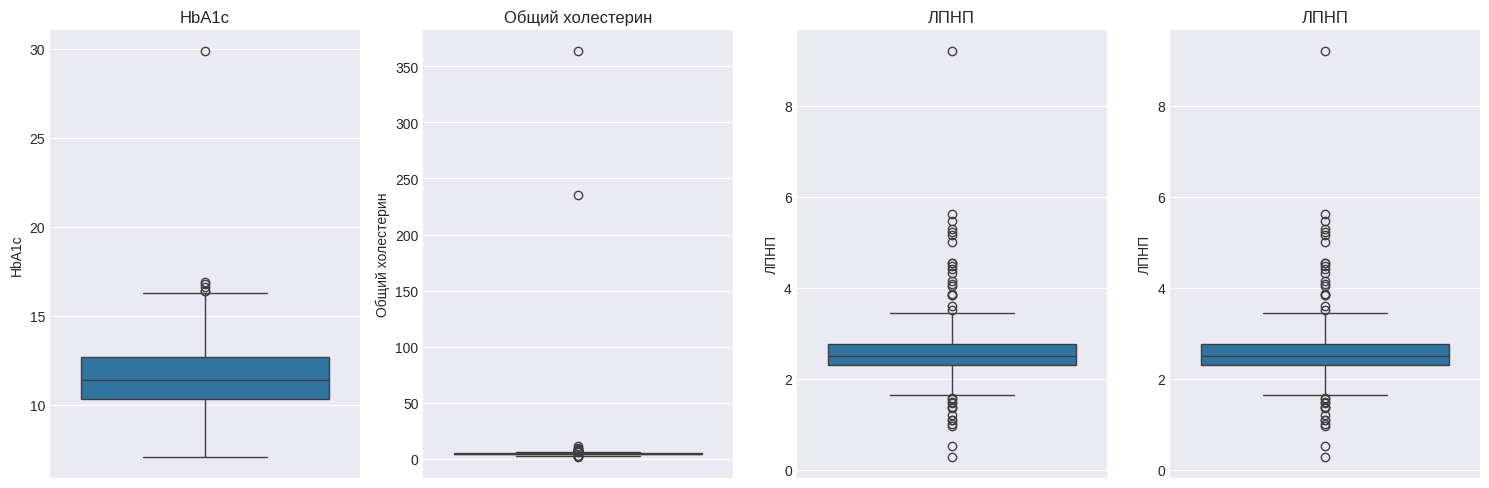

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
cols = ['HbA1c', 'Общий холестерин','ЛПНП','ЛПНП']

for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
### удаление аномалий, можно удалить по очереди, так как это все 3 разные строки
### 1. HbA1c
max_val_hba1c = df['HbA1c'].max()
df = df[df['HbA1c'] != max_val_hba1c]

### 2. Общий холестерин
top_2_chol = df['Общий холестерин'].nlargest(2).values
df = df[~df['Общий холестерин'].isin(top_2_chol)]

### 3. ЛПНП
max_val_ldl = df['ЛПНП'].max()
df = df[df['ЛПНП'] != max_val_ldl]

### 4. ЛПВП
max_val_hdl = df['ЛПВП'].max()
df = df[df['ЛПВП'] != max_val_hdl]

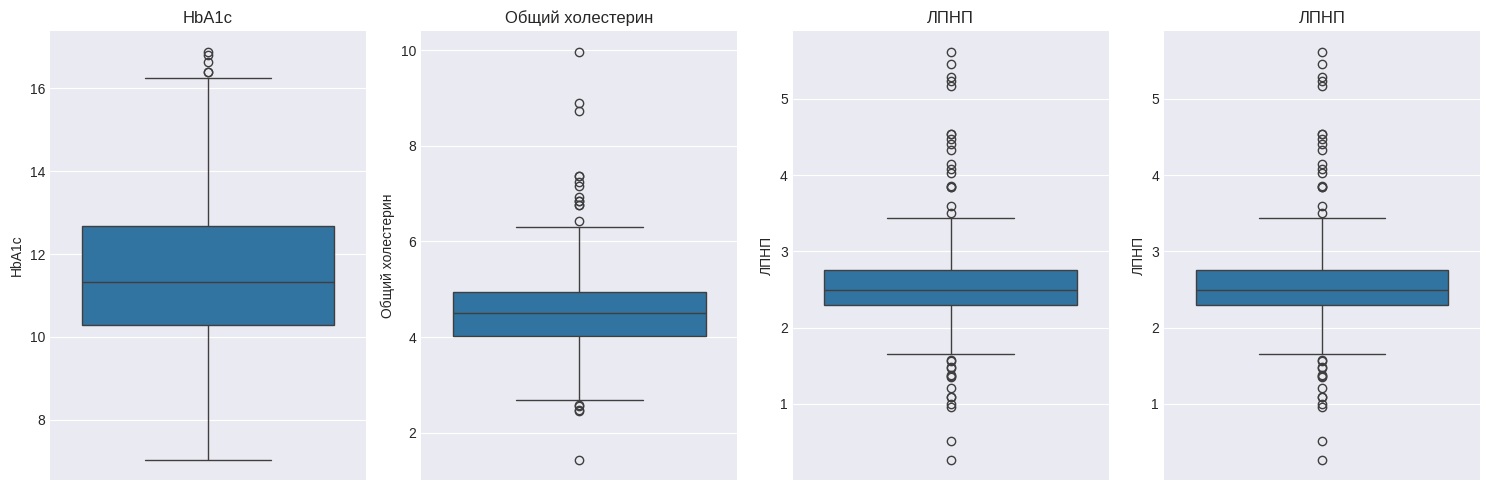

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
cols = ['HbA1c', 'Общий холестерин','ЛПНП','ЛПНП']

for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Стандартизируем данные

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop(['Количество ДКА в анамнезе'])
numeric_cols

Index(['Возраст (на текущий момент)', 'Длительность СД (лет)',
       'Суточная доза инсулина', 'HbA1c', 'Креатинин при поступлении',
       'Мочевина при поступлении', 'pH при поступлении', 'ВЕ при поступлении',
       'Лактат при поступлении', 'Глюкоза при поступлении', 'Общий холестерин',
       'ЛПНП', 'ЛПВП', 'ТГ'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
df_scaled

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
0                        1.0                     0.032554                True   
1                        2.0                     2.242683                True   
2                        1.0                    -0.835710                True   
3                        2.0                     0.585086               False   
4                        1.0                     1.058685               False   
..                       ...                          ...                 ...   
190                      1.0                     0.427220               False   
191                      1.0                    -1.072510               False   
192                      2.0                     2.242683                True   
193                      1.0                     0.190421               False   
194                      3.0                     2.005883               False   

     Длительность СД (лет)  \
0                -0.937658   
1                -0.341089   
2                -1.056971   
3                -1.056971   
4                 0.136166   
..                     ...   
190               3.238323   
191               0.136166   
192              -1.056971   
193              -1.056971   
194               1.329303   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
0                                                  1.0         
1                                                  1.0         
2                                                  0.0         
3                                                  1.0         
4                                                  2.0         
..                                                 ...         
190                                                1.0         
191                                                1.0         
192                                                0.0         
193                                                0.0         
194                                                0.0         

     Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  \
0                 -0.016202                          1      1    1.0   
1                  0.844128                          3      2    1.0   
2                 -0.207387                          1      1    1.0   
3                 -0.207387                          1      1    2.0   
4                 -0.063998                          2      1    1.0   
..                      ...                        ...    ...    ...   
190               -1.736863                          1      0    0.0   
191               -1.736863                          1      0    0.0   
192               -1.736863                          1      0    0.0   
193               -1.736863                          1      0    0.0   
194               -1.736863                          1      0    0.0   

     Невролог  \
0       False   
1       False   
2       False   
3        True   
4        True   
..        ...   
190      True   
191     False   
192     False   
193     False   
194     False   

    Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
0                                                  0.0                                          
1                                                  0.0                                          
2                                                  0.0                                          
3                                                  0.0                                          
4                                                  1.0                                          
..                                                 ...                                          
190                                                0.0                                          
191                                                0.0 

## OHE

In [ ]:
categorical_columns = df_scaled.loc[:,data.dtypes=='category'].columns
categorical_columns

Index(['тип СД (1-1, 2-2, 3 -др)',
       'Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА', 'ХБП, С',
       'ХБП, А',
       'Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)',
       'Степень тяжести ДКА'],
      dtype='object')

In [ ]:
df_scaled_ohe = df_scaled.copy()
for col in categorical_columns:
    one_hot = pd.get_dummies(df_scaled_ohe[col], prefix=col, drop_first=True)
    df_scaled_ohe = pd.concat((df_scaled_ohe.drop(col, axis=1), one_hot), axis=1)
df_scaled_ohe


Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  Длительность СД (лет)  \
0                       0.032554                True              -0.937658   
1                       2.242683                True              -0.341089   
2                      -0.835710                True              -1.056971   
3                       0.585086               False              -1.056971   
4                       1.058685               False               0.136166   
..                           ...                 ...                    ...   
190                     0.427220               False               3.238323   
191                    -1.072510               False               0.136166   
192                     2.242683                True              -1.056971   
193                     0.190421               False              -1.056971   
194                     2.005883               False               1.329303   

     Суточная доза инсулина  Количество ДКА в анамнезе  Невролог     HbA1c  \
0                 -0.016202                          1     False  2.266664   
1                  0.844128                          3     False  0.133011   
2                 -0.207387                          1     False  0.556724   
3                 -0.207387                          1      True -1.039643   
4                 -0.063998                          2      True  0.411875   
..                      ...                        ...       ...       ...   
190               -1.736863                          1      True -0.414477   
191               -1.736863                          1     False -0.509319   
192               -1.736863                          1     False  0.977517   
193               -1.736863                          1     False  0.375864   
194               -1.736863                          1     False -0.979595   

     Креатинин при поступлении  Мочевина при поступлении  pH при поступлении  \
0                    -0.157520                 -0.195827           -0.010600   
1                     2.724759                  3.967776            0.619431   
2                    -0.148008                  0.001267           -0.114452   
3                     0.936414                 -0.294374           -1.499135   
4                    -0.157520                 -0.195827           -0.114452   
..                         ...                       ...                 ...   
190                  -1.023155                 -0.146554            1.616403   
191                   4.189680                  1.898293           -1.935310   
192                  -0.071908                 -0.442194            1.270232   
193                   0.213466                 -0.442194            0.508656   
194                  -0.167033                  0.494001           -1.499135   

     ВЕ при поступлении  Лактат при поступлении  Глюкоза при поступлении  \
0             -0.764179               -1.339454                -0.934829   
1             -0.553723               -0.560215                 0.387622   
2             -0.324134               -0.170596                 1.204678   
3             -0.324134               -0.755025                -0.134620   
4             -0.324134               -0.170596                -0.260969   
..                  ...                     ...                      ...   
190            0.115911                1.322945                -0.185159   
191           -0.878973               -0.170596                -0.134620   
192            0.549579               -0.755025                -0.345201   
193           -0.158320               -0.235533                 0.042269   
194           -0.655762                0.673579                -0.134620   

     Общий холестерин      ЛПНП      ЛПВП        ТГ  \
0           -0.071806 -0.110450 -0.053296 -0.206254   
1           -0.071806 -0.110450 -0.053296 -0.206254   
2           -0.071806 -0.110450 -0.053296 -0.206254   
3            2.371036  3.

In [ ]:
df_scaled

тип СД (1-1, 2-2, 3 -др)  Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  \
0                        1.0                     0.032554                True   
1                        2.0                     2.242683                True   
2                        1.0                    -0.835710                True   
3                        2.0                     0.585086               False   
4                        1.0                     1.058685               False   
..                       ...                          ...                 ...   
190                      1.0                     0.427220               False   
191                      1.0                    -1.072510               False   
192                      2.0                     2.242683                True   
193                      1.0                     0.190421               False   
194                      3.0                     2.005883               False   

     Длительность СД (лет)  \
0                -0.937658   
1                -0.341089   
2                -1.056971   
3                -1.056971   
4                 0.136166   
..                     ...   
190               3.238323   
191               0.136166   
192              -1.056971   
193              -1.056971   
194               1.329303   

    Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА  \
0                                                  1.0         
1                                                  1.0         
2                                                  0.0         
3                                                  1.0         
4                                                  2.0         
..                                                 ...         
190                                                1.0         
191                                                1.0         
192                                                0.0         
193                                                0.0         
194                                                0.0         

     Суточная доза инсулина  Количество ДКА в анамнезе ХБП, С ХБП, А  \
0                 -0.016202                          1      1    1.0   
1                  0.844128                          3      2    1.0   
2                 -0.207387                          1      1    1.0   
3                 -0.207387                          1      1    2.0   
4                 -0.063998                          2      1    1.0   
..                      ...                        ...    ...    ...   
190               -1.736863                          1      0    0.0   
191               -1.736863                          1      0    0.0   
192               -1.736863                          1      0    0.0   
193               -1.736863                          1      0    0.0   
194               -1.736863                          1      0    0.0   

     Невролог  \
0       False   
1       False   
2       False   
3        True   
4        True   
..        ...   
190      True   
191     False   
192     False   
193     False   
194     False   

    Ретинопатия (0 - нет, 1 - непролиферативная, 2 - препролиферативная, 3 - пролиферативная)  \
0                                                  0.0                                          
1                                                  0.0                                          
2                                                  0.0                                          
3                                                  0.0                                          
4                                                  1.0                                          
..                                                 ...                                          
190                                                0.0                                          
191                                                0.0 

## ОБУЧЕНИЕ 1 вариант

In [ ]:
df = df_scaled_ohe
df

Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  Длительность СД (лет)  \
0                       0.032554                True              -0.937658   
1                       2.242683                True              -0.341089   
2                      -0.835710                True              -1.056971   
3                       0.585086               False              -1.056971   
4                       1.058685               False               0.136166   
..                           ...                 ...                    ...   
190                     0.427220               False               3.238323   
191                    -1.072510               False               0.136166   
192                     2.242683                True              -1.056971   
193                     0.190421               False              -1.056971   
194                     2.005883               False               1.329303   

     Суточная доза инсулина  Количество ДКА в анамнезе  Невролог     HbA1c  \
0                 -0.016202                          1     False  2.266664   
1                  0.844128                          3     False  0.133011   
2                 -0.207387                          1     False  0.556724   
3                 -0.207387                          1      True -1.039643   
4                 -0.063998                          2      True  0.411875   
..                      ...                        ...       ...       ...   
190               -1.736863                          1      True -0.414477   
191               -1.736863                          1     False -0.509319   
192               -1.736863                          1     False  0.977517   
193               -1.736863                          1     False  0.375864   
194               -1.736863                          1     False -0.979595   

     Креатинин при поступлении  Мочевина при поступлении  pH при поступлении  \
0                    -0.157520                 -0.195827           -0.010600   
1                     2.724759                  3.967776            0.619431   
2                    -0.148008                  0.001267           -0.114452   
3                     0.936414                 -0.294374           -1.499135   
4                    -0.157520                 -0.195827           -0.114452   
..                         ...                       ...                 ...   
190                  -1.023155                 -0.146554            1.616403   
191                   4.189680                  1.898293           -1.935310   
192                  -0.071908                 -0.442194            1.270232   
193                   0.213466                 -0.442194            0.508656   
194                  -0.167033                  0.494001           -1.499135   

     ВЕ при поступлении  Лактат при поступлении  Глюкоза при поступлении  \
0             -0.764179               -1.339454                -0.934829   
1             -0.553723               -0.560215                 0.387622   
2             -0.324134               -0.170596                 1.204678   
3             -0.324134               -0.755025                -0.134620   
4             -0.324134               -0.170596                -0.260969   
..                  ...                     ...                      ...   
190            0.115911                1.322945                -0.185159   
191           -0.878973               -0.170596                -0.134620   
192            0.549579               -0.755025                -0.345201   
193           -0.158320               -0.235533                 0.042269   
194           -0.655762                0.673579                -0.134620   

     Общий холестерин      ЛПНП      ЛПВП        ТГ  \
0           -0.071806 -0.110450 -0.053296 -0.206254   
1           -0.071806 -0.110450 -0.053296 -0.206254   
2           -0.071806 -0.110450 -0.053296 -0.206254   
3            2.371036  3.

In [ ]:
df.shape

(177, 38)

In [ ]:
X = df.drop('Рецидив (0 - единичный, 1 - рецидив)', axis=1)
y = df['Рецидив (0 - единичный, 1 - рецидив)']


# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Модели
models = {
    'CatBoost': CatBoostClassifier(iterations=100, depth=3, verbose=0, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42),
    'LogRegression': LogisticRegression(max_iter=5000, random_state=42)
}

# Оценка моделей
for name, model in models.items():
    print(f"\n{'='*50}\n{name}\n{'='*50}")

    # Кросс-валидация на трейне (4 фолда)
    cv_preds = cross_val_predict(model, X_train, y_train, cv=4, method='predict')
    cv_proba = cross_val_predict(model, X_train, y_train, cv=4, method='predict_proba')[:, 1]

    print("Кросс-валидация на трейне:")
    print(f"AUC: {roc_auc_score(y_train, cv_proba):.3f}")
    print(classification_report(y_train, cv_preds, target_names=['0', '1']))

    # Обучение и оценка на тесте
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]

    print("Предсказание на тесте:")
    print(f"AUC: {roc_auc_score(y_test, test_proba):.3f}")
    print(classification_report(y_test, test_preds, target_names=['0', '1']))


CatBoost
Кросс-валидация на трейне:
AUC: 0.931
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        90
           1       0.92      0.86      0.89        51

    accuracy                           0.92       141
   macro avg       0.92      0.91      0.91       141
weighted avg       0.92      0.92      0.92       141

Предсказание на тесте:
AUC: 0.993
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.92      0.92      0.92        13

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36


XGBoost
Кросс-валидация на трейне:
AUC: 0.930
              precision    recall  f1-score   support

           0       0.92      0.91      0.92        90
           1       0.85      0.86      0.85        51

    accuracy                           0.89       141

#### подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, f1_score

# Параметры для GridSearch
param_grids = {
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [2, 3, 4, 5, 6],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 1],
        'l2_leaf_reg': [1, 3, 5, 10],
        'border_count': [16, 32, 64, 128],
        'random_state': [42]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 3, 4, 5, 6],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.5, 1],
        'random_state': [42]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', None],
        'random_state': [42]
    },
    'LogRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000],
        'class_weight': ['balanced', None],
        'random_state': [42]
    }
}

# Гридсерч для каждой модели
best_models = {}
test_scores = {}
test_f1_scores = {}

for name, model in models.items():
    print(f"\n{'='*50}\nGridSearch для {name}\n{'='*50}")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=4,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    # Оценка на тесте
    test_preds = best_models[name].predict(X_test)
    test_proba = best_models[name].predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_proba)
    test_f1 = f1_score(y_test, test_preds, pos_label=1)  # F1 для класса 1

    test_scores[name] = test_auc
    test_f1_scores[name] = test_f1

    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"Лучший AUC (CV): {grid_search.best_score_:.3f}")
    print(f"AUC на тесте: {test_auc:.3f}")
    print(f"F1-score (класс 1) на тесте: {test_f1:.3f}")

    # Выводим classification report
    print(f"\nClassification Report для {name}:")
    print(classification_report(y_test, test_preds))

# Лучшая модель по F1-score для класса 1
best_model_name_f1 = max(test_f1_scores, key=test_f1_scores.get)
print(f"\n{'='*50}")
print(f"Лучшая модель по F1-score (класс 1): {best_model_name_f1}")
print(f"F1-score (класс 1): {test_f1_scores[best_model_name_f1]:.3f}")
print(f"AUC этой модели: {test_scores[best_model_name_f1]:.3f}")

# Также выводим лучшую по AUC для сравнения
best_model_name_auc = max(test_scores, key=test_scores.get)
print(f"\nЛучшая модель по AUC: {best_model_name_auc}")
print(f"AUC: {test_scores[best_model_name_auc]:.3f}")
print(f"F1-score (класс 1): {test_f1_scores[best_model_name_auc]:.3f}")


GridSearch для CatBoost
Fitting 4 folds for each of 1200 candidates, totalling 4800 fits
Лучшие параметры: {'border_count': 64, 'depth': 2, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.001, 'random_state': 42}
Лучший AUC (CV): 0.971
AUC на тесте: 0.987
F1-score (класс 1) на тесте: 0.923

Classification Report для CatBoost:
              precision    recall  f1-score   support

       False       0.96      0.96      0.96        23
        True       0.92      0.92      0.92        13

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36


GridSearch для XGBoost
Fitting 4 folds for each of 3840 candidates, totalling 15360 fits
Лучшие параметры: {'colsample_bytree': 0.9, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'random_state': 42, 'subsample': 1.0}
Лучший AUC (CV): 0.972
AUC на тесте: 0.980
F1-score (класс 1) на тесте: 0.923

Classificat

In [ ]:
# Бутстрэп на всех данных
n = 100
aucs = {name: [] for name in models}

for i in range(n):
    X_boot, y_boot = resample(X, y, random_state=i)
    oob_idx = X.index.difference(X_boot.index)
    X_oob, y_oob = X.loc[oob_idx], y.loc[oob_idx]

    for name, model in models.items():
        m = model.__class__(**model.get_params())
        m.fit(X_boot, y_boot)
        aucs[name].append(roc_auc_score(y_oob, m.predict_proba(X_oob)[:, 1]))

# Результаты
print("БУТСТРЭП (100 итераций):")
print("Модель: Средний_AUC ± Стандартное_отклонение и 95%_доверительный_интервал")
for name, scores in aucs.items():
    mean = np.mean(scores)
    std = np.std(scores)
    ci_low, ci_high = np.percentile(scores, [2.5, 97.5])
    print(f"{name}: {mean:.3f} ± {std:.3f} [{ci_low:.3f}-{ci_high:.3f}]")

БУТСТРЭП (100 итераций):
Модель: Средний_AUC ± Стандартное_отклонение и 95%_доверительный_интервал
CatBoost: 0.952 ± 0.031 [0.880-0.994]
XGBoost: 0.935 ± 0.037 [0.863-0.990]
RandomForest: 0.945 ± 0.028 [0.893-0.991]
LogRegression: 0.909 ± 0.034 [0.847-0.974]


Посмотрим на самые важные признаки

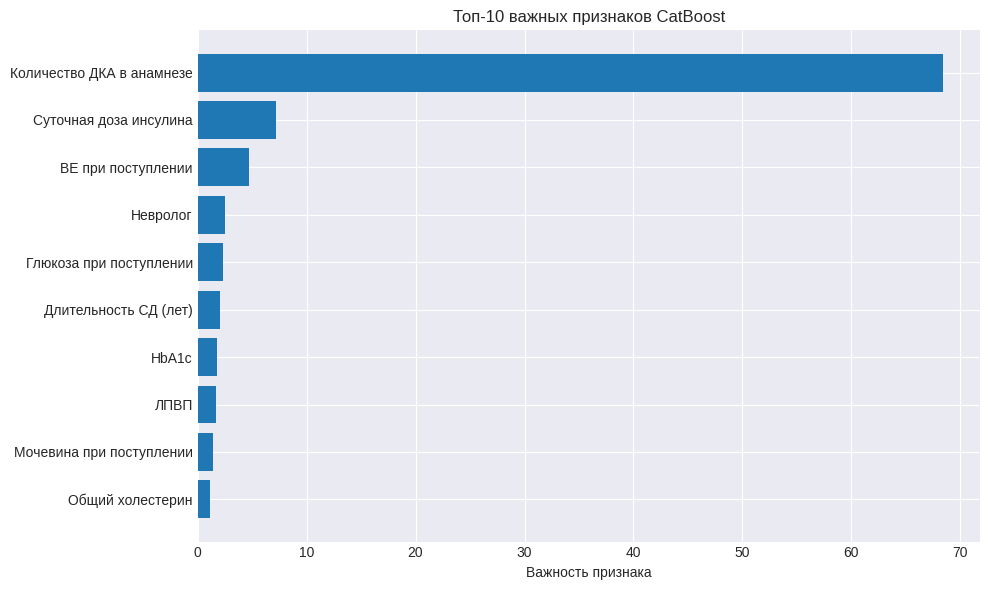

In [ ]:
# Обучение CatBoost
best_model = CatBoostClassifier(iterations=100, depth=3, verbose=0, random_state=42)
best_model.fit(X_train, y_train)

# Получение важности признаков
feature_importance = best_model.get_feature_importance()
feature_names = X.columns

# Создание DataFrame и сортировка
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(10)

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][::-1], importance_df['importance'][::-1])
plt.xlabel('Важность признака')
plt.title('Топ-10 важных признаков CatBoost')
plt.tight_layout()
plt.show()

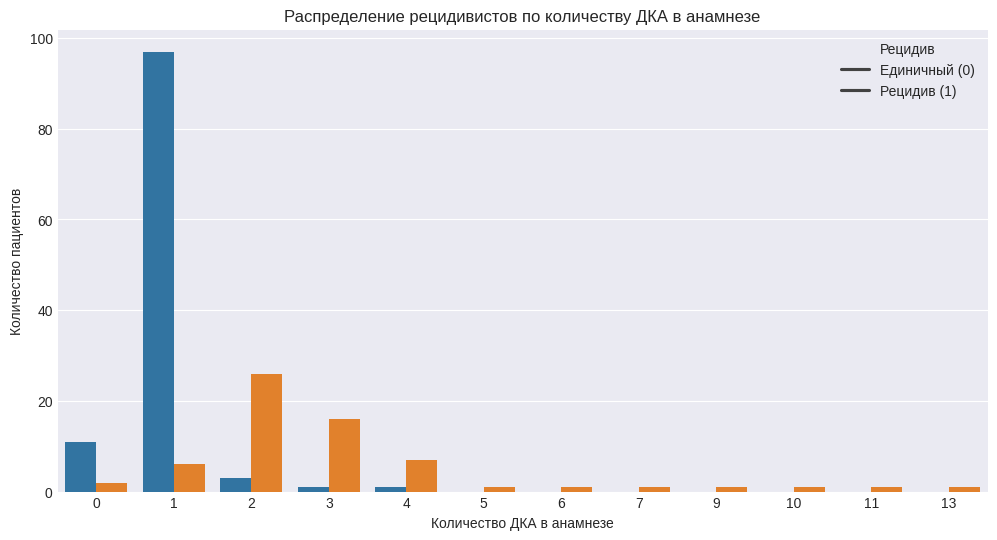

In [ ]:
# Создаем сводную таблицу
pivot_df = df.groupby(['Количество ДКА в анамнезе', 'Рецидив (0 - единичный, 1 - рецидив)']).size().reset_index(name='count')

# Строим график
plt.figure(figsize=(12, 6))
sns.barplot(data=pivot_df, x='Количество ДКА в анамнезе', y='count',
            hue='Рецидив (0 - единичный, 1 - рецидив)',
            hue_order=[0, 1])
plt.title('Распределение рецидивистов по количеству ДКА в анамнезе')
plt.xlabel('Количество ДКА в анамнезе')
plt.ylabel('Количество пациентов')
plt.legend(title='Рецидив', labels=['Единичный (0)', 'Рецидив (1)'])
plt.show()

Посмотрим на количество рецедивистов в каждом из значений количества дка в анамнезе

In [ ]:
data.groupby(['Количество ДКА в анамнезе', 'Рецидив (0 - единичный, 1 - рецидив)']).size()

Количество ДКА в анамнезе  Рецидив (0 - единичный, 1 - рецидив)
0                          False                                   12
                           True                                     2
1                          False                                   98
                           True                                     6
2                          False                                    4
                           True                                    28
3                          False                                    1
                           True                                    16
4                          False                                    1
                           True                                     7
5                          True                                     1
6                          True                                     1
7                          True                                     1
9                          True                                     1
10                         True                                     1
11                         True                                     1
13                         True                                     1
dtype: int64

фича **'количество дка в анамнезе'** показательно демонстрирует мешочки нашей таргетной переменной так, что при 1 почти все пациенты - это нерецидивисты, а при 2 и больше наоборот почти все рецидивисты

### SHAP анализ 1 вариант

In [ ]:
# Обучаем лучшую модель
best_model = CatBoostClassifier(iterations=100, depth=3, verbose=0, random_state=42)
best_model.fit(X_train, y_train)

In [ ]:
# Инициализируем SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_train)

# Проверяем размерность
print(f"Размерность shap_values: {shap_values.shape}")

Размерность shap_values: (141, 37)


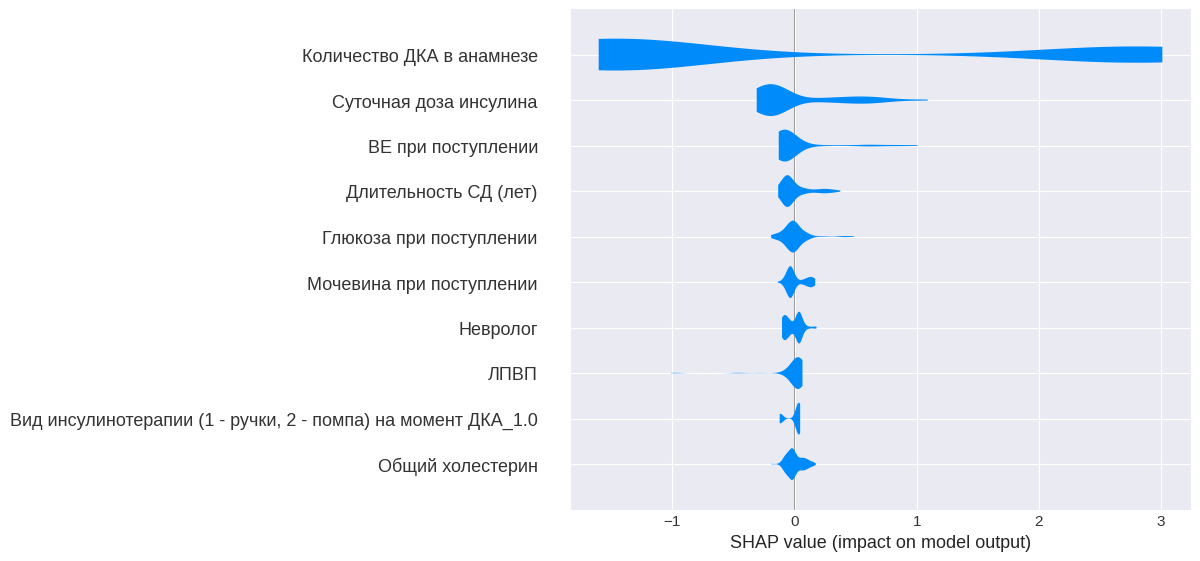

In [ ]:
# 1. Summary plot - глобальная важность признаков
feat_names = list(X_train.columns)
shap.plots.violin(shap_values, feature_names=feat_names, plot_size=0.5, max_display=10)

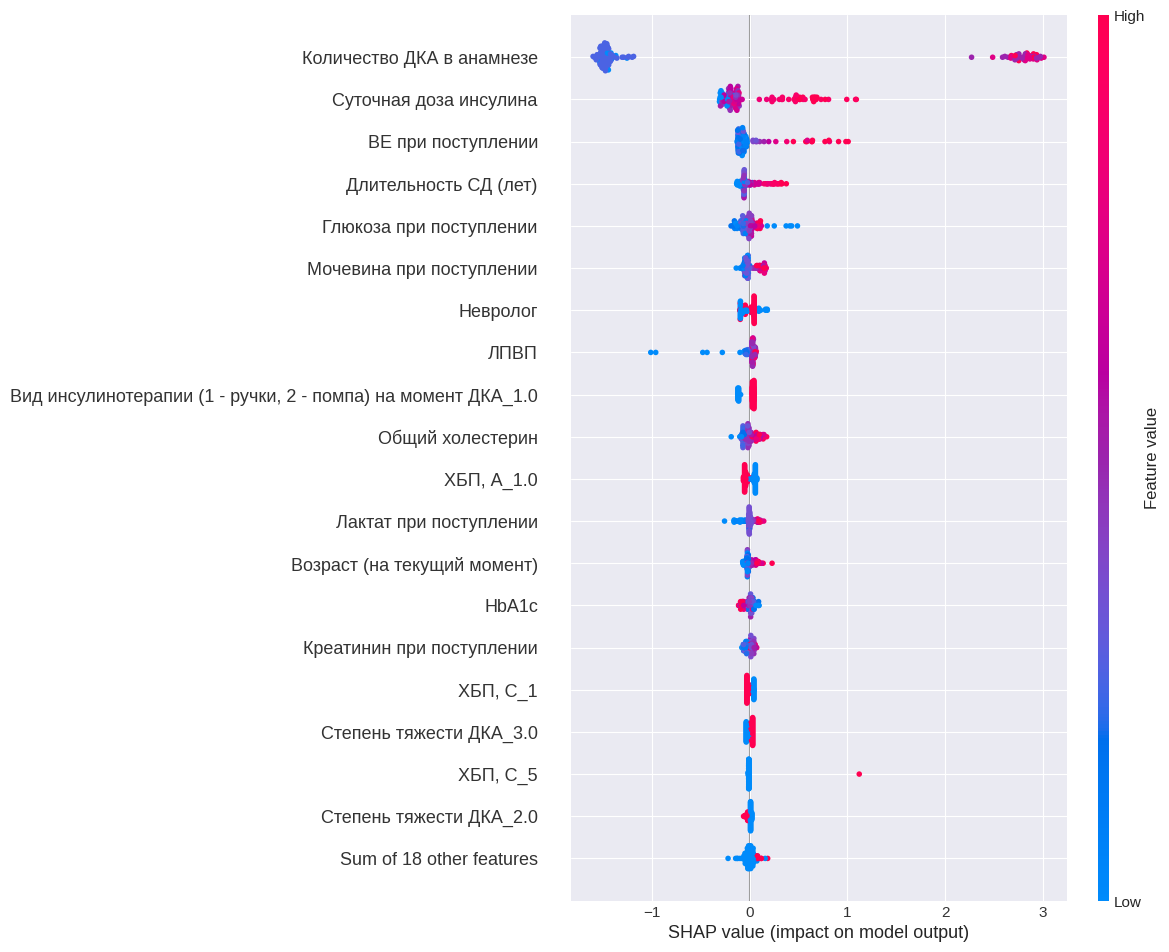

In [ ]:
# 2. beeswarm plot
shap.plots.beeswarm(shap.Explanation(values=shap_values,
                                     base_values=explainer.expected_value,
                                     data=X_train,
                                     feature_names=feat_names),
                    max_display=20,
                    plot_size=0.5)

In [ ]:
# 3. Численные значения важности
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

print("\nТоп-10 важных признаков по SHAP:")
print(shap_importance.head(10))


Топ-10 важных признаков по SHAP:
                                              feature  shap_importance
4                           Количество ДКА в анамнезе         1.917134
3                              Суточная доза инсулина         0.290616
10                                 ВЕ при поступлении         0.144938
2                               Длительность СД (лет)         0.089690
12                            Глюкоза при поступлении         0.063292
8                            Мочевина при поступлении         0.061772
5                                            Невролог         0.058950
15                                               ЛПВП         0.056455
20  Вид инсулинотерапии (1 - ручки, 2 - помпа) на ...         0.053387
13                                   Общий холестерин         0.052205


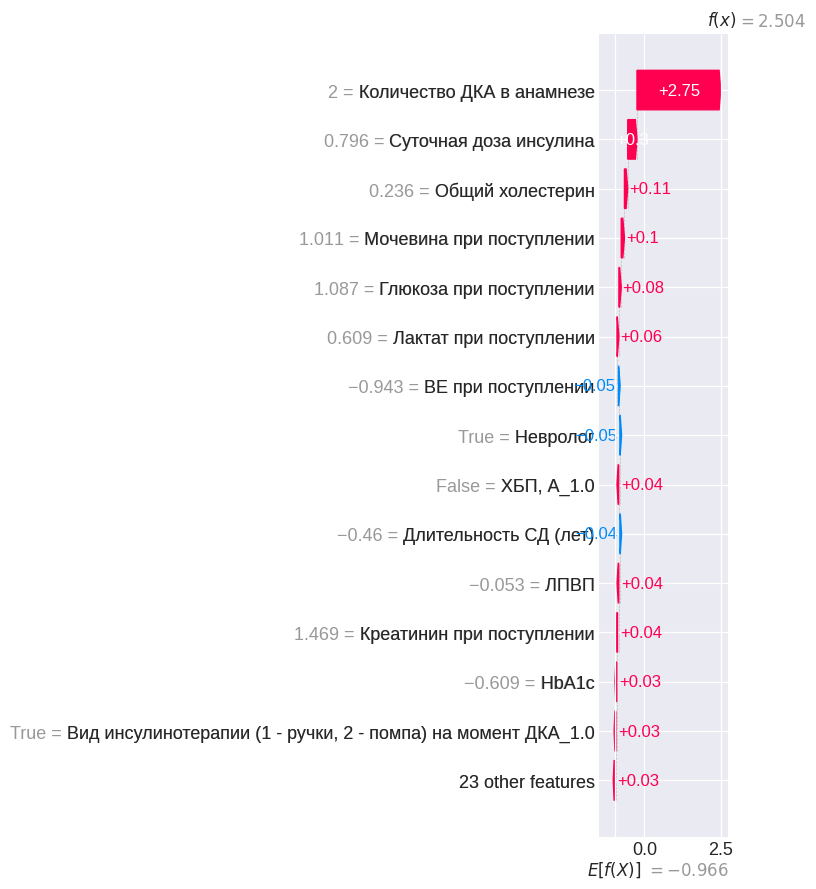

In [ ]:
# 4. Waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[20],
                                     base_values=explainer.expected_value,
                                     data=X_train.iloc[20],
                                     feature_names=feat_names),
                    max_display=15,
                    show=False)
plt.tight_layout()
plt.show()

## Обучение 2 вариант

In [ ]:
X = df.drop(['Рецидив (0 - единичный, 1 - рецидив)', 'Количество ДКА в анамнезе'], axis=1)
y = df['Рецидив (0 - единичный, 1 - рецидив)']


# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Модели
models = {
    'CatBoost': CatBoostClassifier(iterations=100, depth=3, verbose=0, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42),
    'LogRegression': LogisticRegression(max_iter=5000, random_state=42)
}

# Оценка моделей
for name, model in models.items():
    print(f"\n{'='*50}\n{name}\n{'='*50}")

    # Кросс-валидация на трейне (4 фолда)
    cv_preds = cross_val_predict(model, X_train, y_train, cv=4, method='predict')
    cv_proba = cross_val_predict(model, X_train, y_train, cv=4, method='predict_proba')[:, 1]

    print("Кросс-валидация на трейне:")
    print(f"AUC: {roc_auc_score(y_train, cv_proba):.3f}")
    print(classification_report(y_train, cv_preds, target_names=['0', '1']))

    # Обучение и оценка на тесте
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]

    print("Предсказание на тесте:")
    print(f"AUC: {roc_auc_score(y_test, test_proba):.3f}")
    print(classification_report(y_test, test_preds, target_names=['0', '1']))


CatBoost
Кросс-валидация на трейне:
AUC: 0.737
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        90
           1       0.67      0.39      0.49        51

    accuracy                           0.71       141
   macro avg       0.69      0.64      0.64       141
weighted avg       0.70      0.71      0.69       141

Предсказание на тесте:
AUC: 0.836
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.83      0.38      0.53        13

    accuracy                           0.75        36
   macro avg       0.78      0.67      0.68        36
weighted avg       0.77      0.75      0.72        36


XGBoost
Кросс-валидация на трейне:
AUC: 0.597
              precision    recall  f1-score   support

           0       0.66      0.77      0.71        90
           1       0.42      0.29      0.34        51

    accuracy                           0.60       141

In [ ]:
y.value_counts(normalize=True).round(3)

Рецидив (0 - единичный, 1 - рецидив)
False    0.638
True     0.362
Name: proportion, dtype: float64

### Жадный алгоритм

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42
)

features = list(X_train.columns)
selected_features = []

print("Жадный отбор признаков:\n")

for step in range(1, 35):
    best_feature = None
    best_auc = 0
    best_f1 = 0

    for feature in features:
        candidate_features = selected_features + [feature]

        proba = cross_val_predict(
            rf,
            X_train[candidate_features],
            y_train,
            cv=4,
            method='predict_proba'
        )[:, 1]

        preds = (proba >= 0.5).astype(int)

        auc = roc_auc_score(y_train, proba)
        f1 = f1_score(y_train, preds)

        if auc > best_auc:
            best_auc = auc
            best_f1 = f1
            best_feature = feature

    selected_features.append(best_feature)
    features.remove(best_feature)

    print(
        f"{step:2d} колонок | "
        f"добавлена: {best_feature} | "
        f"AUC = {best_auc:.3f} | "
        f"F1 = {best_f1:.3f}"
    )


Жадный отбор признаков:

 1 колонок | добавлена: Суточная доза инсулина | AUC = 0.698 | F1 = 0.410
 2 колонок | добавлена: Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА_1.0 | AUC = 0.762 | F1 = 0.512
 3 колонок | добавлена: pH при поступлении | AUC = 0.767 | F1 = 0.524
 4 колонок | добавлена: ТГ | AUC = 0.774 | F1 = 0.524
 5 колонок | добавлена: Невролог | AUC = 0.774 | F1 = 0.524
 6 колонок | добавлена: Глюкоза при поступлении | AUC = 0.778 | F1 = 0.530
 7 колонок | добавлена: ХБП, А_3.0 | AUC = 0.796 | F1 = 0.588
 8 колонок | добавлена: ЛПВП | AUC = 0.804 | F1 = 0.514
 9 колонок | добавлена: HbA1c | AUC = 0.810 | F1 = 0.507
10 колонок | добавлена: ХБП, С_3b | AUC = 0.818 | F1 = 0.545
11 колонок | добавлена: ХБП, С_2 | AUC = 0.805 | F1 = 0.533
12 колонок | добавлена: ХБП, С_4 | AUC = 0.826 | F1 = 0.486
13 колонок | добавлена: ХБП, С_5 | AUC = 0.822 | F1 = 0.479
14 колонок | добавлена: Степень тяжести ДКА_3.0 | AUC = 0.816 | F1 = 0.500
15 колонок | добавлена: Ретинопатия (0 

до добавления 12 колонки еще наблюдается прирост качества, поэтому оставим их, а также группы тех колонок, что были отобраны, чтобы сохранить их интерпретируемость

In [ ]:
df_greedy = df[['Суточная доза инсулина', 'Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА_1.0', 'Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА_2.0',
               'pH при поступлении', 'ТГ', 'Невролог' ,'Глюкоза при поступлении' ,'ЛПВП' ,'HbA1c',
               'ХБП, С_1',	'ХБП, С_2',	'ХБП, С_3',	'ХБП, С_4',	'ХБП, С_5',	'ХБП, С_3b',	'ХБП, С_3а',
               'ХБП, А_1.0',	'ХБП, А_2.0',	'ХБП, А_3.0',
               'Рецидив (0 - единичный, 1 - рецидив)']]

df_greedy

Суточная доза инсулина  \
0                 -0.016202   
1                  0.844128   
2                 -0.207387   
3                 -0.207387   
4                 -0.063998   
..                      ...   
190               -1.736863   
191               -1.736863   
192               -1.736863   
193               -1.736863   
194               -1.736863   

     Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА_1.0  \
0                                                 True              
1                                                 True              
2                                                False              
3                                                 True              
4                                                False              
..                                                 ...              
190                                               True              
191                                               True              
192                                              False              
193                                              False              
194                                              False              

     Вид инсулинотерапии (1 - ручки, 2 - помпа) на момент ДКА_2.0  \
0                                                False              
1                                                False              
2                                                False              
3                                                False              
4                                                 True              
..                                                 ...              
190                                              False              
191                                              False              
192                                              False              
193                                              False              
194                                              False              

     pH при поступлении        ТГ  Невролог  Глюкоза при поступлении  \
0             -0.010600 -0.206254     False                -0.934829   
1              0.619431 -0.206254     False                 0.387622   
2             -0.114452 -0.206254     False                 1.204678   
3             -1.499135  0.102865      True                -0.134620   
4             -0.114452 -0.206254      True                -0.260969   
..                  ...       ...       ...                      ...   
190            1.616403 -0.731757      True                -0.185159   
191           -1.935310 -0.206254     False                -0.134620   
192            1.270232 -0.659630     False                -0.345201   
193            0.508656 -0.206254     False                 0.042269   
194           -1.499135 -0.206254     False                -0.134620   

         ЛПВП     HbA1c  ХБП, С_1  ХБП, С_2  ХБП, С_3  ХБП, С_4  ХБП, С_5  \
0   -0.053296  2.266664      True     False     False     False     False   
1   -0.053296  0.133011     False      True     False     False     False   
2   -0.053296  0.556724      True     False     False     False     False   
3    0.716089 -1.039643      True     False     False     False     False   
4   -0.053296  0.411875      True     False     False     False     False   
..        ...       ...       ...       ...       ...       ...       ...   
190 -0.588519 -0.414477     False     False     False     False     False   
191 -0.053296 -0.509319     False     False     False     False     False   
192 -1.592064  0.977517     False     False     False     False     False   
193 -0.187102  0.375864     False     False     False     False     False   
194 -0.053296 -0.979595     False     False     False     False     False   

     ХБП, С_3b  ХБП, С_3а  ХБП, А_1.0  ХБП, А_2.0  ХБП, А_3.0  \
0        False      False        True       False       False   
1        False      False        True       False     

In [ ]:
X = df_greedy.drop(['Рецидив (0 - единичный, 1 - рецидив)'], axis=1)
y = df_greedy['Рецидив (0 - единичный, 1 - рецидив)']


# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Модели
models = {
    'CatBoost': CatBoostClassifier(iterations=100, depth=3, verbose=0, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42),
    'LogRegression': LogisticRegression(max_iter=5000, random_state=42)
}

# Оценка моделей
for name, model in models.items():
    print(f"\n{'='*50}\n{name}\n{'='*50}")

    # Кросс-валидация на трейне (4 фолда)
    cv_preds = cross_val_predict(model, X_train, y_train, cv=4, method='predict')
    cv_proba = cross_val_predict(model, X_train, y_train, cv=4, method='predict_proba')[:, 1]

    print("Кросс-валидация на трейне:")
    print(f"AUC: {roc_auc_score(y_train, cv_proba):.3f}")
    print(classification_report(y_train, cv_preds, target_names=['0', '1']))

    # Обучение и оценка на тесте
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]

    print("Предсказание на тесте:")
    print(f"AUC: {roc_auc_score(y_test, test_proba):.3f}")
    print(classification_report(y_test, test_preds, target_names=['0', '1']))


CatBoost
Кросс-валидация на трейне:
AUC: 0.788
              precision    recall  f1-score   support

           0       0.71      0.97      0.82        90
           1       0.83      0.29      0.43        51

    accuracy                           0.72       141
   macro avg       0.77      0.63      0.63       141
weighted avg       0.75      0.72      0.68       141

Предсказание на тесте:
AUC: 0.806
              precision    recall  f1-score   support

           0       0.70      0.91      0.79        23
           1       0.67      0.31      0.42        13

    accuracy                           0.69        36
   macro avg       0.68      0.61      0.61        36
weighted avg       0.69      0.69      0.66        36


XGBoost
Кросс-валидация на трейне:
AUC: 0.709
              precision    recall  f1-score   support

           0       0.73      0.78      0.75        90
           1       0.56      0.49      0.52        51

    accuracy                           0.67       141

#### Подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, f1_score

# Параметры для GridSearch
param_grids = {
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [2, 3, 4, 5, 6],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 1],
        'l2_leaf_reg': [1, 3, 5, 10],
        'border_count': [16, 32, 64, 128],
        'random_state': [42]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 3, 4, 5, 6],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.5, 1],
        'random_state': [42]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', None],
        'random_state': [42]
    },
    'LogRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000],
        'class_weight': ['balanced', None],
        'random_state': [42]
    }
}

# Гридсерч для каждой модели
best_models = {}
test_scores = {}
test_f1_scores = {}

for name, model in models.items():
    print(f"\n{'='*50}\nGridSearch для {name}\n{'='*50}")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=4,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    # Оценка на тесте
    test_preds = best_models[name].predict(X_test)
    test_proba = best_models[name].predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_proba)
    test_f1 = f1_score(y_test, test_preds, pos_label=1)  # F1 для класса 1

    test_scores[name] = test_auc
    test_f1_scores[name] = test_f1

    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"Лучший AUC (CV): {grid_search.best_score_:.3f}")
    print(f"AUC на тесте: {test_auc:.3f}")
    print(f"F1-score (класс 1) на тесте: {test_f1:.3f}")

    # Выводим classification report
    print(f"\nClassification Report для {name}:")
    print(classification_report(y_test, test_preds))

# Лучшая модель по F1-score для класса 1
best_model_name_f1 = max(test_f1_scores, key=test_f1_scores.get)
print(f"\n{'='*50}")
print(f"Лучшая модель по F1-score (класс 1): {best_model_name_f1}")
print(f"F1-score (класс 1): {test_f1_scores[best_model_name_f1]:.3f}")
print(f"AUC этой модели: {test_scores[best_model_name_f1]:.3f}")

# Также выводим лучшую по AUC для сравнения
best_model_name_auc = max(test_scores, key=test_scores.get)
print(f"\nЛучшая модель по AUC: {best_model_name_auc}")
print(f"AUC: {test_scores[best_model_name_auc]:.3f}")
print(f"F1-score (класс 1): {test_f1_scores[best_model_name_auc]:.3f}")


GridSearch для CatBoost
Fitting 4 folds for each of 1200 candidates, totalling 4800 fits
Лучшие параметры: {'border_count': 128, 'depth': 4, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'random_state': 42}
Лучший AUC (CV): 0.824
AUC на тесте: 0.816
F1-score (класс 1) на тесте: 0.600

Classification Report для CatBoost:
              precision    recall  f1-score   support

       False       0.76      0.96      0.85        23
        True       0.86      0.46      0.60        13

    accuracy                           0.78        36
   macro avg       0.81      0.71      0.72        36
weighted avg       0.79      0.78      0.76        36


GridSearch для XGBoost
Fitting 4 folds for each of 3840 candidates, totalling 15360 fits
Лучшие параметры: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'random_state': 42, 'subsample': 1.0}
Лучший AUC (CV): 0.835
AUC на тесте: 0.823
F1-score (класс 1) на тесте: 0.609

Classificatio

In [ ]:
y_pred = best_models[best_model_name_f1].predict(X_test)
print(f"лучшая модель: {best_model_name_f1} (AUC: {test_scores[best_model_name_f1]:.3f})")
print(classification_report(y_test, y_pred))

лучшая модель: RandomForest (AUC: 0.829)
              precision    recall  f1-score   support

       False       0.78      0.91      0.84        23
        True       0.78      0.54      0.64        13

    accuracy                           0.78        36
   macro avg       0.78      0.73      0.74        36
weighted avg       0.78      0.78      0.77        36



In [ ]:
y_pred = best_models[best_model_name_auc].predict(X_test)
print(f"лучшая модель: {best_model_name_auc} (AUC: {test_scores[best_model_name_auc]:.3f})")
print(classification_report(y_test, y_pred))

лучшая модель: RandomForest (AUC: 0.829)
              precision    recall  f1-score   support

       False       0.78      0.91      0.84        23
        True       0.78      0.54      0.64        13

    accuracy                           0.78        36
   macro avg       0.78      0.73      0.74        36
weighted avg       0.78      0.78      0.77        36



#### SHAP анализ 2 вариант без ДКА

Размерность shap_values: (141, 19, 2)


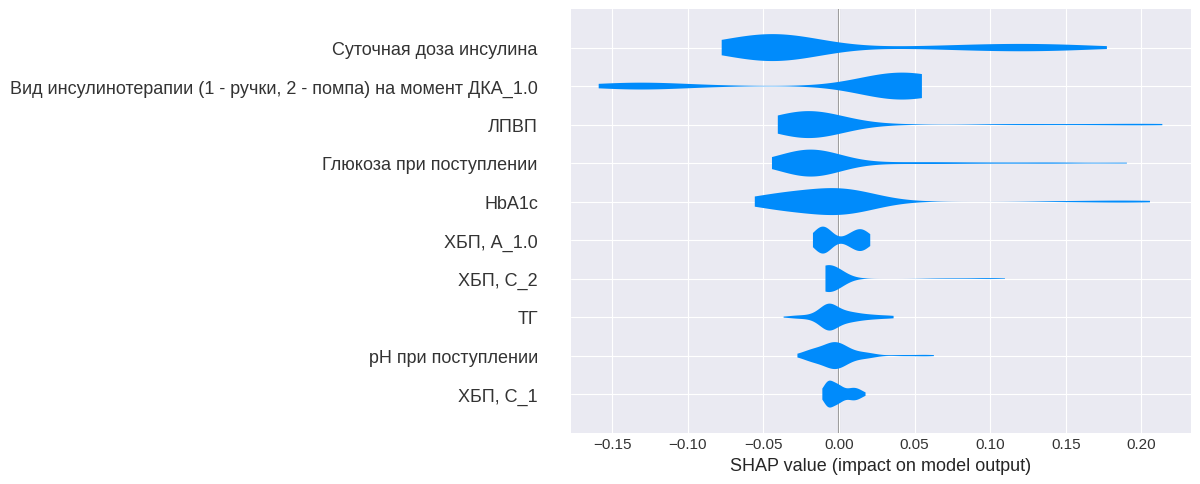

In [ ]:
# Лучшая модель (RandomForest)
best_model = best_models[best_model_name_auc]

# SHAP explainer для RandomForest
explainer = shap.TreeExplainer(best_model)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_train)

# Проверяем размерность
print(f"Размерность shap_values: {shap_values.shape}")

# Summary plot

# Для класса 1 (рецидив)
shap.plots.violin(shap_values[:, :, 1], feature_names=X_train.columns, max_display=10, title="SHAP для класса 1 (рецидив)")

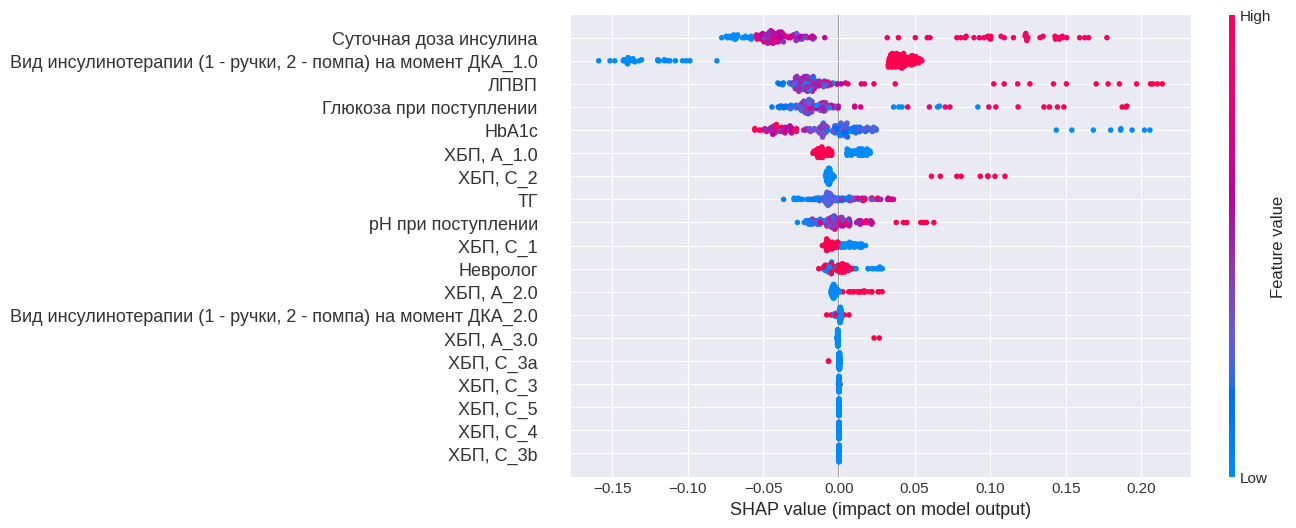

In [ ]:
# 2. beeswarm plot
# Для бинарной классификации берем SHAP значения для класса 1 (рецидив)
shap_values_class1 = shap_values[:, :, 1]

# Beeswarm plot для класса 1
shap.plots.beeswarm(shap.Explanation(values=shap_values_class1,
                                     base_values=explainer.expected_value[1],
                                     data=X_train,
                                     feature_names=X_train.columns),
                    max_display=20,
                    plot_size=(10, 6))

In [ ]:
# 3. Численные значения важности
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'shap_importance': np.abs(shap_values_class1).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

print("\nТоп-10 важных признаков по SHAP:")
print(shap_importance.head(10))


Топ-10 важных признаков по SHAP:
                                              feature  shap_importance
0                              Суточная доза инсулина         0.063852
1   Вид инсулинотерапии (1 - ручки, 2 - помпа) на ...         0.061372
7                                                ЛПВП         0.034719
6                             Глюкоза при поступлении         0.030826
8                                               HbA1c         0.029524
16                                         ХБП, А_1.0         0.011805
10                                           ХБП, С_2         0.011801
4                                                  ТГ         0.011117
3                                  pH при поступлении         0.011061
9                                            ХБП, С_1         0.006386


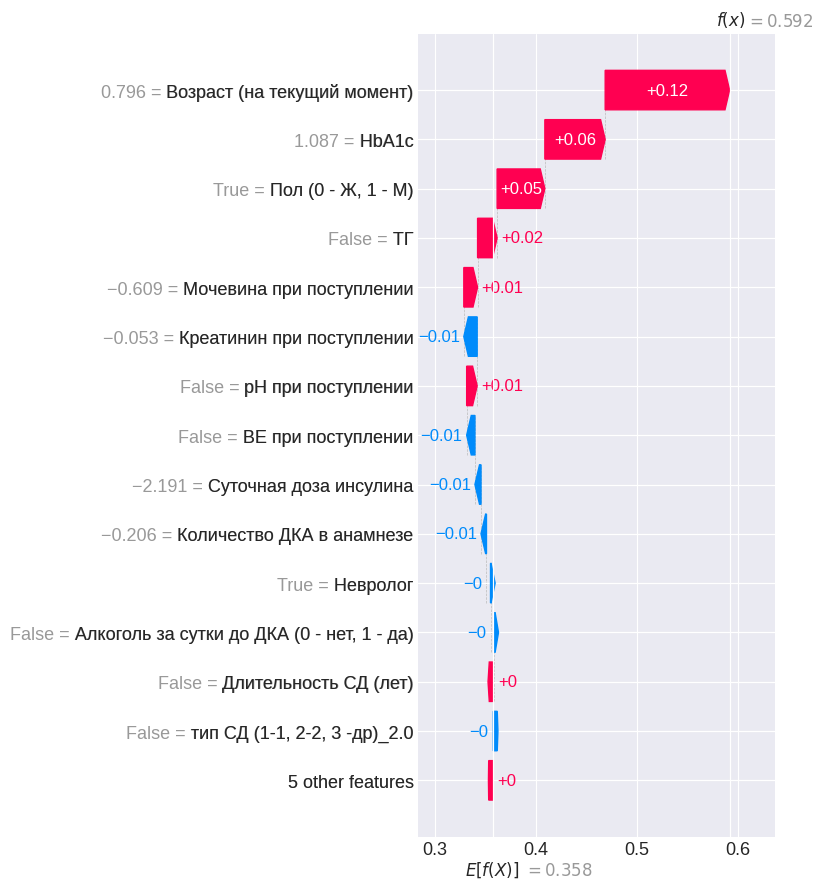

In [ ]:
# 4. Waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[20],
                                     base_values=explainer.expected_value[1],
                                     data=X_train.iloc[20],
                                     feature_names=feat_names),
                    max_display=15,
                    show=False)
plt.tight_layout()
plt.show()

### ЭКСПЕРТНОЕ СОСТАВЛЕНИЕ КОЛОНОК

In [ ]:
df

Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  Длительность СД (лет)  \
0                       0.032554                True              -0.937658   
1                       2.242683                True              -0.341089   
2                      -0.835710                True              -1.056971   
3                       0.585086               False              -1.056971   
4                       1.058685               False               0.136166   
..                           ...                 ...                    ...   
190                     0.427220               False               3.238323   
191                    -1.072510               False               0.136166   
192                     2.242683                True              -1.056971   
193                     0.190421               False              -1.056971   
194                     2.005883               False               1.329303   

     Суточная доза инсулина  Количество ДКА в анамнезе  Невролог     HbA1c  \
0                 -0.016202                          1     False  2.266664   
1                  0.844128                          3     False  0.133011   
2                 -0.207387                          1     False  0.556724   
3                 -0.207387                          1      True -1.039643   
4                 -0.063998                          2      True  0.411875   
..                      ...                        ...       ...       ...   
190               -1.736863                          1      True -0.414477   
191               -1.736863                          1     False -0.509319   
192               -1.736863                          1     False  0.977517   
193               -1.736863                          1     False  0.375864   
194               -1.736863                          1     False -0.979595   

     Креатинин при поступлении  Мочевина при поступлении  pH при поступлении  \
0                    -0.157520                 -0.195827           -0.010600   
1                     2.724759                  3.967776            0.619431   
2                    -0.148008                  0.001267           -0.114452   
3                     0.936414                 -0.294374           -1.499135   
4                    -0.157520                 -0.195827           -0.114452   
..                         ...                       ...                 ...   
190                  -1.023155                 -0.146554            1.616403   
191                   4.189680                  1.898293           -1.935310   
192                  -0.071908                 -0.442194            1.270232   
193                   0.213466                 -0.442194            0.508656   
194                  -0.167033                  0.494001           -1.499135   

     ВЕ при поступлении  Лактат при поступлении  Глюкоза при поступлении  \
0             -0.764179               -1.339454                -0.934829   
1             -0.553723               -0.560215                 0.387622   
2             -0.324134               -0.170596                 1.204678   
3             -0.324134               -0.755025                -0.134620   
4             -0.324134               -0.170596                -0.260969   
..                  ...                     ...                      ...   
190            0.115911                1.322945                -0.185159   
191           -0.878973               -0.170596                -0.134620   
192            0.549579               -0.755025                -0.345201   
193           -0.158320               -0.235533                 0.042269   
194           -0.655762                0.673579                -0.134620   

     Общий холестерин      ЛПНП      ЛПВП        ТГ  \
0           -0.071806 -0.110450 -0.053296 -0.206254   
1           -0.071806 -0.110450 -0.053296 -0.206254   
2           -0.071806 -0.110450 -0.053296 -0.206254   
3            2.371036  3.

In [ ]:
df_expert = df.drop(['Невролог','Креатинин при поступлении','Мочевина при поступлении','ЛПВП','Степень тяжести ДКА_2.0','Степень тяжести ДКА_3.0','Количество ДКА в анамнезе'], axis=1)
df_expert

Возраст (на текущий момент)  Пол (0 - Ж, 1 - М)  Длительность СД (лет)  \
0                       0.032554                True              -0.937658   
1                       2.242683                True              -0.341089   
2                      -0.835710                True              -1.056971   
3                       0.585086               False              -1.056971   
4                       1.058685               False               0.136166   
..                           ...                 ...                    ...   
190                     0.427220               False               3.238323   
191                    -1.072510               False               0.136166   
192                     2.242683                True              -1.056971   
193                     0.190421               False              -1.056971   
194                     2.005883               False               1.329303   

     Суточная доза инсулина     HbA1c  pH при поступлении  ВЕ при поступлении  \
0                 -0.016202  2.266664           -0.010600           -0.764179   
1                  0.844128  0.133011            0.619431           -0.553723   
2                 -0.207387  0.556724           -0.114452           -0.324134   
3                 -0.207387 -1.039643           -1.499135           -0.324134   
4                 -0.063998  0.411875           -0.114452           -0.324134   
..                      ...       ...                 ...                 ...   
190               -1.736863 -0.414477            1.616403            0.115911   
191               -1.736863 -0.509319           -1.935310           -0.878973   
192               -1.736863  0.977517            1.270232            0.549579   
193               -1.736863  0.375864            0.508656           -0.158320   
194               -1.736863 -0.979595           -1.499135           -0.655762   

     Лактат при поступлении  Глюкоза при поступлении  Общий холестерин  \
0                 -1.339454                -0.934829         -0.071806   
1                 -0.560215                 0.387622         -0.071806   
2                 -0.170596                 1.204678         -0.071806   
3                 -0.755025                -0.134620          2.371036   
4                 -0.170596                -0.260969         -0.071806   
..                      ...                      ...               ...   
190                1.322945                -0.185159         -0.703870   
191               -0.170596                -0.134620         -1.310310   
192               -0.755025                -0.345201          0.363806   
193               -0.235533                 0.042269          0.927539   
194                0.673579                -0.134620          0.346723   

         ЛПНП        ТГ  Алкоголь за сутки до ДКА (0 - нет, 1 - да)  \
0   -0.110450 -0.206254                                       False   
1   -0.110450 -0.206254                                       False   
2   -0.110450 -0.206254                                       False   
3    3.151884  0.102865                                       False   
4   -0.110450 -0.206254                                       False   
..        ...       ...                                         ...   
190 -0.311678 -0.731757                                       False   
191 -0.110450 -0.206254                                       False   
192  1.554255 -0.659630                                       False   
193 -0.110450 -0.206254                                       False   
194 -0.110450 -0.206254                                       False   

     Рецидив (0 - единичный, 1 - рецидив)  тип СД (1-1, 2-2, 3 -др)_2.0  \
0                                   False                         False   
1                                    True                          True   
2                                   False                         False   
3                                   False

In [ ]:
X = df_expert.drop(['Рецидив (0 - единичный, 1 - рецидив)'], axis=1)
y = df_expert['Рецидив (0 - единичный, 1 - рецидив)']


# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Модели
models = {
    'CatBoost': CatBoostClassifier(iterations=100, depth=3, verbose=0, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42),
    'LogRegression': LogisticRegression(max_iter=5000, random_state=42)
}

# Оценка моделей
for name, model in models.items():
    print(f"\n{'='*50}\n{name}\n{'='*50}")

    # Кросс-валидация на трейне (4 фолда)
    cv_preds = cross_val_predict(model, X_train, y_train, cv=4, method='predict')
    cv_proba = cross_val_predict(model, X_train, y_train, cv=4, method='predict_proba')[:, 1]

    print("Кросс-валидация на трейне:")
    print(f"AUC: {roc_auc_score(y_train, cv_proba):.3f}")
    print(classification_report(y_train, cv_preds, target_names=['0', '1']))

    # Обучение и оценка на тесте
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]

    print("Предсказание на тесте:")
    print(f"AUC: {roc_auc_score(y_test, test_proba):.3f}")
    print(classification_report(y_test, test_preds, target_names=['0', '1']))


CatBoost
Кросс-валидация на трейне:
AUC: 0.703
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        90
           1       0.52      0.31      0.39        51

    accuracy                           0.65       141
   macro avg       0.60      0.57      0.57       141
weighted avg       0.62      0.65      0.62       141

Предсказание на тесте:
AUC: 0.833
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        23
           1       0.86      0.46      0.60        13

    accuracy                           0.78        36
   macro avg       0.81      0.71      0.72        36
weighted avg       0.79      0.78      0.76        36


XGBoost
Кросс-валидация на трейне:
AUC: 0.612
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        90
           1       0.44      0.37      0.40        51

    accuracy                           0.60       141

#### Подбор гиперпараметров

In [ ]:
# Параметры для GridSearch
param_grids = {
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [2, 3, 4, 5, 6],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 1],
        'l2_leaf_reg': [1, 3, 5, 10],
        'border_count': [16, 32, 64, 128],
        'random_state': [42]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 3, 4, 5, 6],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.5, 1],
        'random_state': [42]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', None],
        'random_state': [42]
    },
    'LogRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000],
        'class_weight': ['balanced', None],
        'random_state': [42]
    }
}

# Гридсерч для каждой модели
best_models = {}
test_scores = {}
test_f1_scores = {}

for name, model in models.items():
    print(f"\n{'='*50}\nGridSearch для {name}\n{'='*50}")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=4,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    # Оценка на тесте
    test_preds = best_models[name].predict(X_test)
    test_proba = best_models[name].predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_proba)
    test_f1 = f1_score(y_test, test_preds, pos_label=1)  # F1 для класса 1

    test_scores[name] = test_auc
    test_f1_scores[name] = test_f1

    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"Лучший AUC (CV): {grid_search.best_score_:.3f}")
    print(f"AUC на тесте: {test_auc:.3f}")
    print(f"F1-score (класс 1) на тесте: {test_f1:.3f}")

    # Выводим classification report
    print(f"\nClassification Report для {name}:")
    print(classification_report(y_test, test_preds))

# Лучшая модель по F1-score для класса 1
best_model_name_f1 = max(test_f1_scores, key=test_f1_scores.get)
print(f"\n{'='*50}")
print(f"Лучшая модель по F1-score (класс 1): {best_model_name_f1}")
print(f"F1-score (класс 1): {test_f1_scores[best_model_name_f1]:.3f}")
print(f"AUC этой модели: {test_scores[best_model_name_f1]:.3f}")

# Также выводим лучшую по AUC для сравнения
best_model_name_auc = max(test_scores, key=test_scores.get)
print(f"\nЛучшая модель по AUC: {best_model_name_auc}")
print(f"AUC: {test_scores[best_model_name_auc]:.3f}")
print(f"F1-score (класс 1): {test_f1_scores[best_model_name_auc]:.3f}")


GridSearch для CatBoost
Fitting 4 folds for each of 1200 candidates, totalling 4800 fits
Лучшие параметры: {'border_count': 16, 'depth': 2, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'random_state': 42}
Лучший AUC (CV): 0.758
AUC на тесте: 0.793
F1-score (класс 1) на тесте: 0.421

Classification Report для CatBoost:
              precision    recall  f1-score   support

       False       0.70      0.91      0.79        23
        True       0.67      0.31      0.42        13

    accuracy                           0.69        36
   macro avg       0.68      0.61      0.61        36
weighted avg       0.69      0.69      0.66        36


GridSearch для XGBoost
Fitting 4 folds for each of 3840 candidates, totalling 15360 fits
Лучшие параметры: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'random_state': 42, 'subsample': 1.0}
Лучший AUC (CV): 0.758
AUC на тесте: 0.774
F1-score (класс 1) на тесте: 0.250

Classificati

#### SHAP анализ 2 вариант без ДКА

Размерность shap_values: (141, 30, 2)


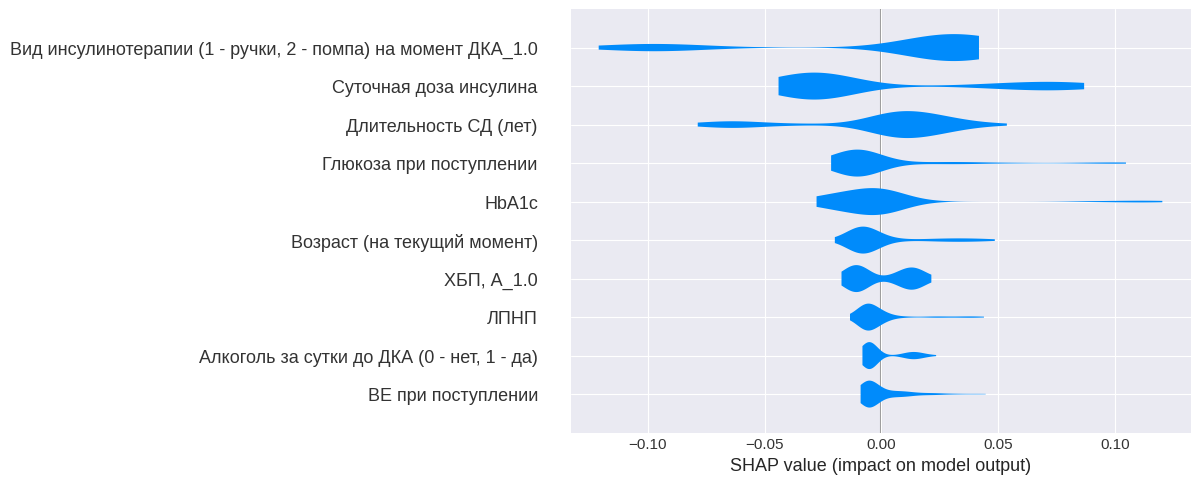

In [ ]:
# Лучшая модель
best_model = best_models[best_model_name_auc]

# SHAP explainer для RandomForest
explainer = shap.TreeExplainer(best_model)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_train)

# Проверяем размерность
print(f"Размерность shap_values: {shap_values.shape}")

# Summary plot

# Для класса 1 (рецидив)
shap.plots.violin(shap_values[:, :, 1], feature_names=X_train.columns, max_display=10, title="SHAP для класса 1 (рецидив)")

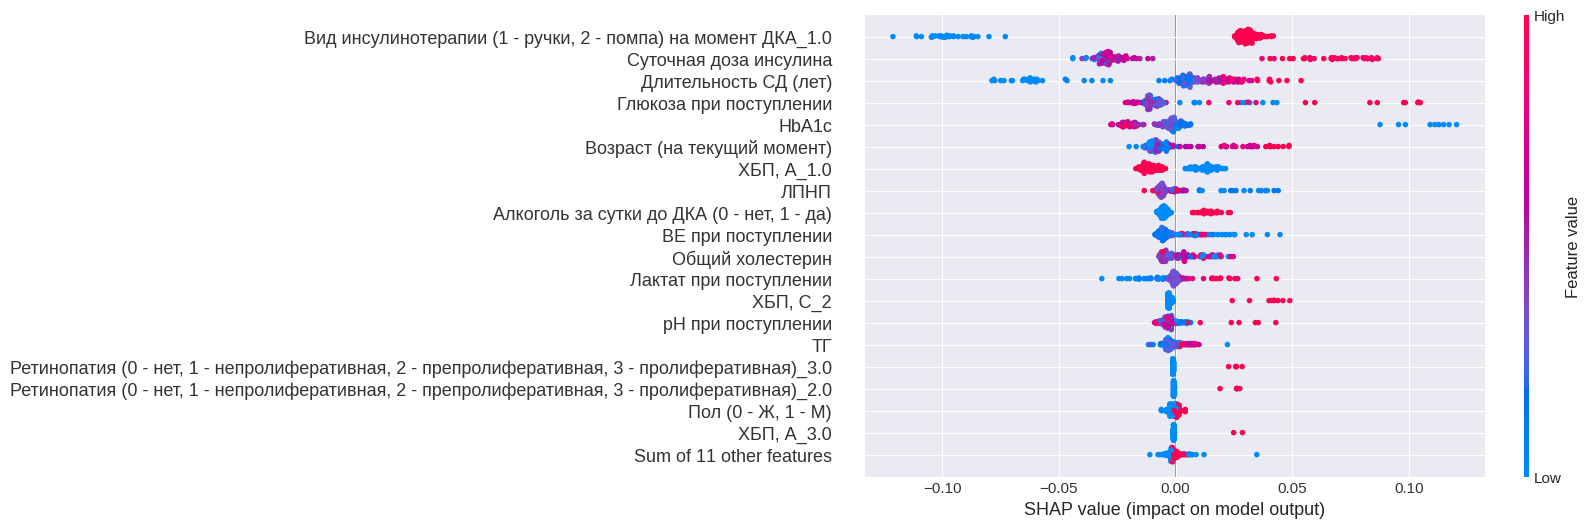

In [ ]:
# 2. beeswarm plot
# Для бинарной классификации берем SHAP значения для класса 1 (рецидив)
shap_values_class1 = shap_values[:, :, 1]

# Beeswarm plot для класса 1
shap.plots.beeswarm(shap.Explanation(values=shap_values_class1,
                                     base_values=explainer.expected_value[1],
                                     data=X_train,
                                     feature_names=X_train.columns),
                    max_display=20,
                    plot_size=(10, 6))

In [ ]:
# 3. Численные значения важности
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'shap_importance': np.abs(shap_values_class1).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

print("\nТоп-10 важных признаков по SHAP:")
print(shap_importance.head(10))


Топ-10 важных признаков по SHAP:
                                              feature  shap_importance
15  Вид инсулинотерапии (1 - ручки, 2 - помпа) на ...         0.046092
3                              Суточная доза инсулина         0.039827
2                               Длительность СД (лет)         0.023520
8                             Глюкоза при поступлении         0.017053
4                                               HbA1c         0.014655
0                         Возраст (на текущий момент)         0.012218
24                                         ХБП, А_1.0         0.011607
10                                               ЛПНП         0.007722
12         Алкоголь за сутки до ДКА (0 - нет, 1 - да)         0.007533
6                                  ВЕ при поступлении         0.007434


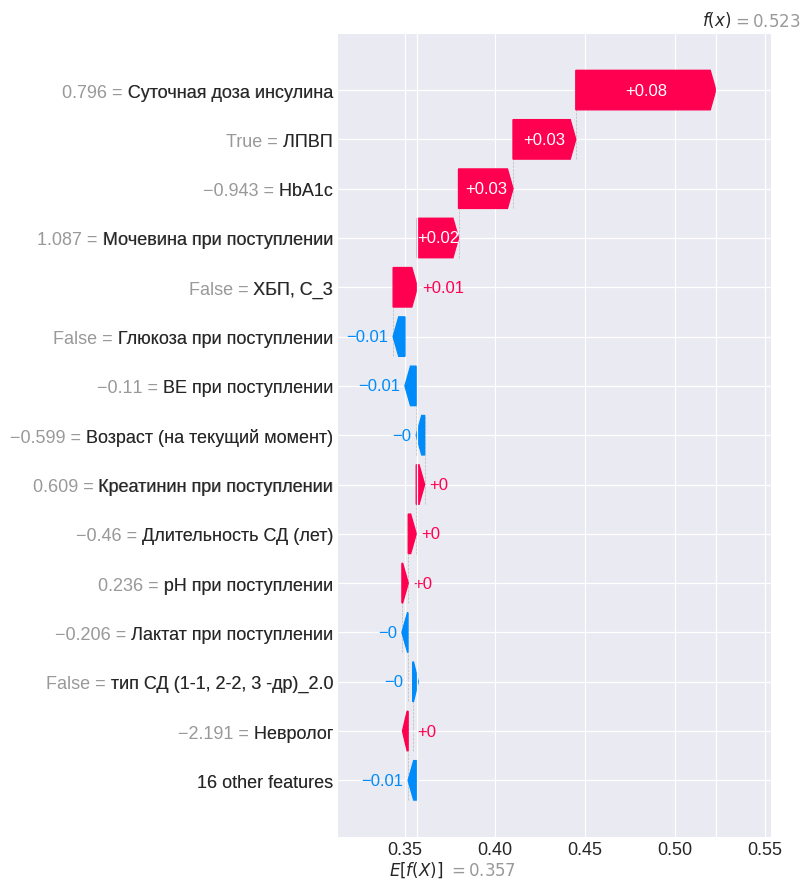

In [ ]:
# 4. Waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[20],
                                     base_values=explainer.expected_value[1],
                                     data=X_train.iloc[20],
                                     feature_names=feat_names),
                    max_display=15,
                    show=False)
plt.tight_layout()
plt.show()